In [1]:
# !pip install pytorch==2.5.0 torchvision==0.20.0 torchaudio==2.5.0 pytorch-cuda==12.4
# !pip install transformers datasets==2.21.0 tiktoken wandb h5py einops pandas scikit-learn
# !pip install mne

In [2]:
import os
import numpy as np
import torch
from pathlib import Path
import matplotlib.pyplot as plt
from model.model_vq_periodic_v3 import VQ_Align
from model.model_neural_transformer import NTConfig
import torch.nn.functional as F
# Disable gradient computation for inference
torch.set_grad_enabled(False)

# Configuration parameters - modify these as needed
ckpt_path = "ckpt-301.pt"  # Path to the checkpoint file
device = "cuda" if torch.cuda.is_available() else "mps"  # Device to run inference on
output_dir = "./outputs"  # Directory to save outputs
batch_size = 1  # Batch size for inference
seed = 1337  # Random seed for reproducibility

def load_model(ckpt_path, device):
    """Load the VQ_Align model from checkpoint"""
    checkpoint = torch.load(ckpt_path, map_location=device)
    
    # Create model configuration and initialize
    encoder_conf = NTConfig(**checkpoint['encoder_args'])
    decoder_conf = NTConfig(**checkpoint['decoder_args'])
    model = VQ_Align(encoder_conf, decoder_conf)
    
    # Fix state dict keys if needed
    state_dict = checkpoint['model']
    for k in list(state_dict.keys()):
        if k.startswith('_orig_mod.'):
            state_dict[k[len('_orig_mod.'):]] = state_dict.pop(k)
    
    # Load state dict and prepare model
    model.VQ.init_ae_layer()
    model.load_state_dict(state_dict)
    model.to(device).eval()
    
    return model


def prepare_input(input_file, device):
    """
    Prepare input data for inference
    Note: You may need to modify this function based on your specific input format
    """
    # This is a placeholder function - modify according to your input format
    try:
        # Assuming the input is similar to what's used in training
        data = np.load(input_file)
        # Convert to tensor and move to device
        X = torch.from_numpy(data).float().to(device)

        # If your input needs specific preprocessing, add it here

        return X
    except Exception as e:
        print(f"Error loading input file: {e}")


torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

print(f"Using device: {device}")

# Configure CUDA settings if using GPU
if 'cuda' in device:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

# Load model from checkpoint
model = load_model(ckpt_path, device)

model

Using device: mps


/var/folders/nc/zbqbbkkx08z7v1g3mlf8bdn00000gn/T/ipykernel_98241/3872045653.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_locat

{}
Final encoder config NTConfig(block_size=1024, patch_size=200, num_classes=0, in_chans=1, out_chans=16, use_mean_pooling=True, init_scale=0.001, n_layer=12, n_head=12, n_embd=768, dropout=0.1, bias=False)
Final decoder config NTConfig(block_size=1024, patch_size=200, num_classes=0, in_chans=128, out_chans=16, use_mean_pooling=True, init_scale=0.001, n_layer=4, n_head=12, n_embd=768, dropout=0.1, bias=False)


VQ_Align(
  (VQ): VQ(
    (encoder): NeuralTransformer(
      (patch_embed): TemporalConv(
        (conv1): Conv2d(1, 16, kernel_size=(1, 15), stride=(1, 8), padding=(0, 7))
        (gelu1): GELU(approximate='none')
        (norm1): GroupNorm(4, 16, eps=1e-05, affine=True)
        (conv2): Conv2d(16, 16, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
        (gelu2): GELU(approximate='none')
        (norm2): GroupNorm(4, 16, eps=1e-05, affine=True)
        (conv3): Conv2d(16, 16, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
        (norm3): GroupNorm(4, 16, eps=1e-05, affine=True)
        (gelu3): GELU(approximate='none')
        (l): Sequential(
          (0): Linear(in_features=400, out_features=768, bias=True)
          (1): GELU(approximate='none')
        )
      )
      (pos_embed): Embedding(256, 768)
      (time_embed): Embedding(64, 768)
      (blocks): ModuleList(
        (0-11): 12 x Block(
          (ln_1): LayerNorm()
          (attn): CausalSelfAttention(
      

In [3]:

from dataset import PickleLoader
data_dir = 'tuh'
files = Path(data_dir).rglob('*.pkl')
files = [file for file in files][:10000]
dataset1 = PickleLoader(files)

data_loader1 = torch.utils.data.DataLoader(
    dataset1,
    batch_size=1,
    num_workers=1,
    pin_memory=True,
    drop_last=True,
    shuffle=True
)



data_dir = 'thinking-out-loud/'
files = Path(data_dir).rglob('*.pkl')
files = [file for file in files][:10000]
dataset2 = PickleLoader(files)

data_loader2 = torch.utils.data.DataLoader(
    dataset2,
    batch_size=1,
    num_workers=1,
    pin_memory=True,
    drop_last=True,
    shuffle=True
)




In [4]:
a = dataset1[0][0][:-15:23, :].flatten().cpu().numpy()
a.mean(), a.std()

tuh/00005932_s004_t000_10.pkl


(np.float32(3.4679066e-09), np.float32(0.99994314))

tuh/00007927_s004_t001_6.pkl
tuh/00006238_s001_t000_24.pkl
Original shape: torch.Size([1, 1024, 200]), Reshaped: torch.Size([1, 23, 8800])


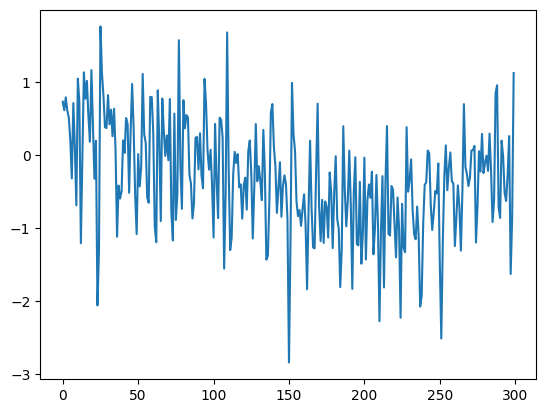

In [5]:

def reshape_data_by_channels(data, ch_names, num_channels=23):
    """
    Reshape data tensor to organize by channels consistently across time.
    
    Args:
        data: Input tensor of shape [batch, tokens, time_samples]
        ch_names: Tensor containing channel indices for each token
        num_channels: Number of unique channels
    
    Returns:
        Reshaped tensor of shape [batch, num_channels, tokens_per_channel*time_samples]
    """
    batch_size, num_tokens, time_samples = data.shape
    
    # Calculate how many tokens per channel we have
    tokens_per_channel = num_tokens // num_channels
    
    # Create output tensor
    reshaped_data = torch.zeros((batch_size, num_channels, tokens_per_channel * time_samples))
    
    # Get the unique channel indices from ch_names
    unique_channels = torch.unique(ch_names[0])
    
    # For each unique channel, find all tokens with that channel and place them in sequence
    for i, channel_idx in enumerate(unique_channels[:num_channels]):
        # Find positions where this channel appears
        channel_positions = (ch_names[0] == channel_idx).nonzero(as_tuple=True)[0]
        
        # For each position, place the corresponding data in the output tensor
        for j, pos in enumerate(channel_positions):
            if j < tokens_per_channel:  # Ensure we don't exceed the expected tokens per channel
                start_idx = j * time_samples
                end_idx = (j + 1) * time_samples
                reshaped_data[0, i, start_idx:end_idx] = data[0, pos, :]
    
    return reshaped_data


batch = next(iter(data_loader1))
X, Y_freq, Y_raw, input_chans, input_time, input_mask = batch

# # Example usage
data = X
reshaped_data = reshape_data_by_channels(data, input_chans, num_channels=23)
print(f"Original shape: {data.shape}, Reshaped: {reshaped_data.shape}")  # Should be [1, 23, 44*200]

plt.plot(reshaped_data[0,2].cpu().numpy()[:300])



tuh/00005468_s001_t000_15.pkl
tuh/00007927_s004_t001_45.pkl


/Users/adamsobieszek/PycharmProjects/NeuroLM-Decode/model/model_vq_periodic_v3.py:468: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


tuh/00006273_s003_t001_3.pkl
Input shape: torch.Size([1, 1024, 200])
Raw reconstruction shape: torch.Size([1, 1024, 200])
Freq reconstruction shape: torch.Size([1, 1024, 100])

Generating Matplotlib visualizations...
tuh/00009559_s001_t000_31.pkl
tuh/00009966_s001_t002_0.pkl


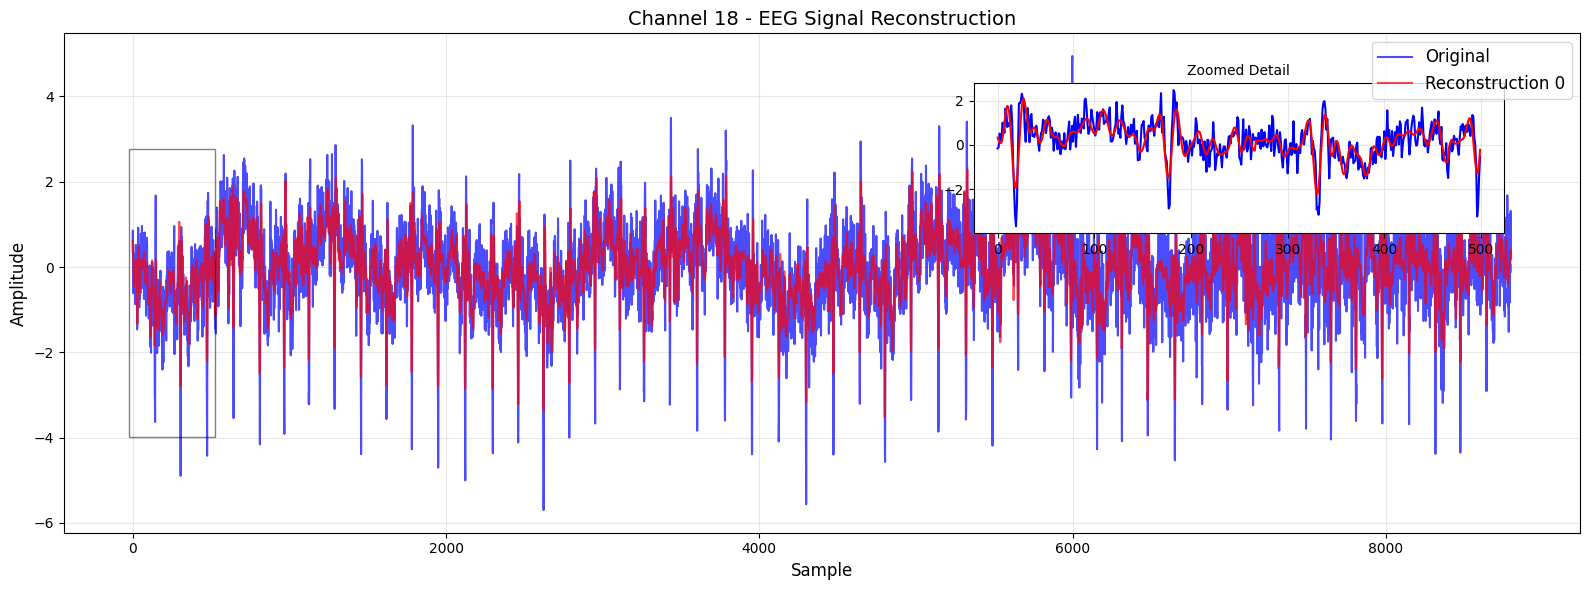

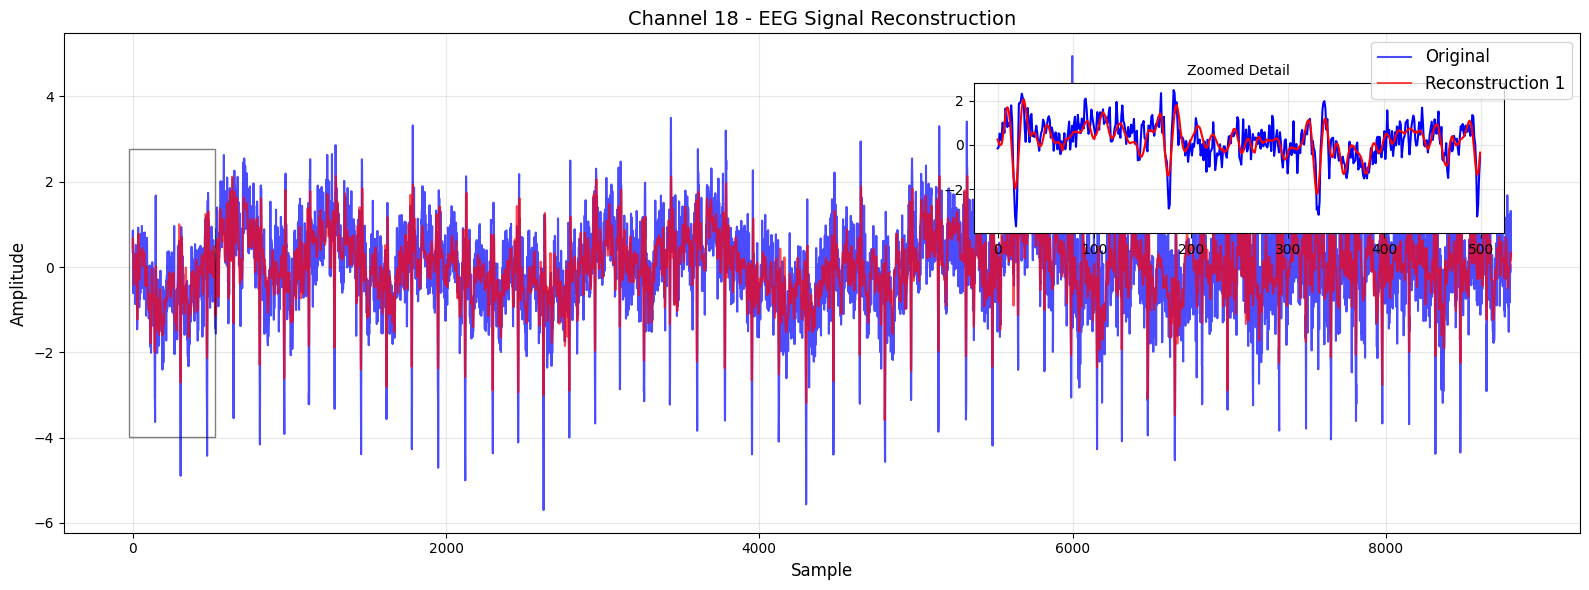

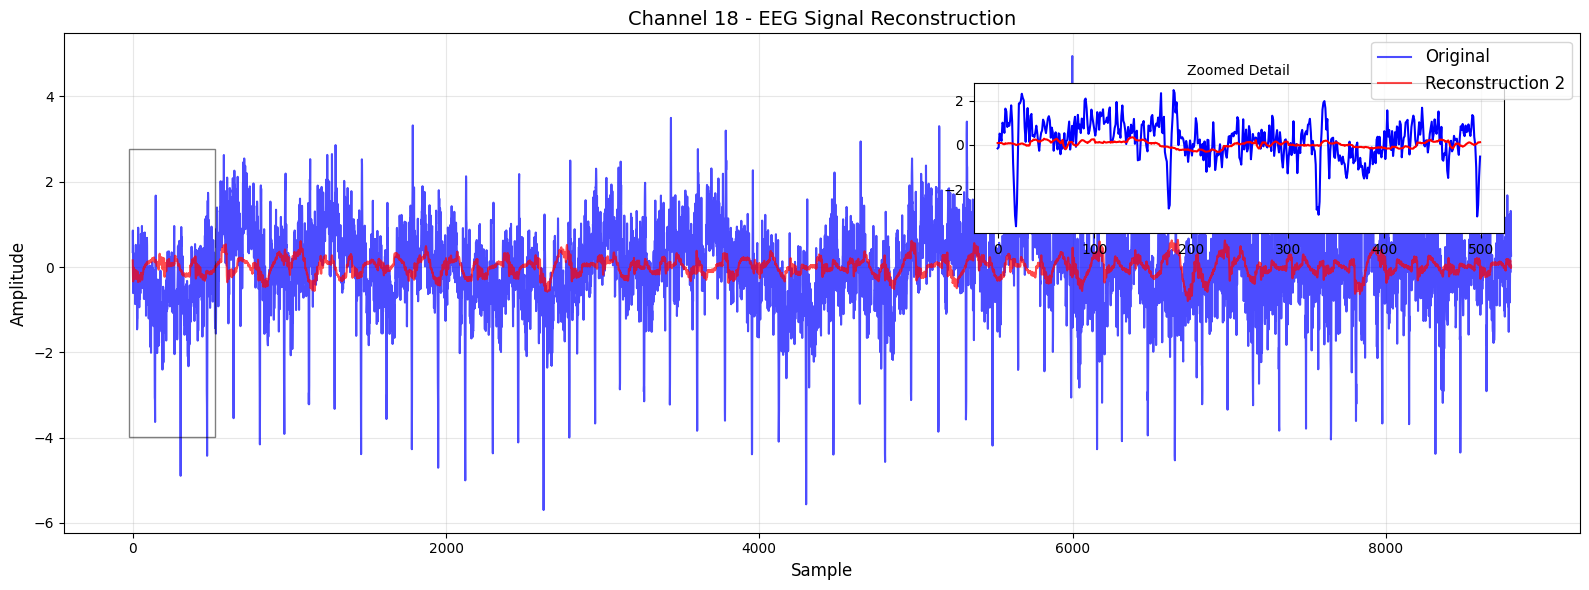

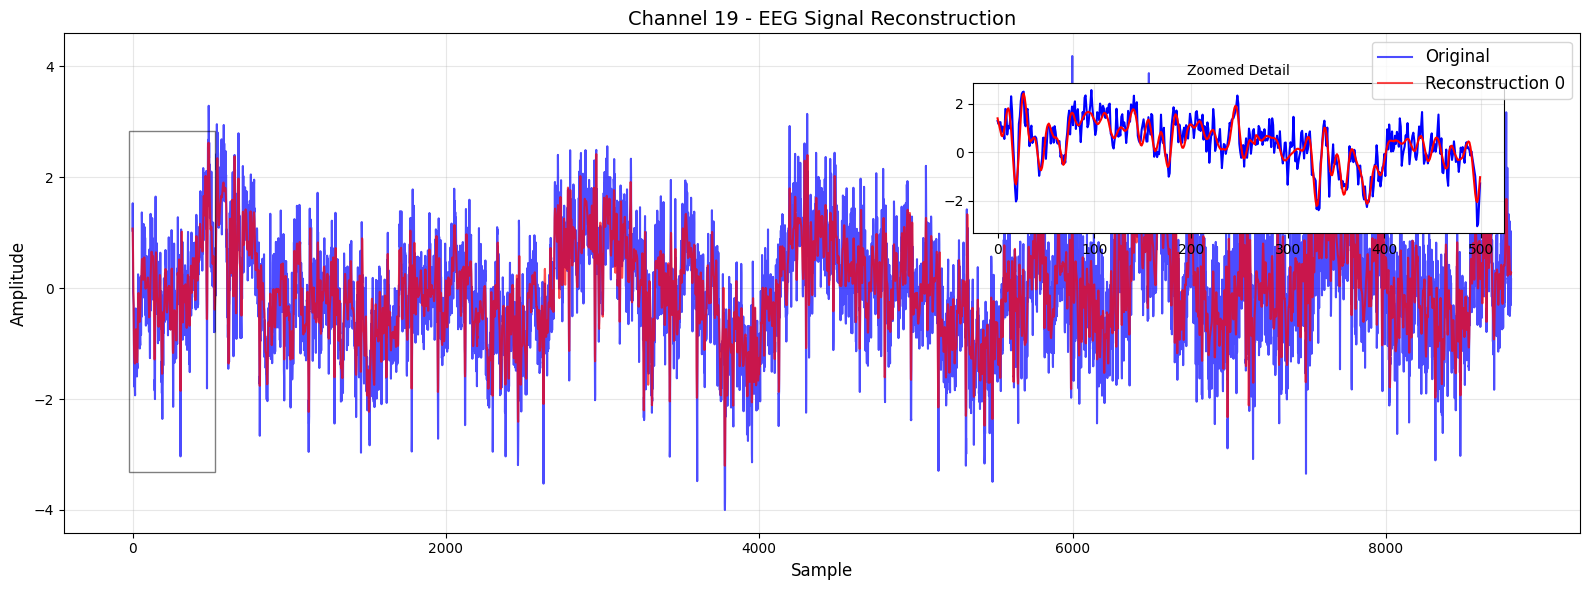

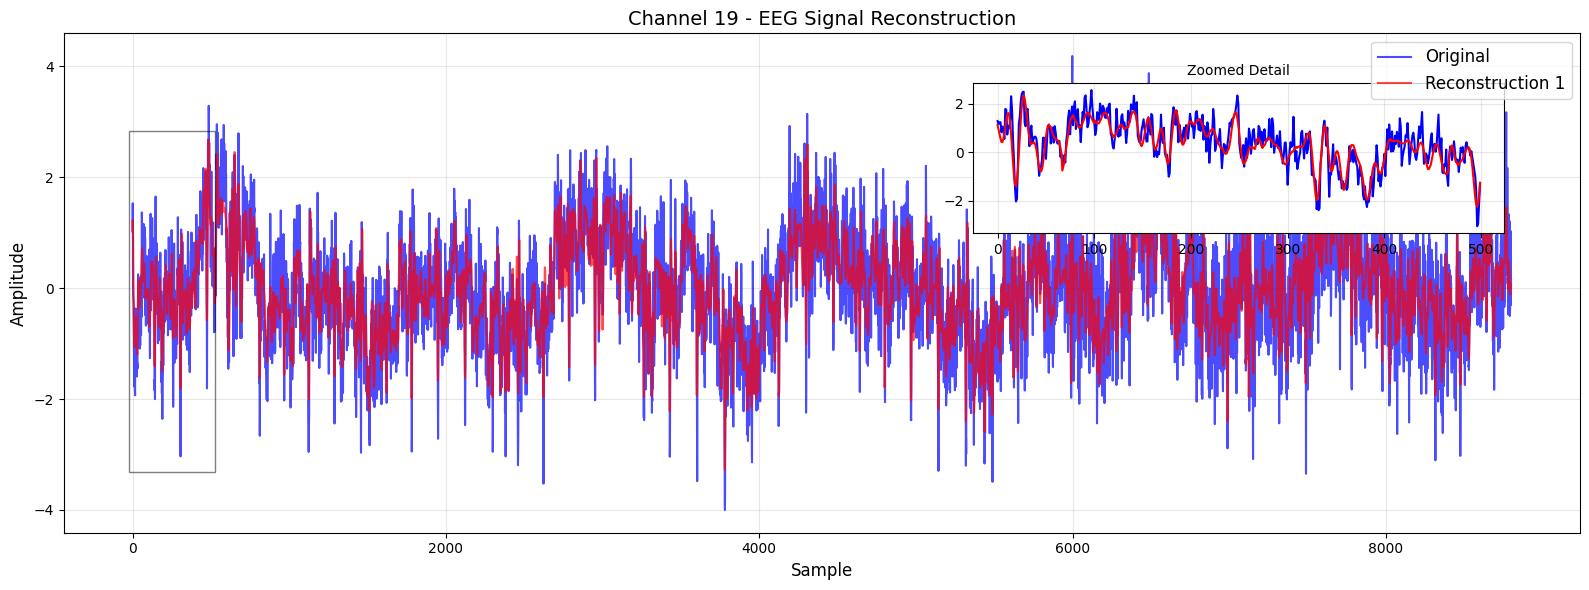

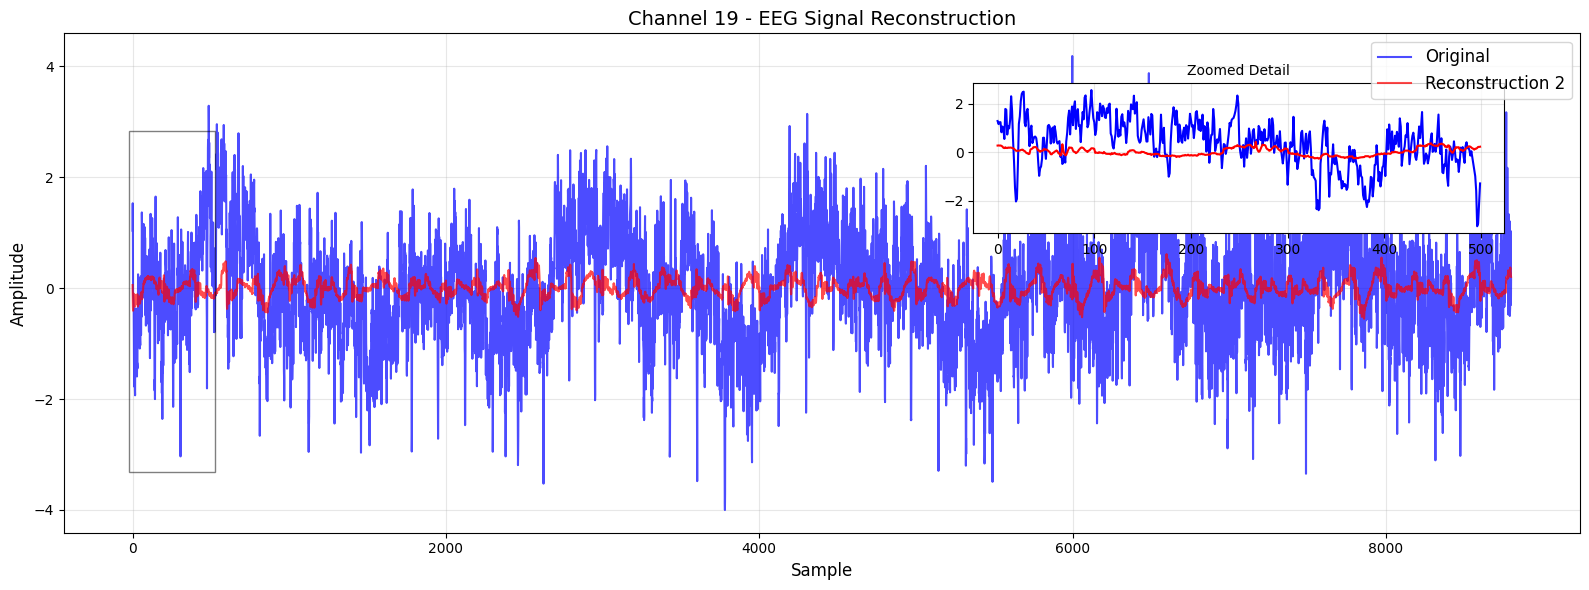

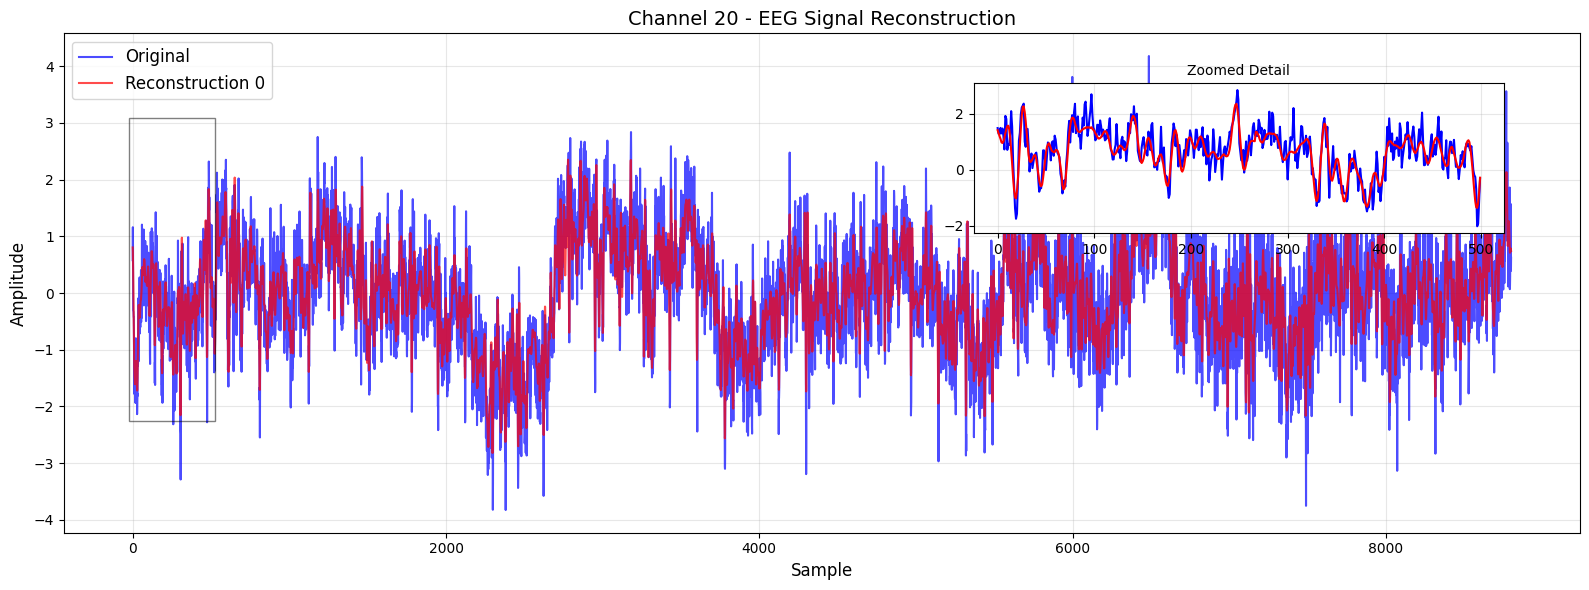

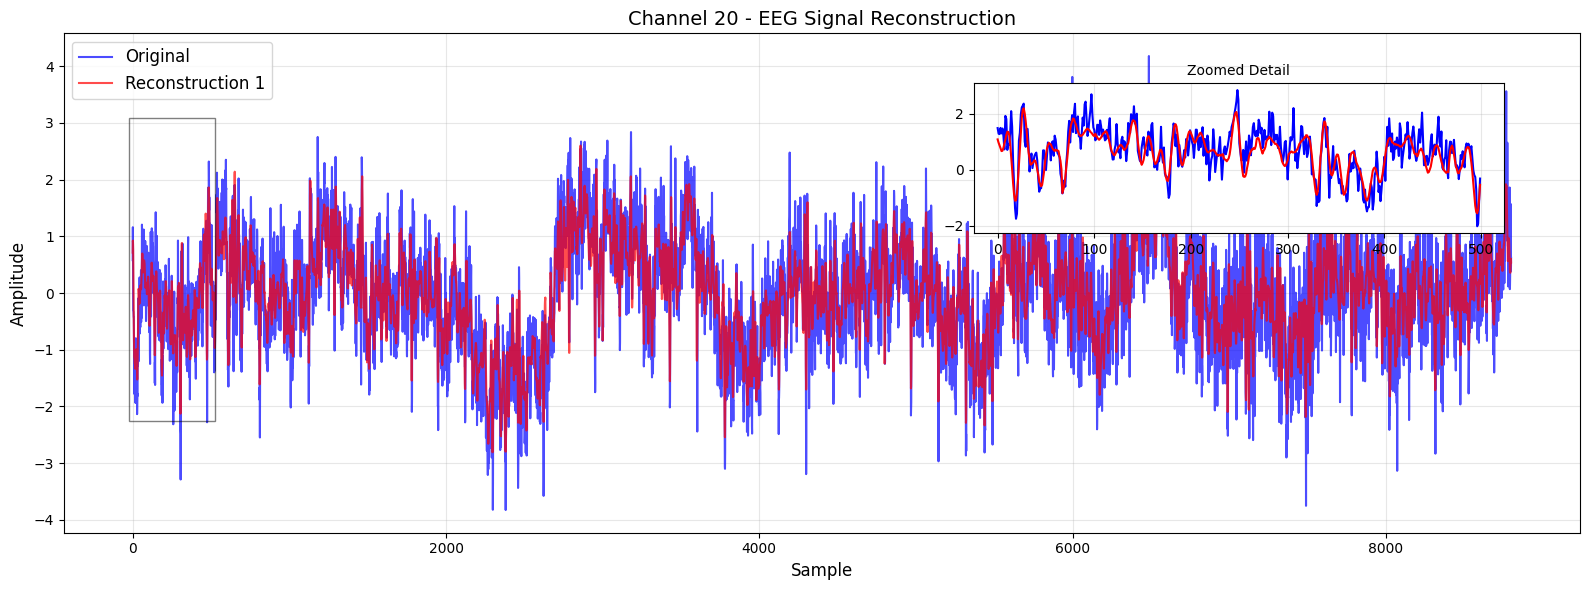

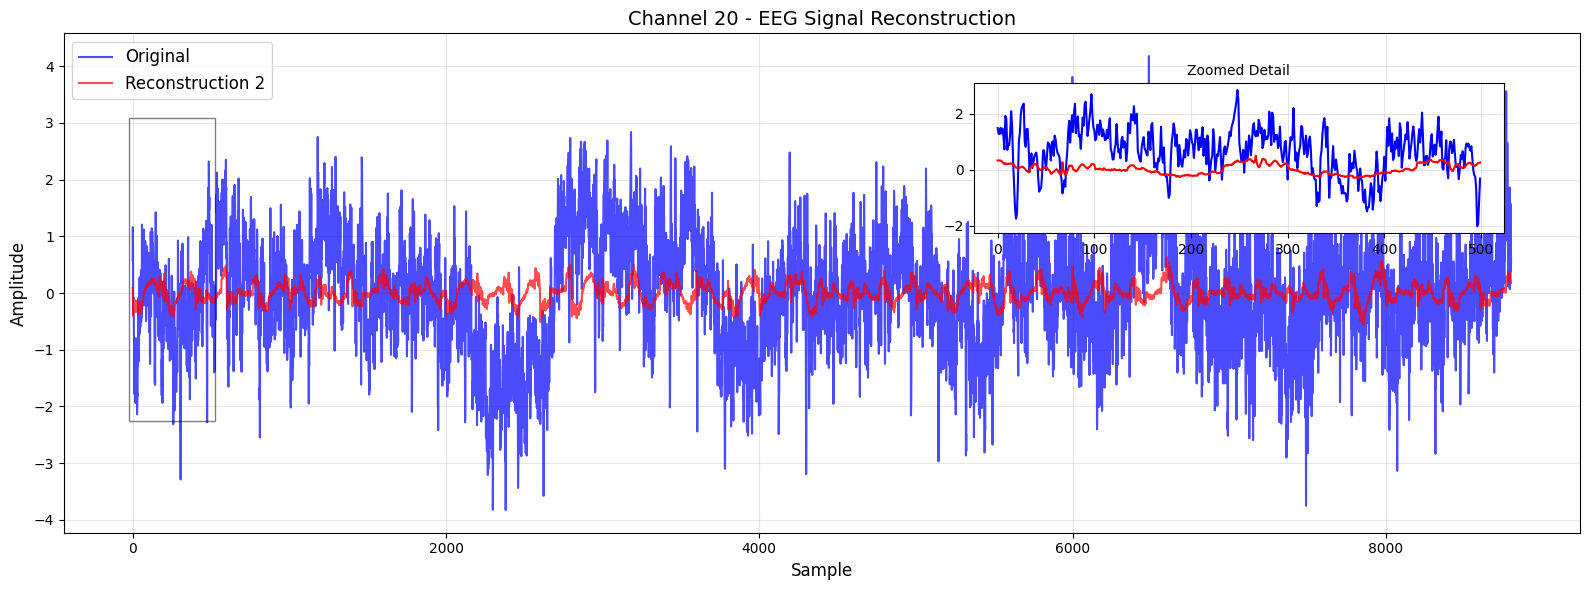

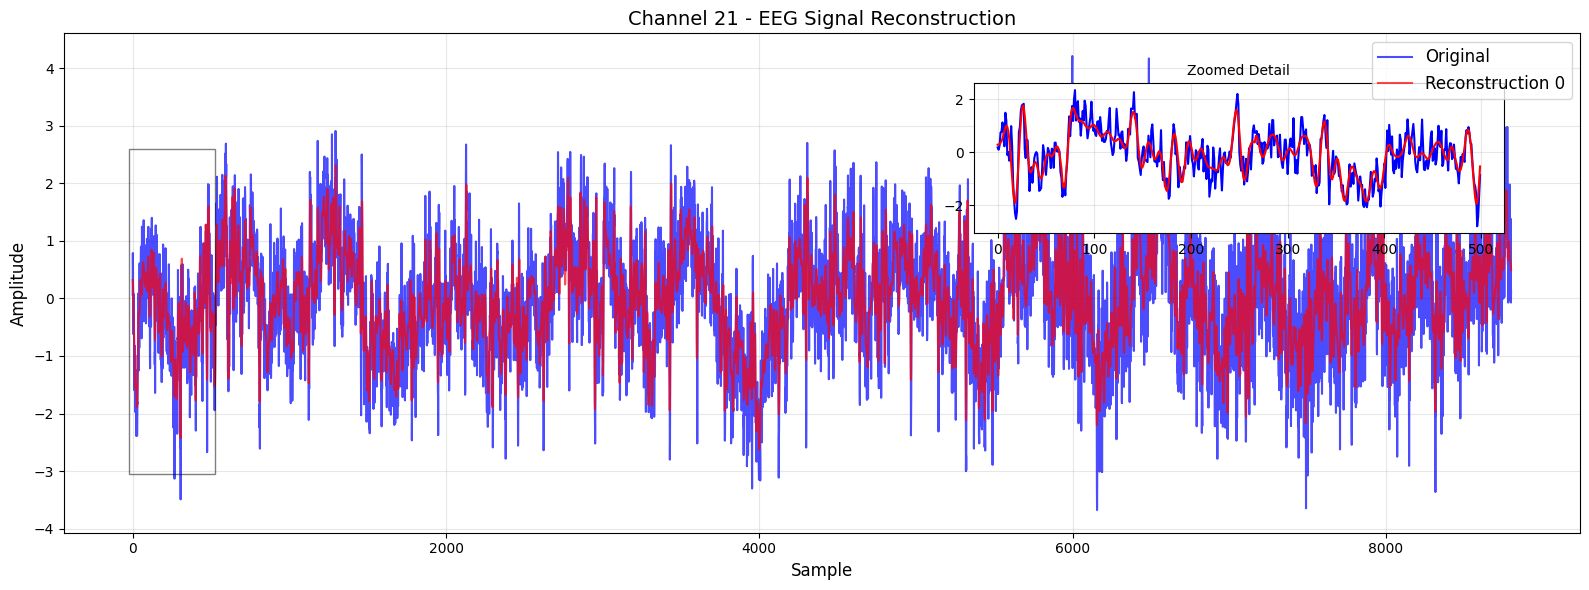

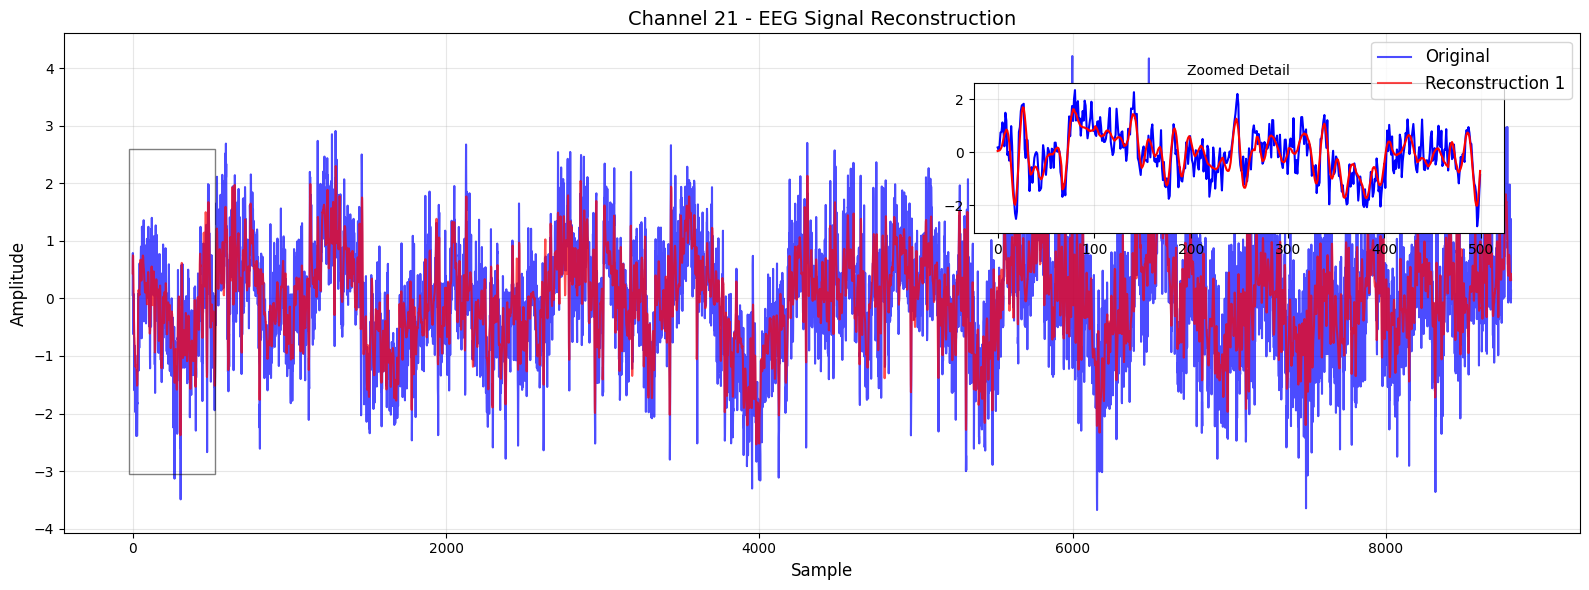

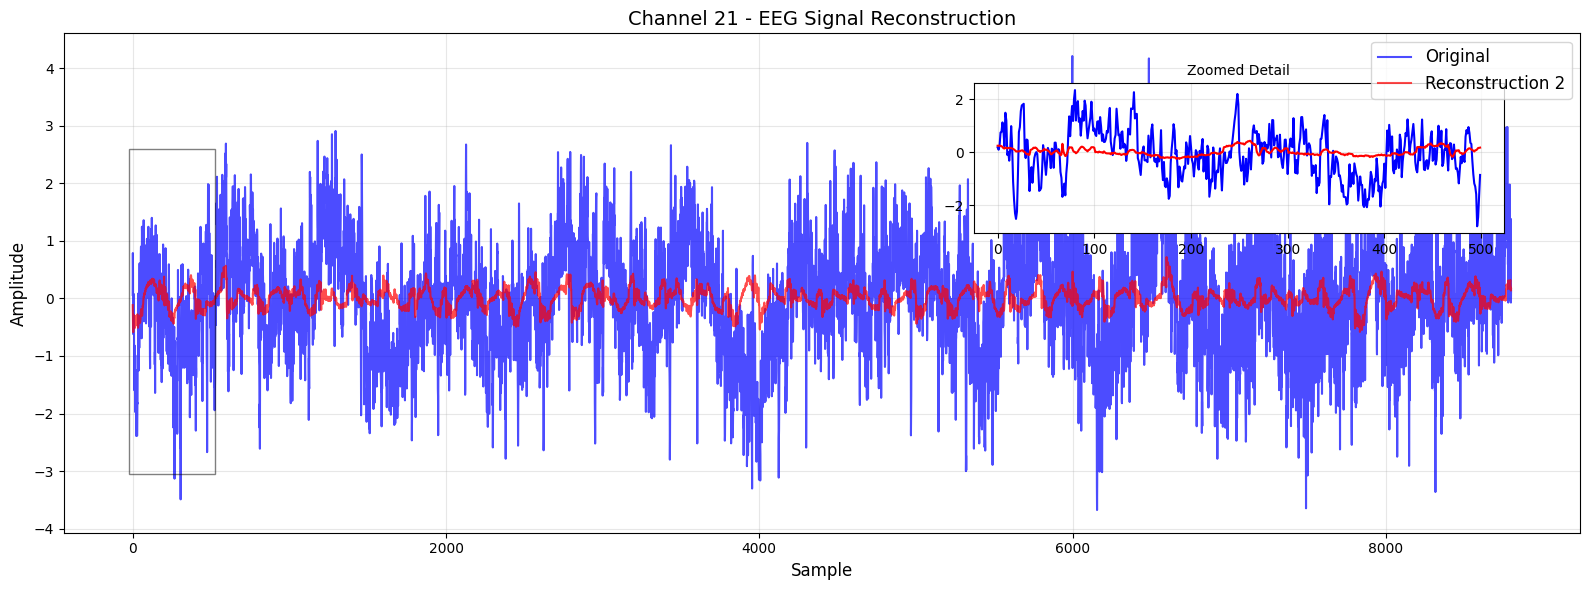

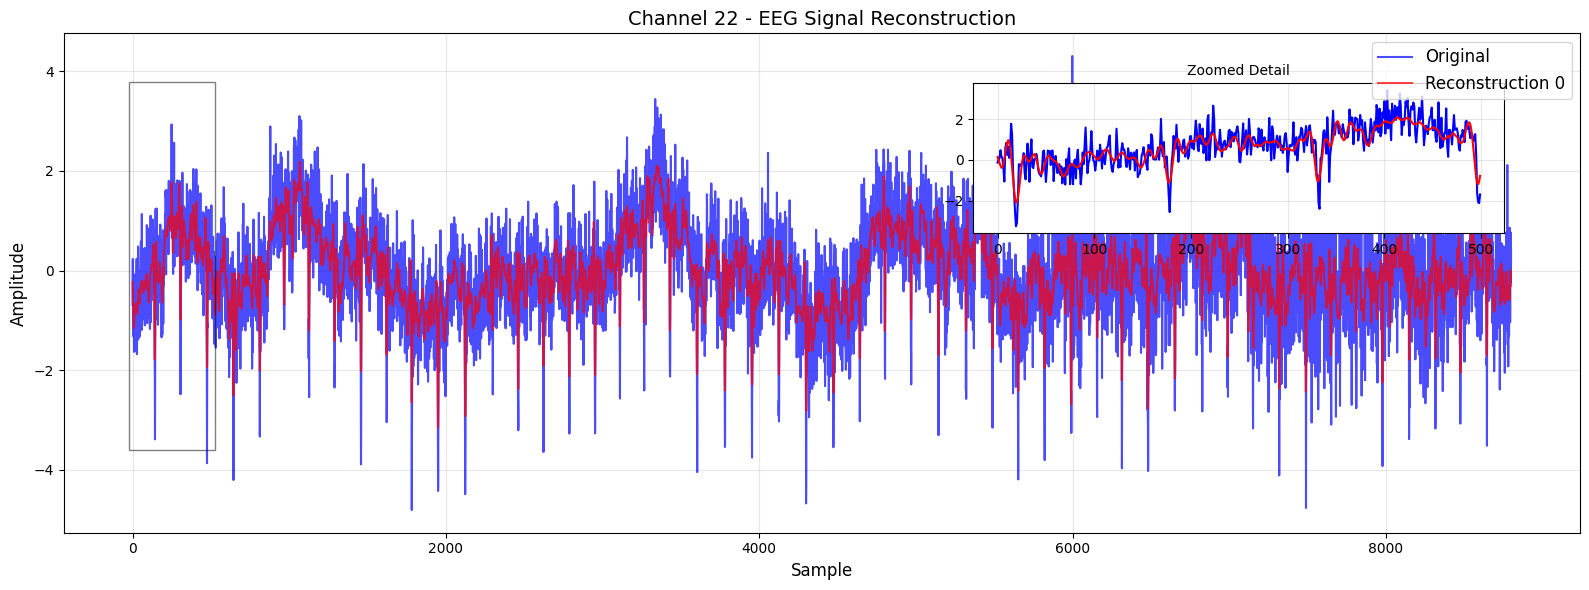

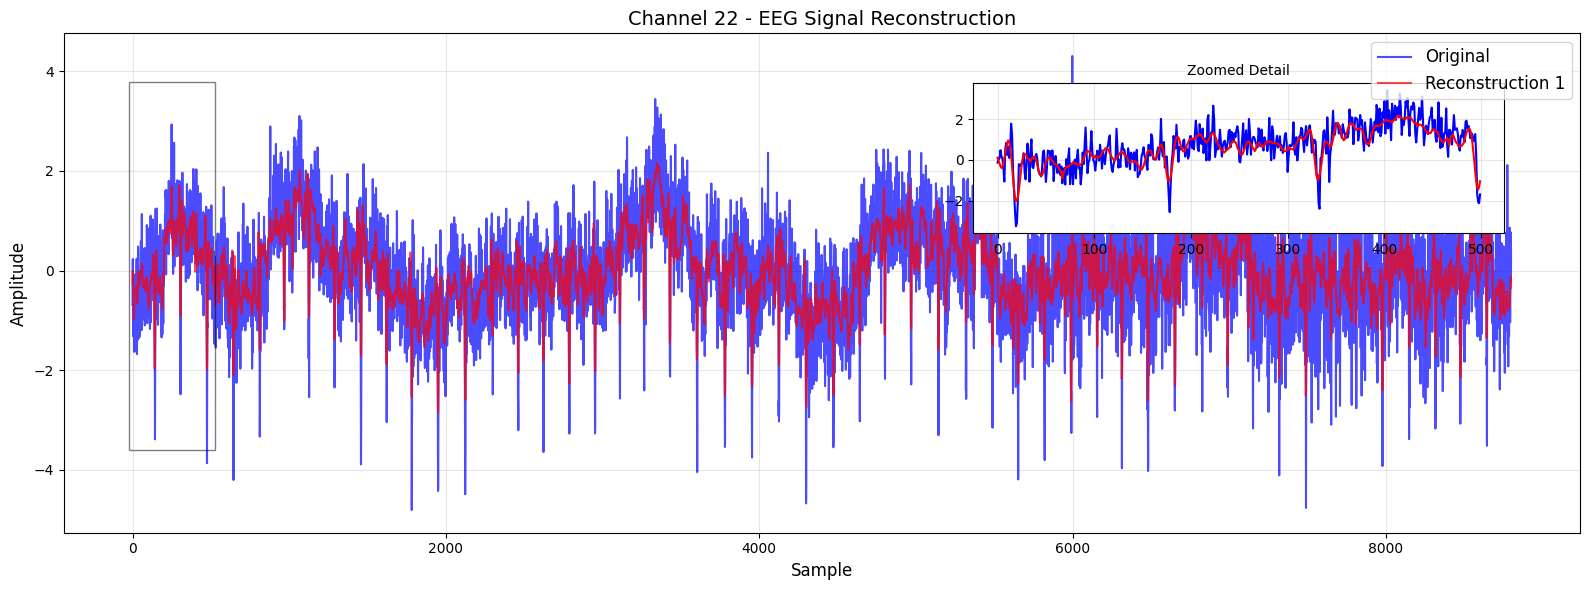

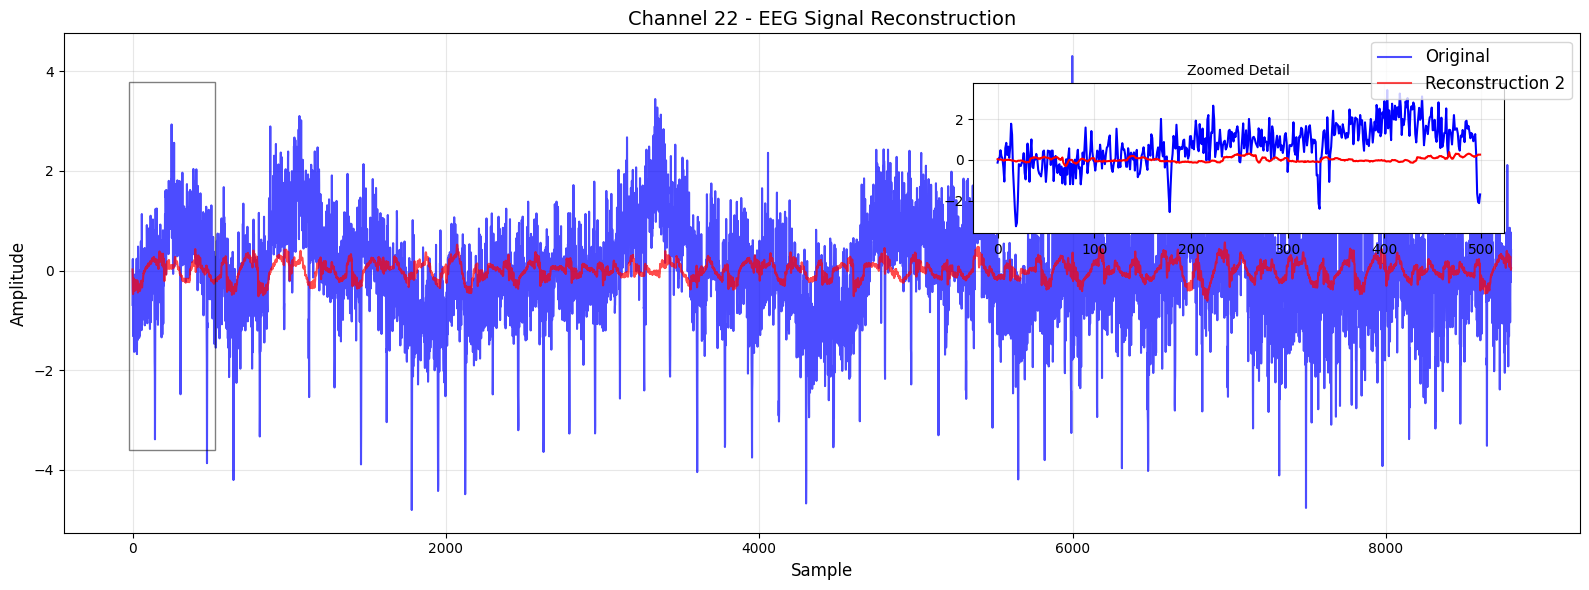

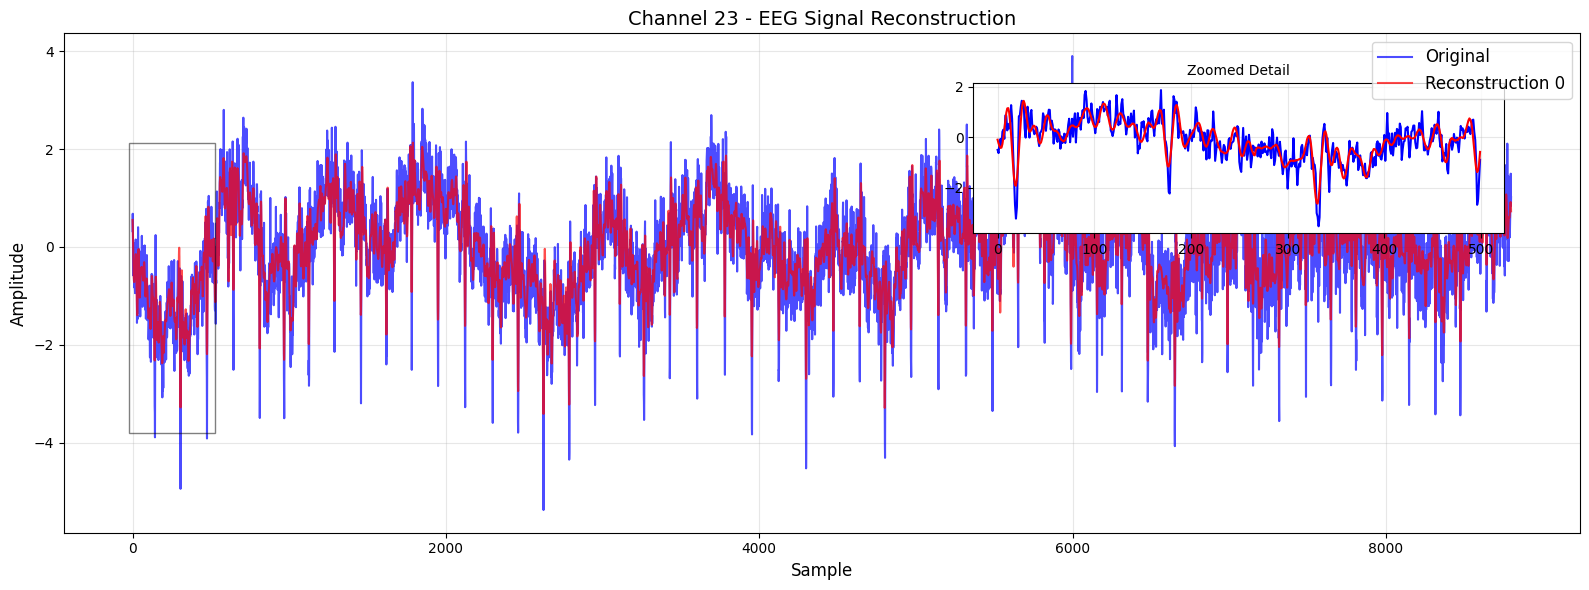

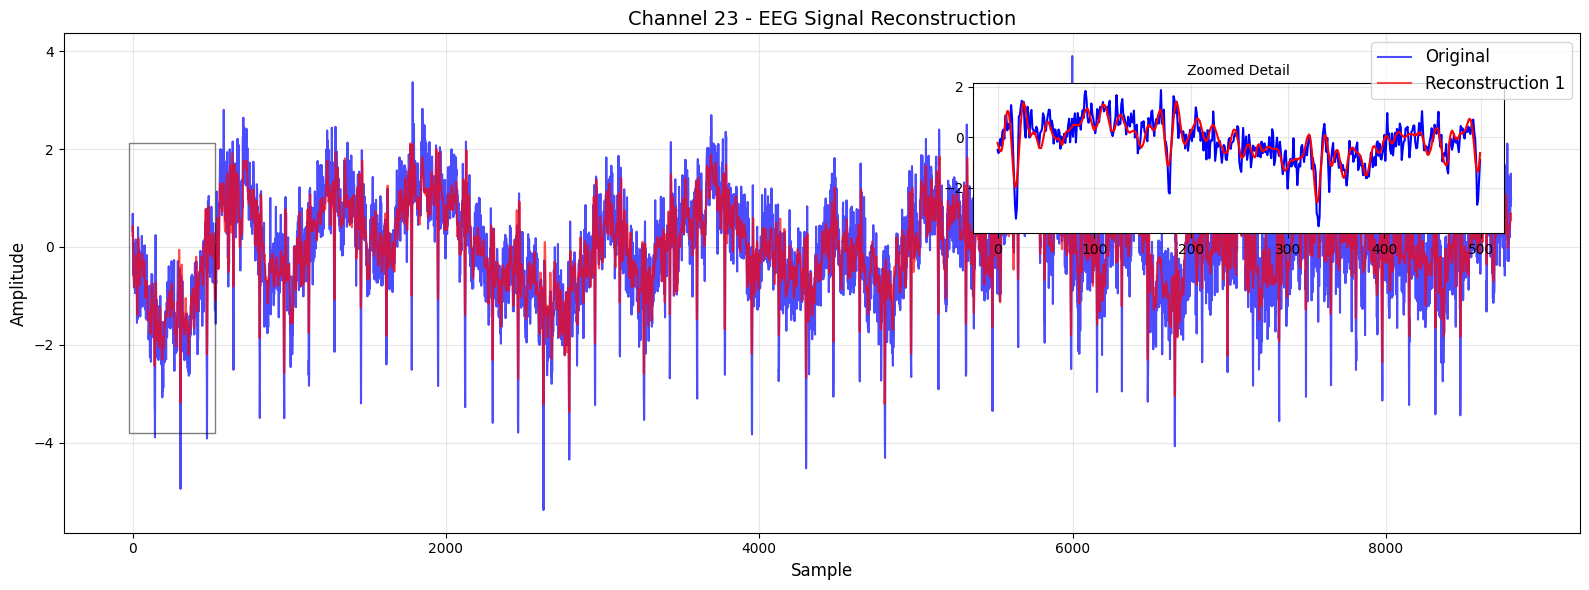

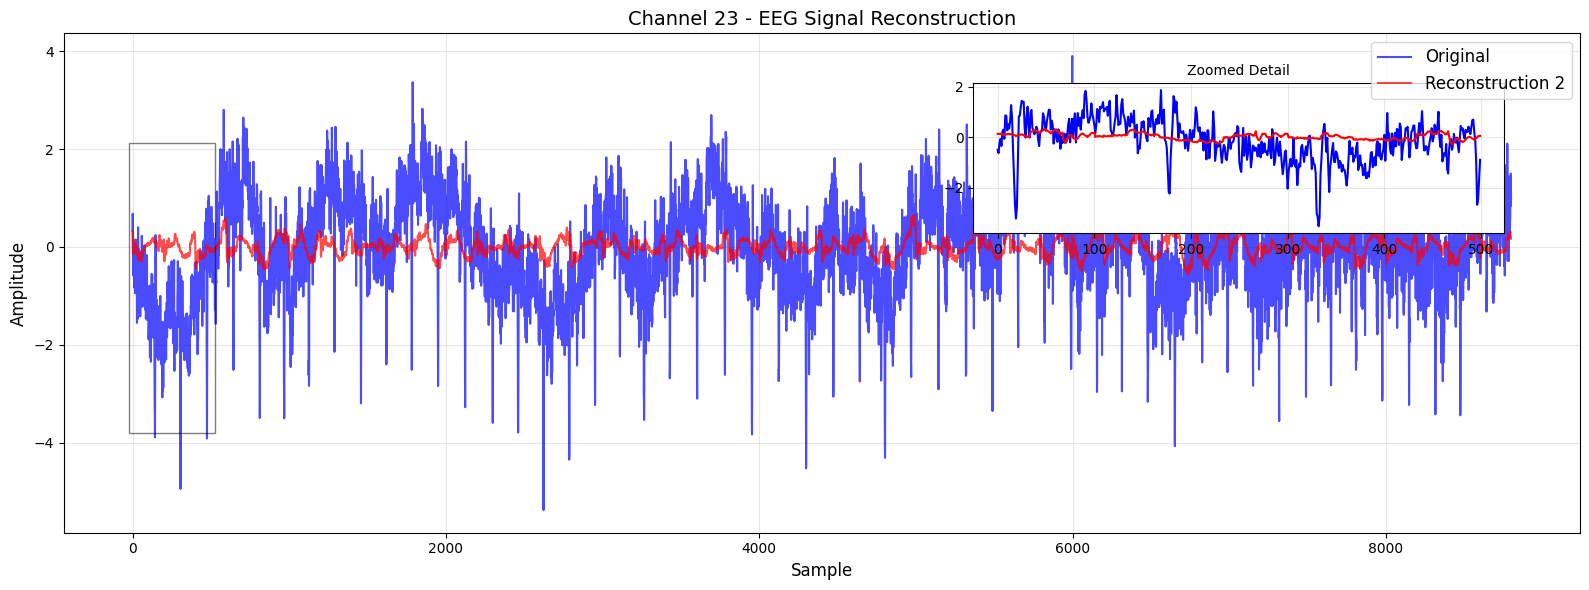

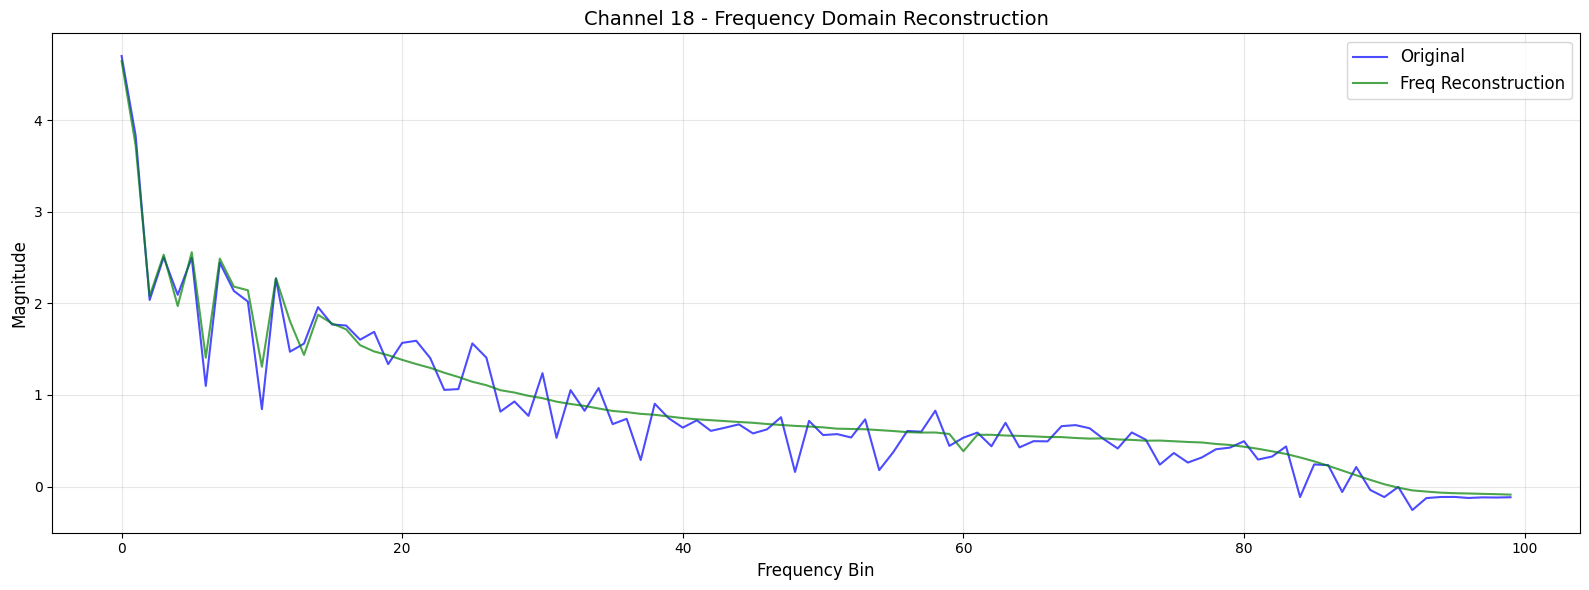

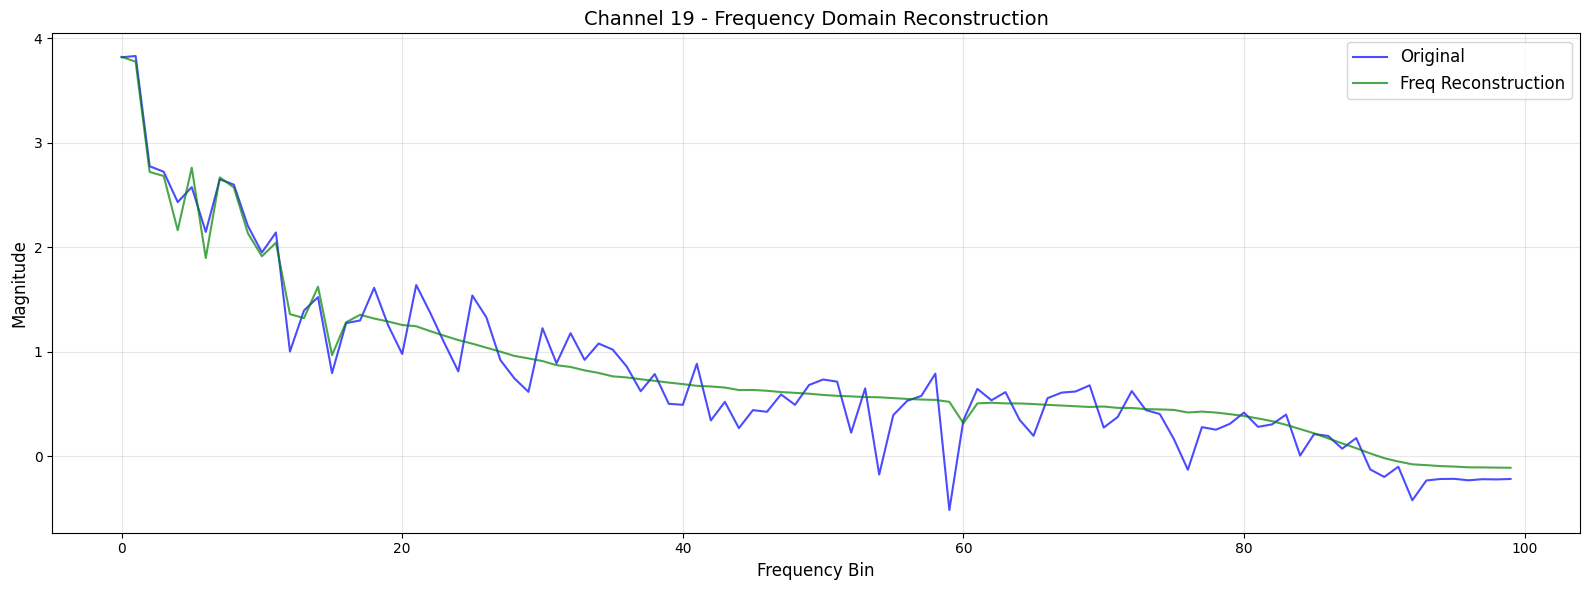

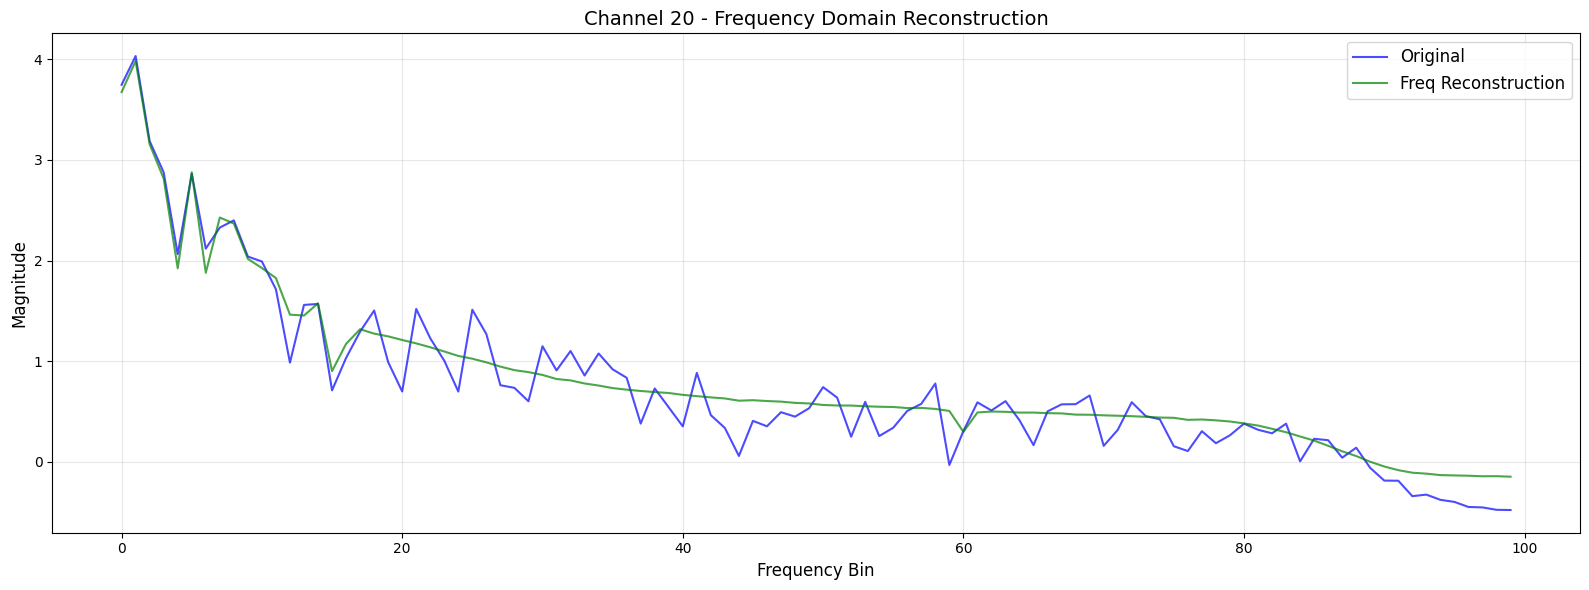

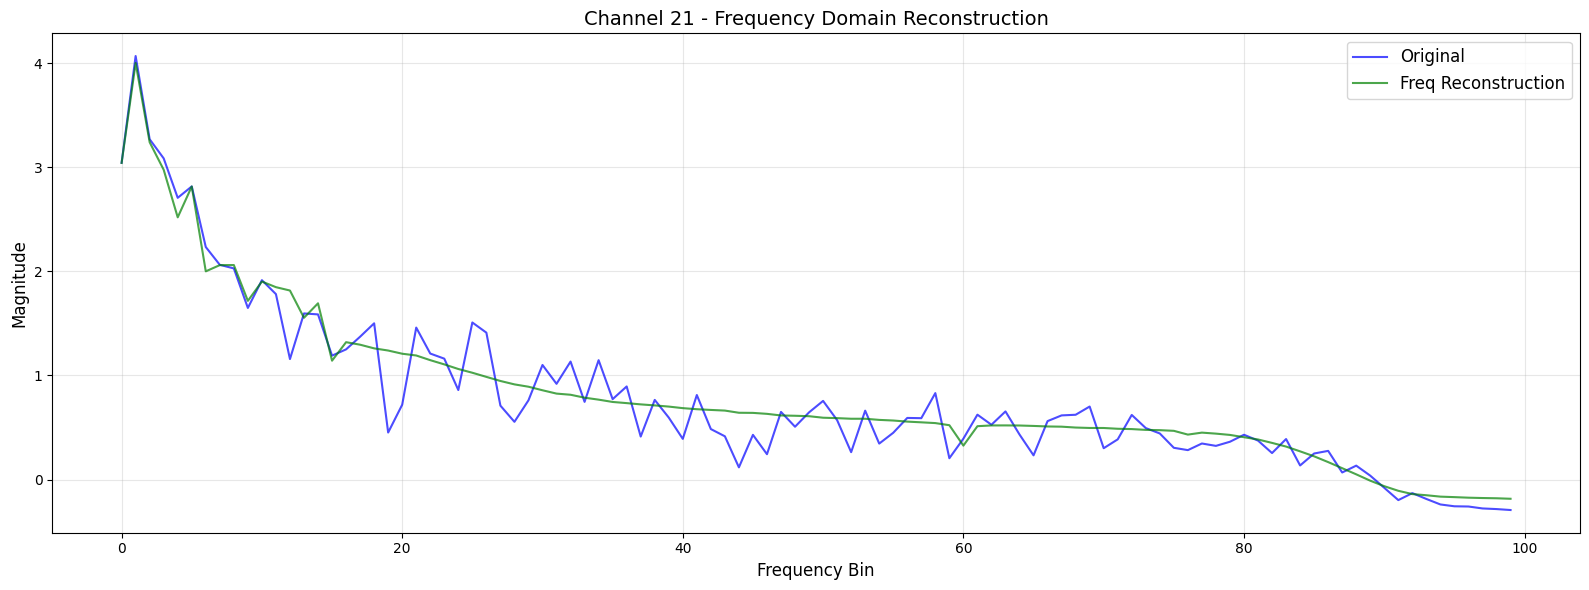

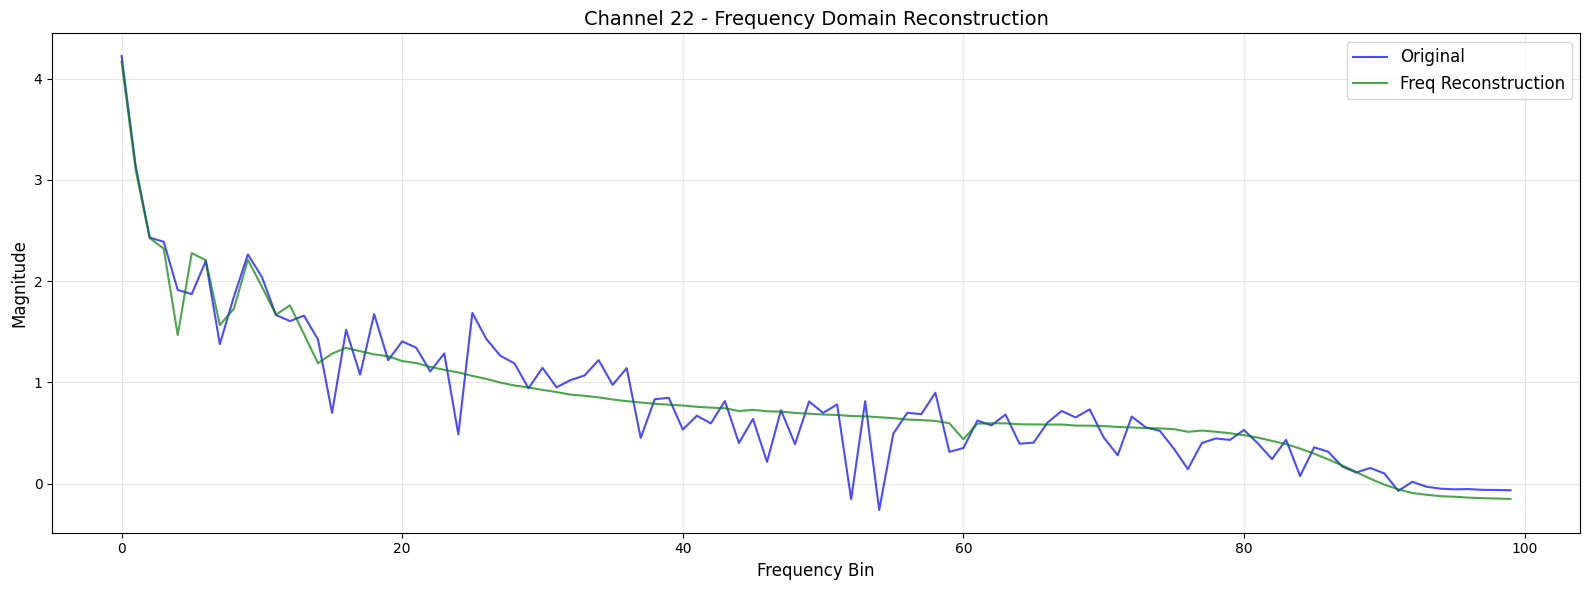

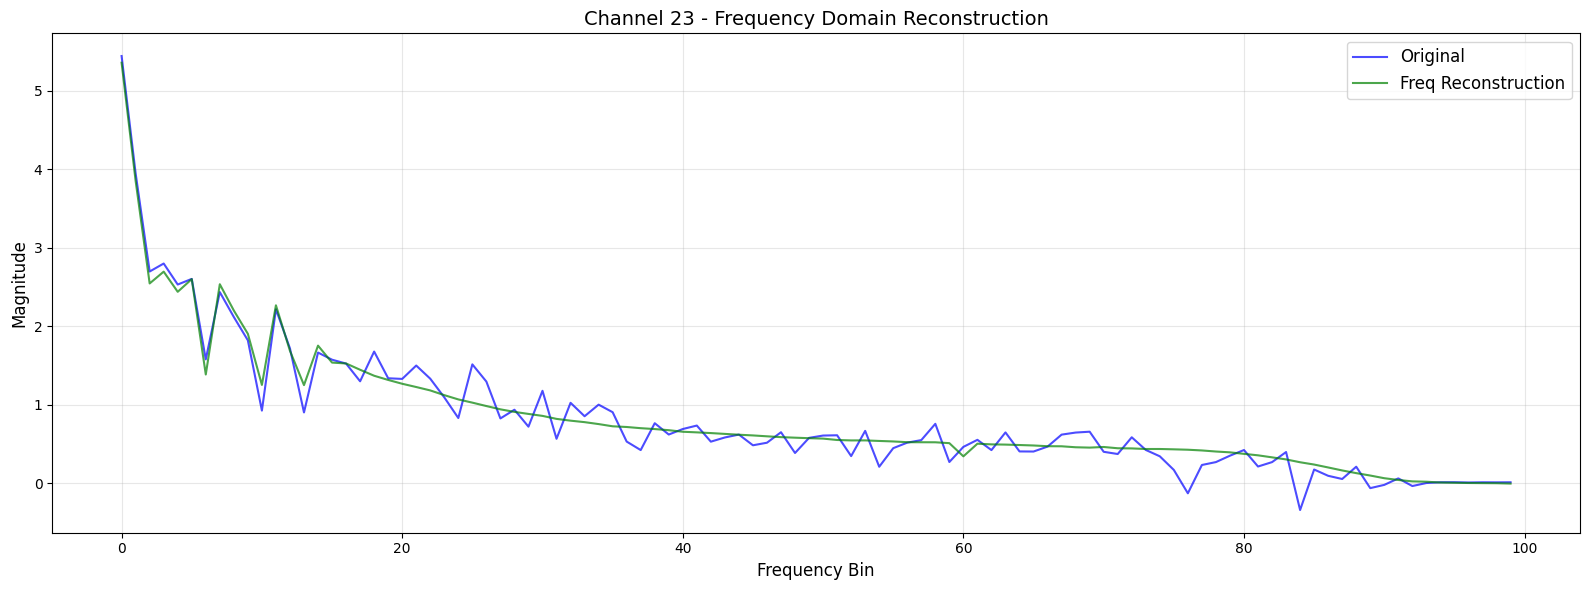

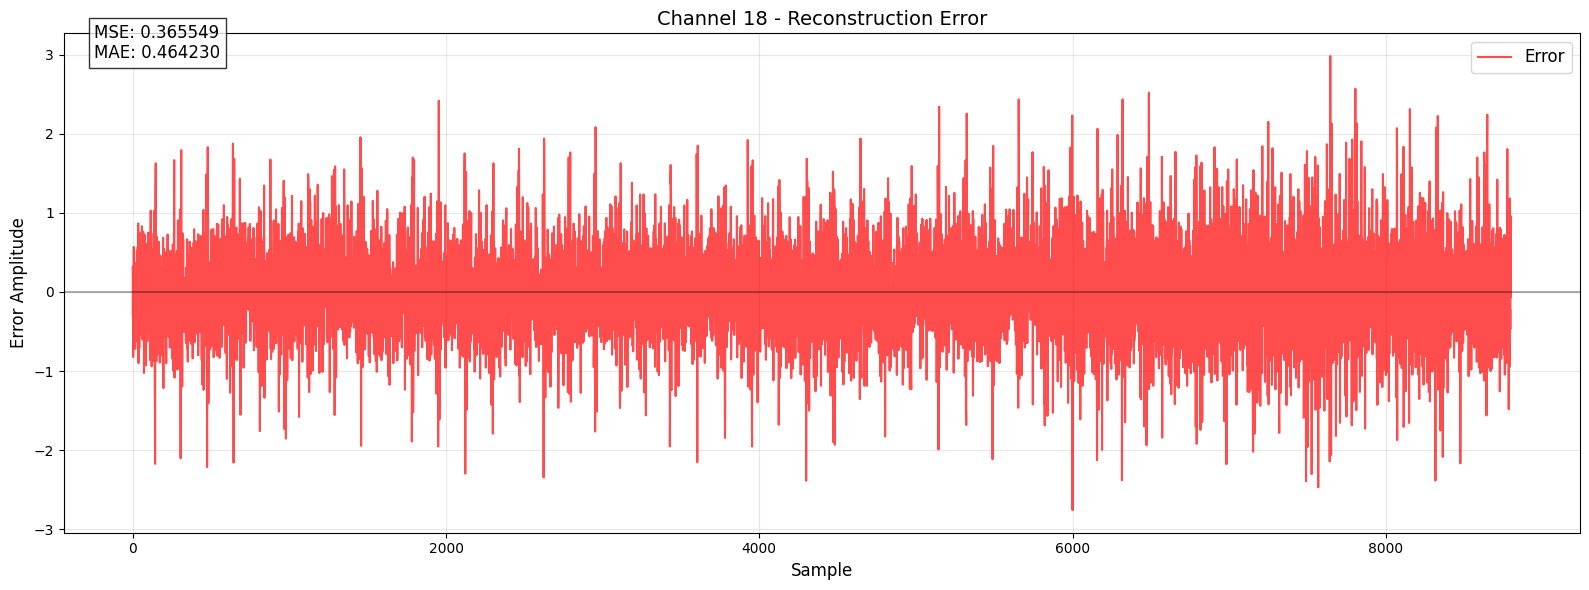

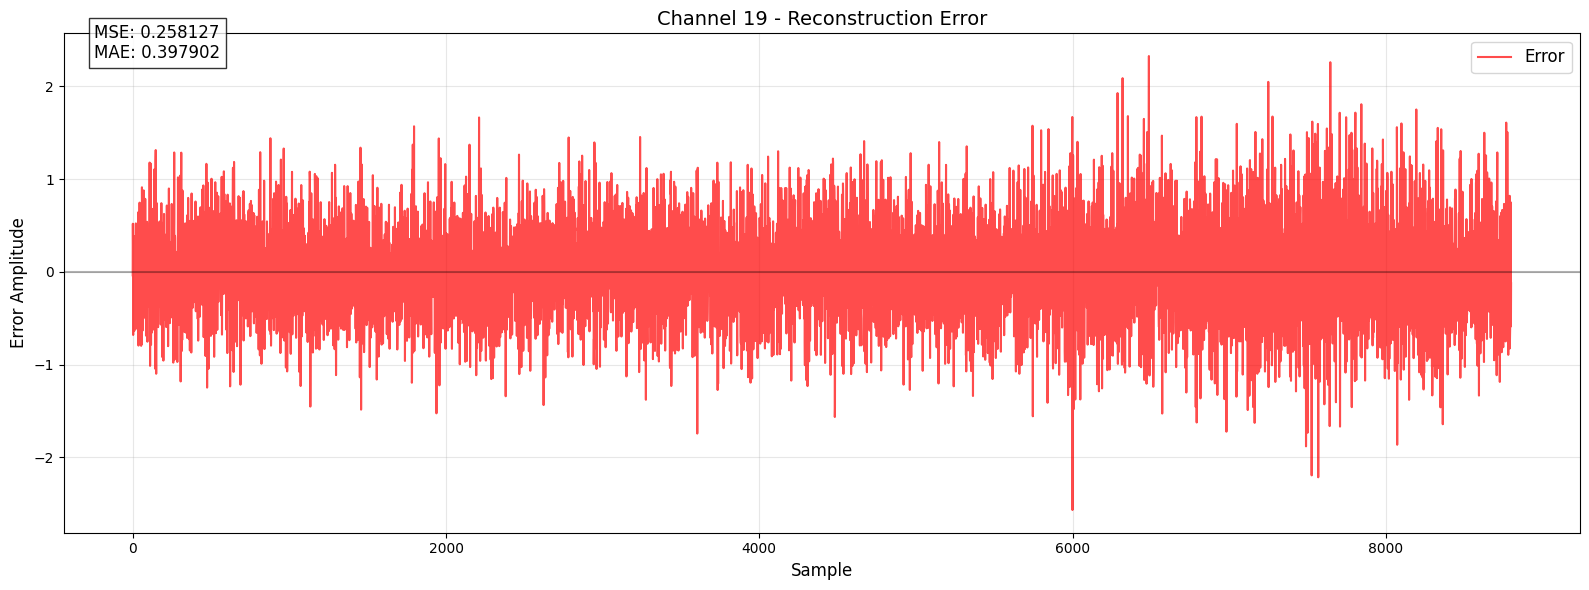

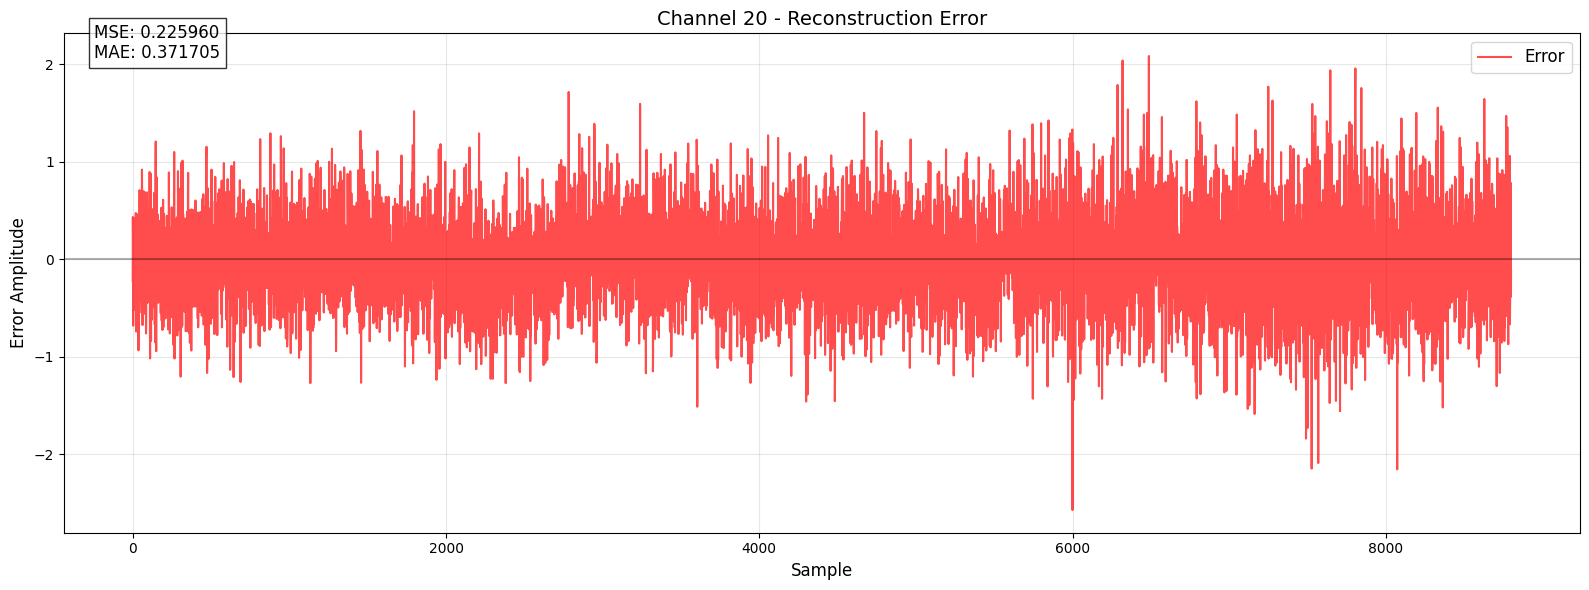

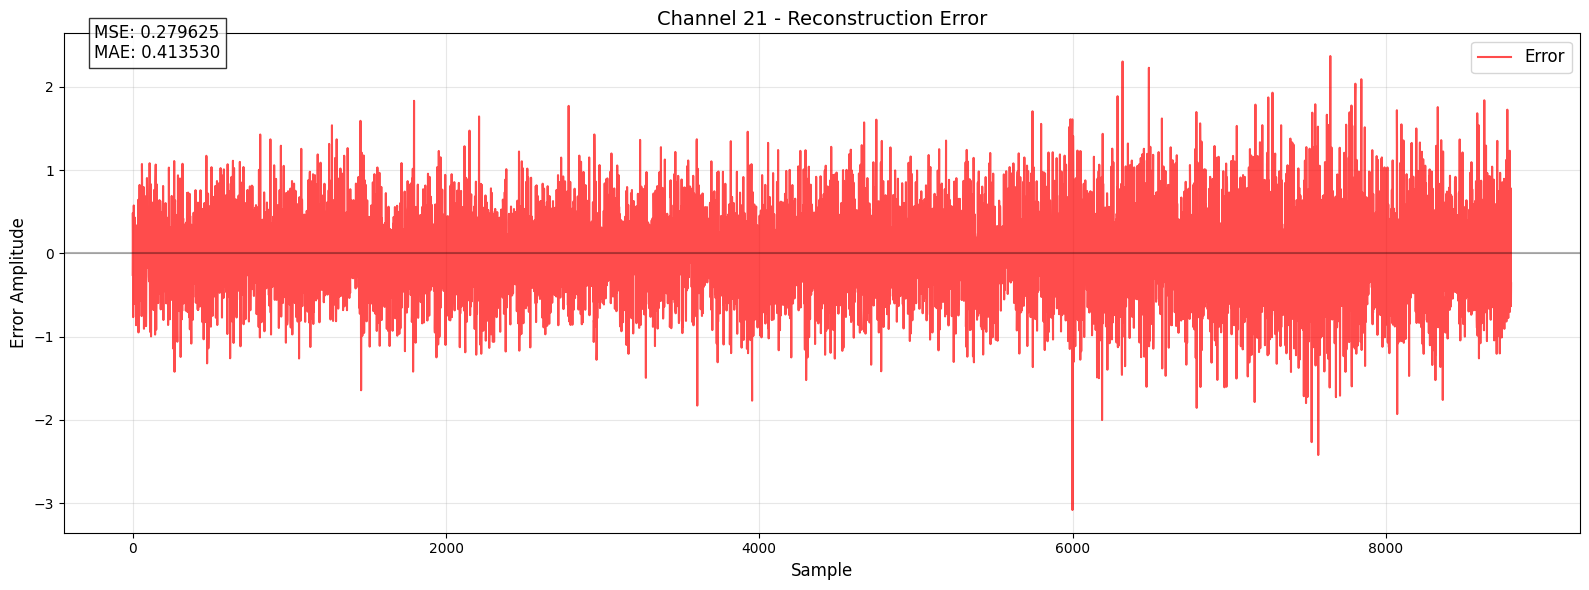

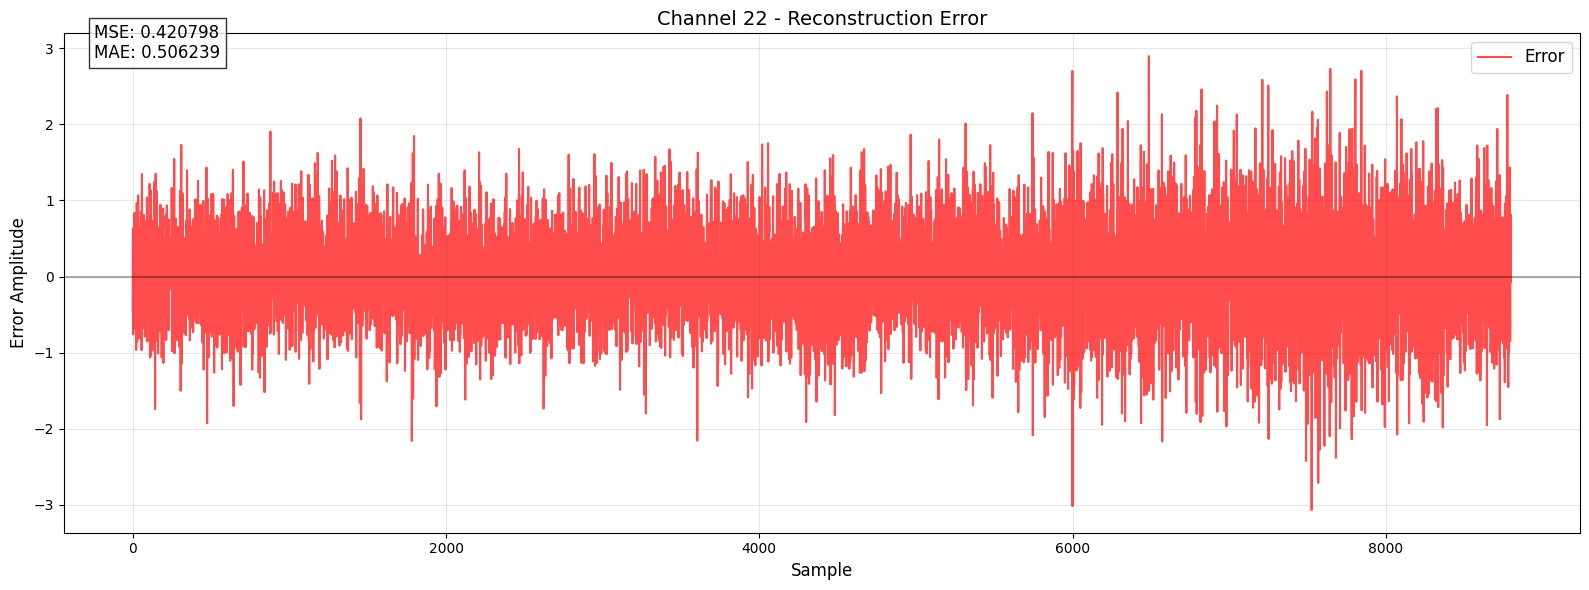

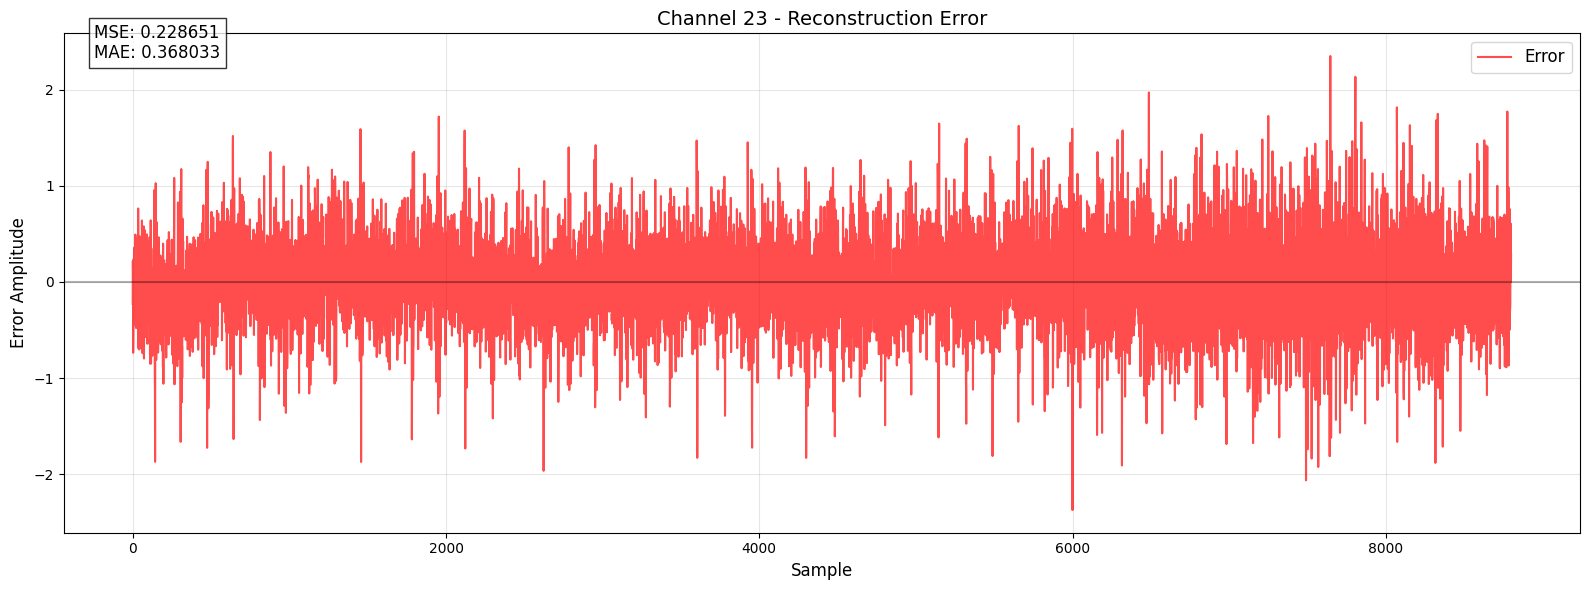

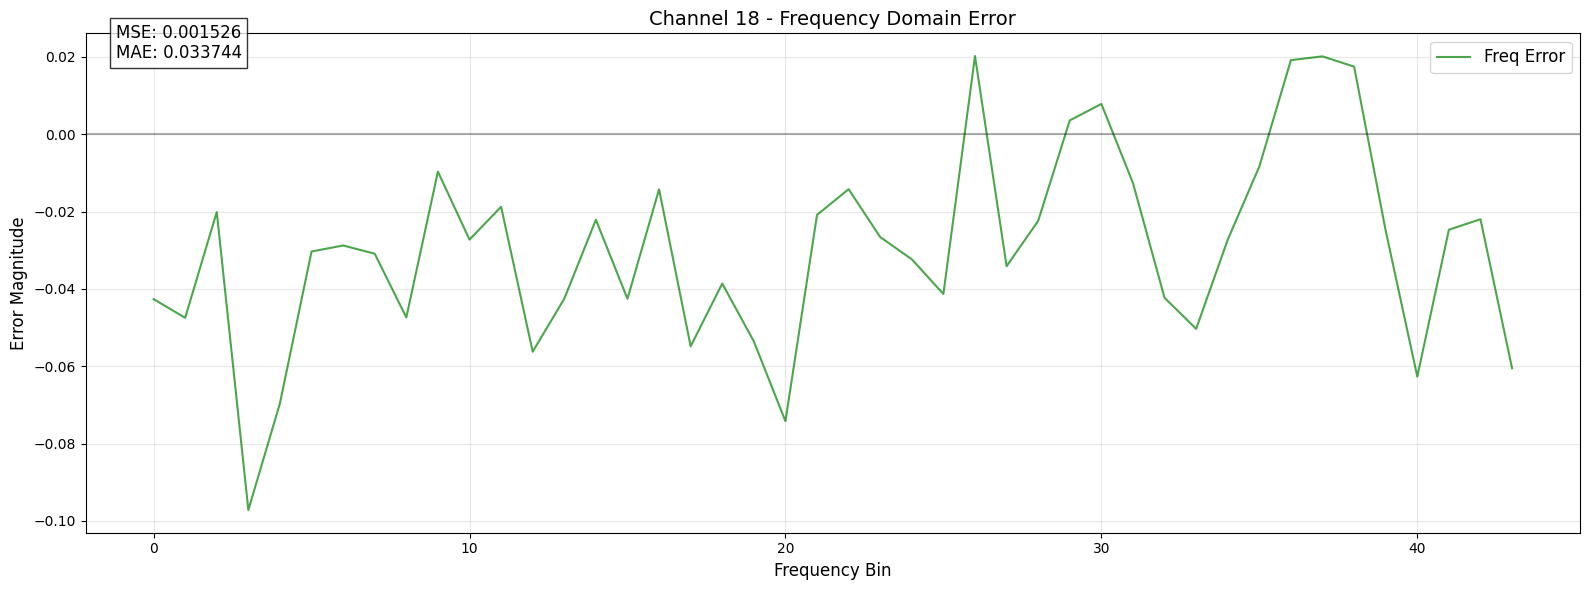

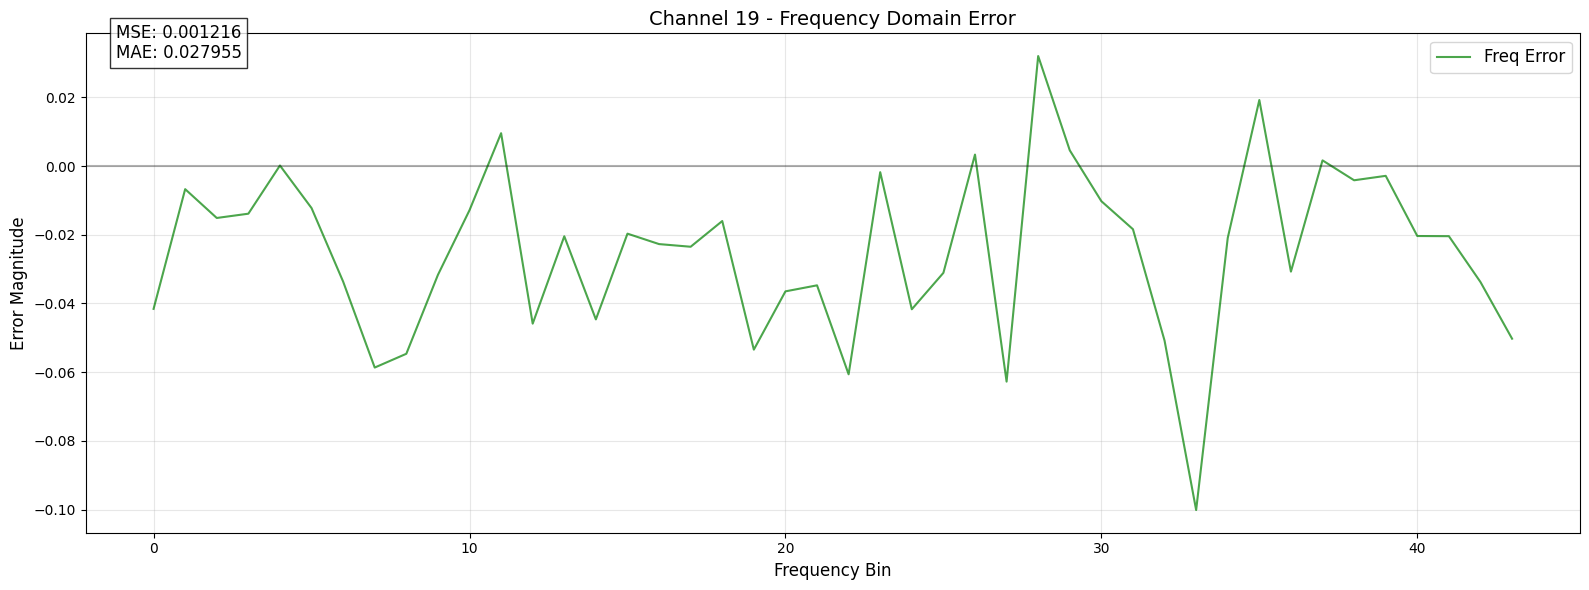

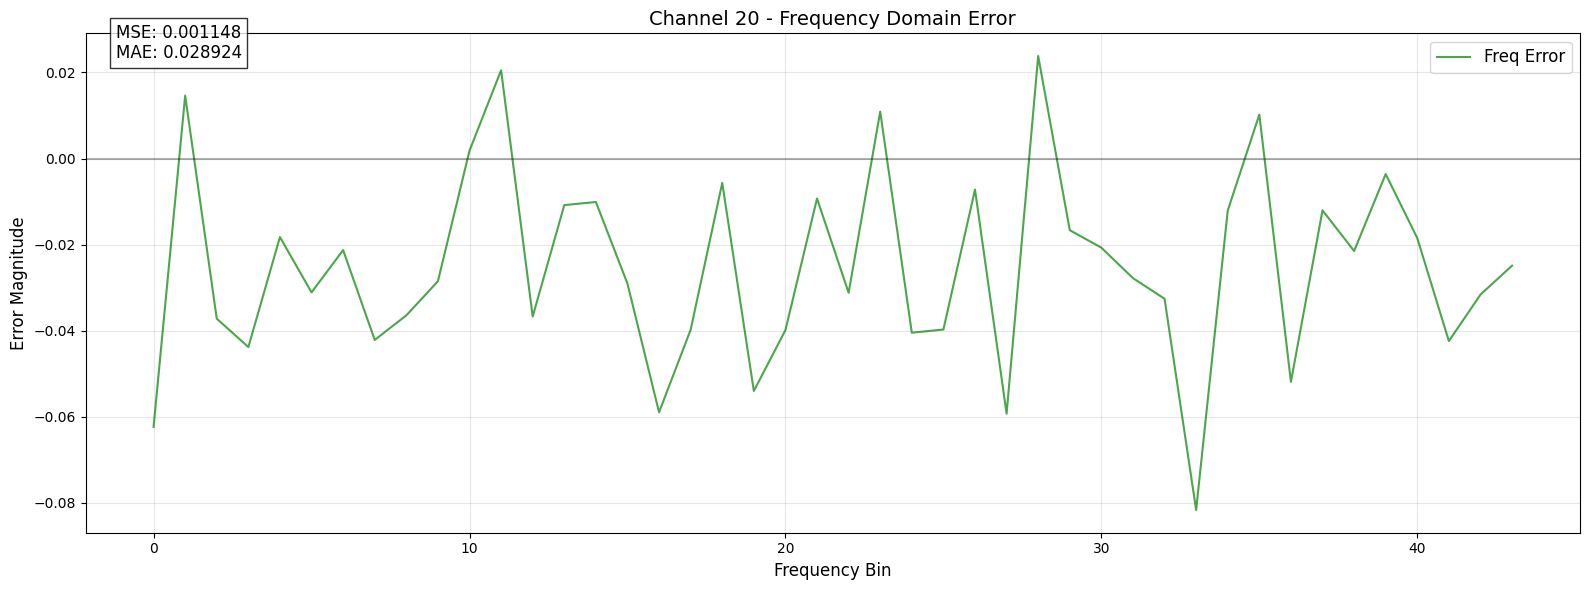

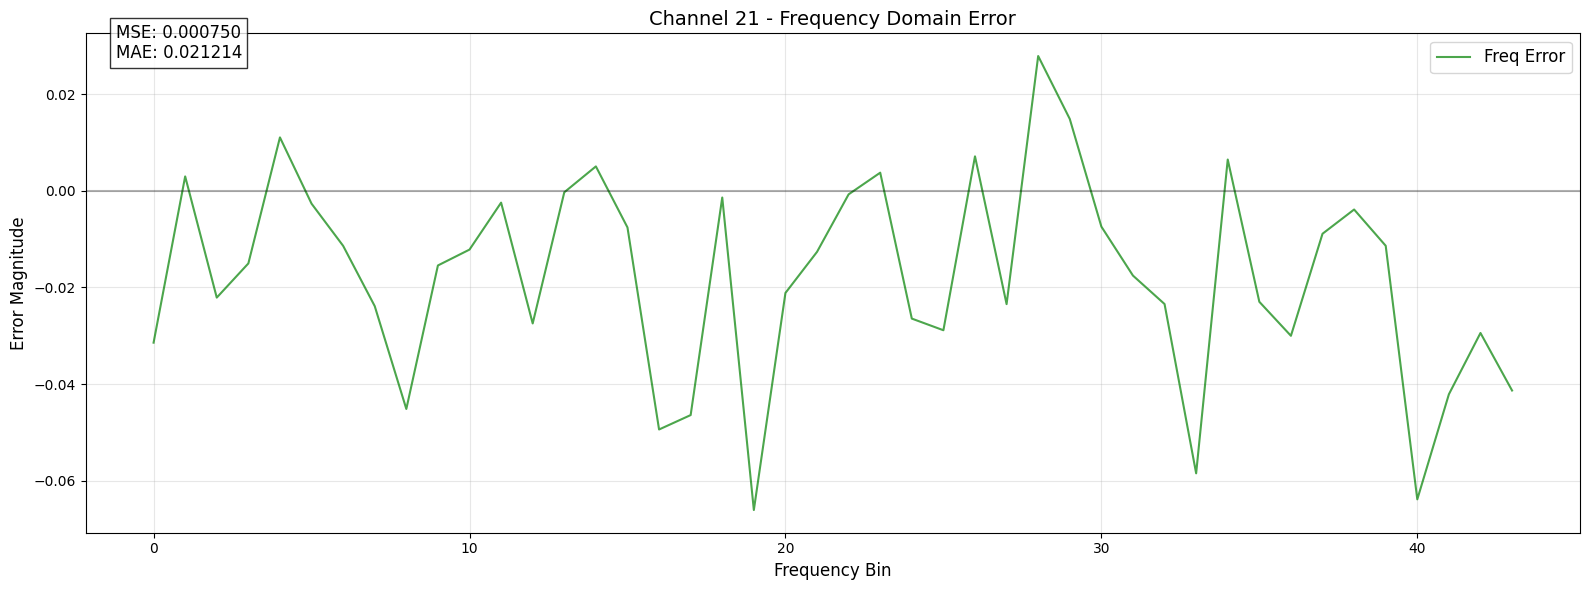

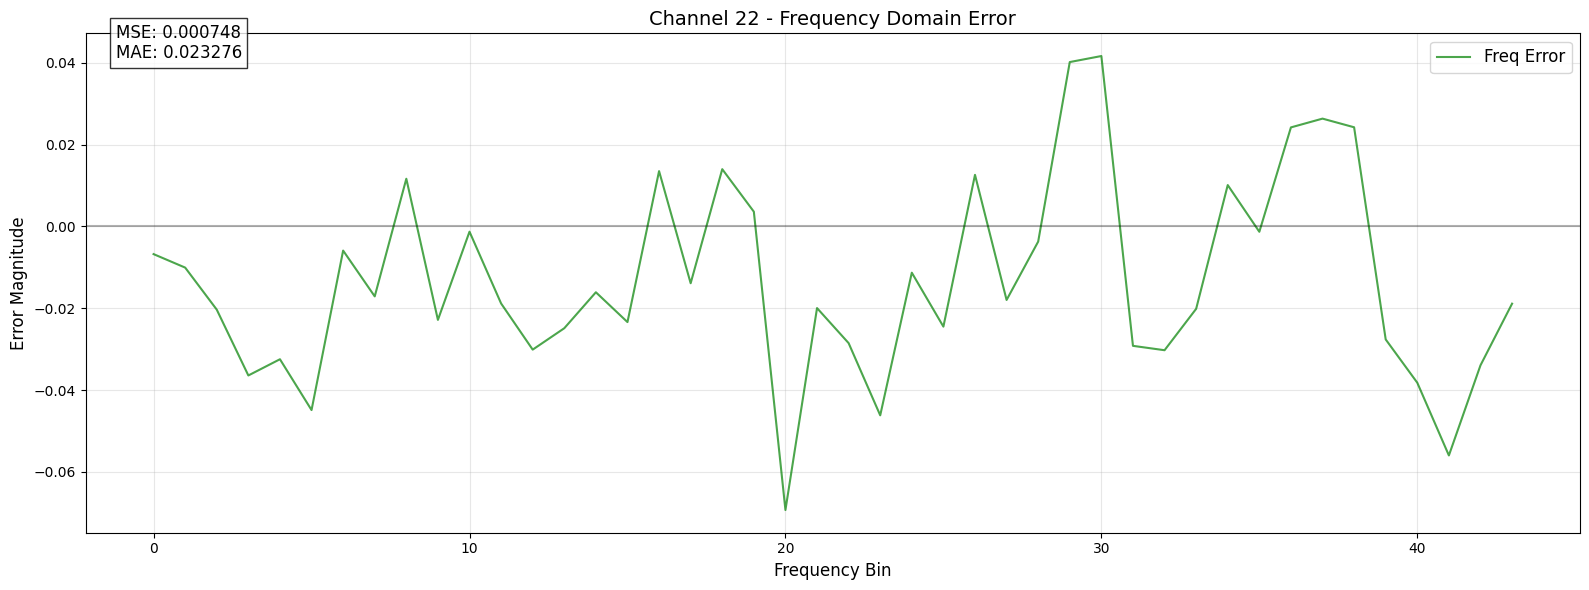

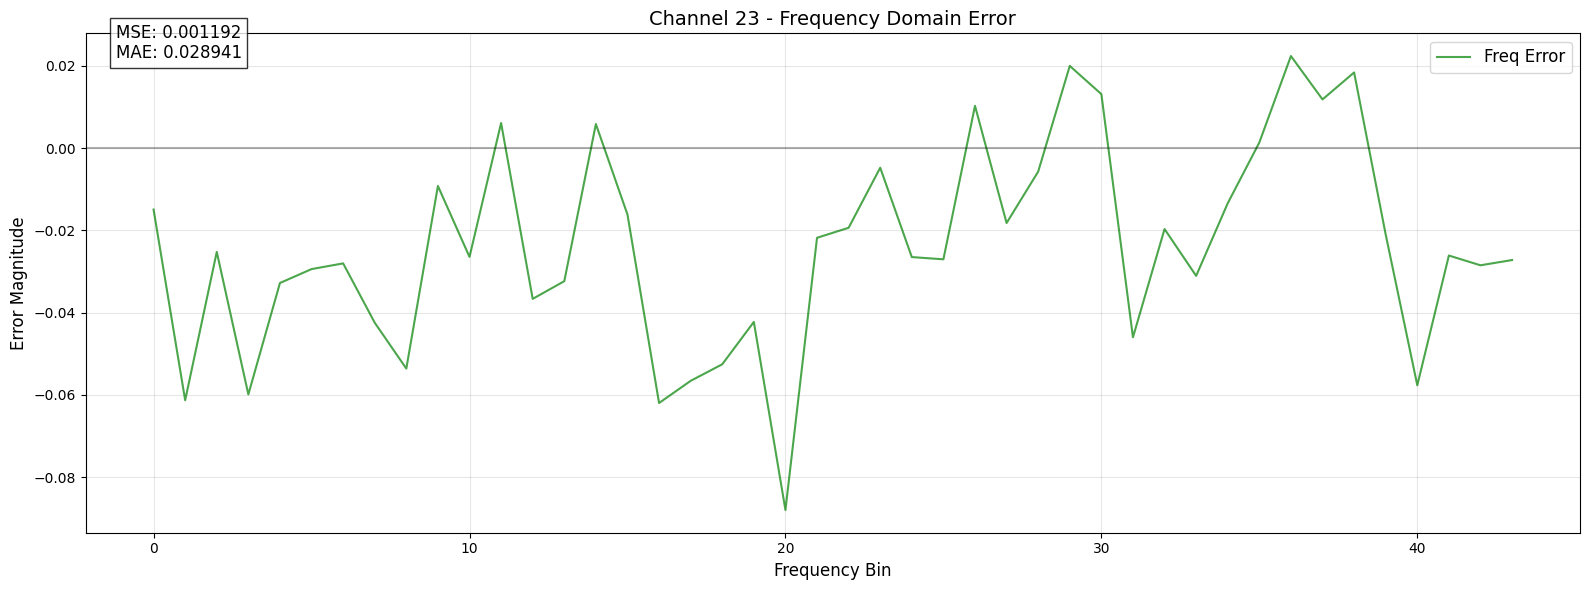

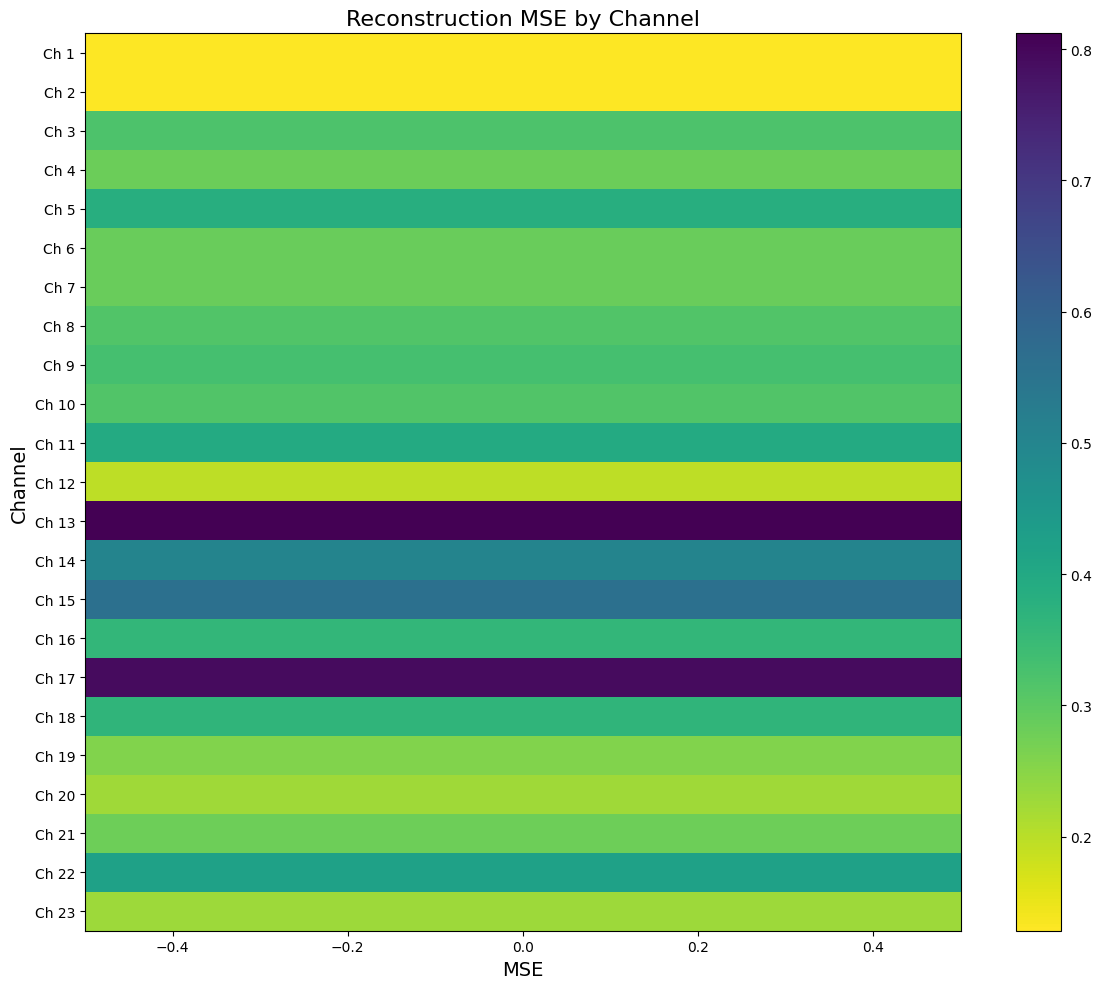


Evaluating reconstruction quality...


NameError: name 'metrics' is not defined

In [6]:
"""
EEG Reconstruction Visualization Script for NeuroLM VQ Model
"""

import torch
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
from pathlib import Path
from dataset import PickleLoader
from model.model_vq import VQ_Align
from model.model_neural_transformer import NTConfig

# Configuration
device = "cuda" if torch.cuda.is_available() else "mps"
num_channels = 23  # Number of EEG channels
def visualize_channel_reconstructions_matplotlib(X, X_freq, xrec_raw, xrec_freq, num_channels=23, channels_to_show=None, cutoff=None, additional_reconstructions=[]):
    """
    Visualize reconstructions for selected channels using Matplotlib
    
    Args:
        X: Input EEG data [batch, channels, time]
        X_freq: Input frequency domain data
        xrec_raw: Raw domain reconstruction
        xrec_freq: Frequency domain reconstruction
        num_channels: Total number of channels
        channels_to_show: List of channel indices to display (None = all)
        cutoff: Maximum number of samples to display
    """
    if channels_to_show is None:
        channels_to_show = range(min(17, num_channels), num_channels)  # Show first 6 channels by default
    if cutoff is None:
        cutoff = 1024*200
    cutoff = 200 * (cutoff//200)
    
    # Convert to numpy
    X_np = X[0].cpu().numpy()  # First batch
    X_freq_np = X_freq[0].cpu().numpy()  # First batch
    xrec_raw_np = xrec_raw[0].cpu().numpy()
    xrec_freq_np = xrec_freq[0].cpu().numpy()
    
    # Squeeze dimensions if needed
    X_np = X_np.squeeze()
    stop = X_np.shape[0] - X_np.shape[0] % num_channels
    recons = [xrec_raw_np]+[m[0].cpu().numpy() for m in additional_reconstructions]
    # Plot time domain reconstructions
    for ch_idx in channels_to_show:
        for ii, r in enumerate(recons):
            # Extract channel data
            original_signal = X_np[ch_idx:stop:num_channels, :].flatten()[:cutoff]
            raw_recon = r[ch_idx:stop:num_channels, :].flatten()[:cutoff]

            # Normalize signals for better comparison
            # original_signal = model.VQ.std_norm(torch.tensor(original_signal)).detatch().numpy()
            # raw_recon = raw_recon/((raw_recon**2).sum())**0.5
            
            plot_time_signals(
                [original_signal, raw_recon],
                labels=['Original', f'Reconstruction {ii}'],
                colors=['b', 'r'],
                title=f'Channel {ch_idx+1} - EEG Signal Reconstruction',
                xlabel='Sample',
                ylabel='Amplitude',
                zoom_in=True
            )
    
    # Plot frequency domain reconstructions
    for ch_idx in channels_to_show:
        # Extract channel data for frequency domain
        original_freq = X_freq_np[ch_idx:stop:num_channels, :].flatten()[:100]
        freq_recon = xrec_freq_np[ch_idx:stop:num_channels, :].flatten()[:100]
        
        plot_frequency_signals(
            [original_freq, freq_recon],
            labels=['Original', 'Freq Reconstruction'],
            colors=['b', 'g'],
            title=f'Channel {ch_idx+1} - Frequency Domain Reconstruction',
            xlabel='Frequency Bin',
            ylabel='Magnitude',
            zoom_in=False
        )
    
    # Create error visualization
    for ch_idx in channels_to_show:
        # Extract channel data
        original_signal = X_np[ch_idx:stop:num_channels, :].flatten()[:cutoff] 
        raw_recon = xrec_raw_np[ch_idx:stop:num_channels, :].flatten()[:cutoff]
        
        # Normalize signals
        # original_signal = model.VQ.std_norm(torch.tensor(original_signal)).detatch().numpy()
        # raw_recon = raw_recon/((raw_recon**2).sum())**0.5
        
        # Compute error
        raw_error = original_signal - raw_recon
        
        plot_time_signals(
            [raw_error],
            labels=['Error'],
            colors=['r'],
            title=f'Channel {ch_idx+1} - Reconstruction Error',
            xlabel='Sample',
            ylabel='Error Amplitude',
            zoom_in=False,
            show_stats=True,
            stats={'MSE': np.mean(raw_error**2), 'MAE': np.mean(np.abs(raw_error))}
        )
    
    # Create error visualization for frequency domain
    for ch_idx in channels_to_show:
        # Extract channel data for frequency domain
        original_freq = X_freq_np[ch_idx:stop:num_channels, :100].flatten()
        freq_recon = xrec_freq_np[ch_idx:stop:num_channels, :100].flatten()
        
        # Compute error
        freq_error = (original_freq - freq_recon).reshape(-1, 100).mean(axis=-1)
        
        plot_time_signals(
            [freq_error],
            labels=['Freq Error'],
            colors=['g'],
            title=f'Channel {ch_idx+1} - Frequency Domain Error',
            xlabel='Frequency Bin',
            ylabel='Error Magnitude',
            zoom_in=False,
            show_stats=True,
            stats={'MSE': np.mean(freq_error**2), 'MAE': np.mean(np.abs(freq_error))}
        )

    # Create heatmap showing reconstruction quality across all channels
    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    
    # Prepare data for heatmap
    all_channels_raw_error = []
    
    for ch_idx in range(num_channels):
        # Extract channel data
        original_signal = X_np[ch_idx:stop:num_channels, :].flatten()[:cutoff]
        raw_recon = xrec_raw_np[ch_idx:stop:num_channels, :].flatten()[:cutoff]
        
        # Normalize signals
        # original_signal = model.VQ.std_norm(torch.tensor(original_signal)).detatch().numpy()
        # raw_recon = raw_recon/((raw_recon**2).sum())**0.5
        
        # Compute mean squared error
        raw_mse = np.mean((original_signal - raw_recon)**2)
        all_channels_raw_error.append(raw_mse)
    
    # Create heatmap
    im = ax.imshow(np.array(all_channels_raw_error).reshape(-1, 1), aspect='auto', cmap='viridis_r')
    ax.set_title('Reconstruction MSE by Channel', fontsize=16)
    ax.set_xlabel('MSE', fontsize=14)
    ax.set_ylabel('Channel', fontsize=14)
    ax.set_yticks(range(num_channels))
    ax.set_yticklabels([f'Ch {i+1}' for i in range(num_channels)])
    plt.colorbar(im, ax=ax)
    
    plt.tight_layout()
    plt.show()

def plot_time_signals(signals, labels=None, colors=None, title='Signal Plot', xlabel='Time', 
                     ylabel='Amplitude', figsize=(16, 6), zoom_in=True, show_stats=False, stats=None):
    """
    General function to plot time domain signals
    
    Args:
        signals: List of signal arrays to plot
        labels: List of labels for each signal
        colors: List of colors for each signal
        title: Plot title
        xlabel: X-axis label
        ylabel: Y-axis label
        figsize: Figure size as tuple (width, height)
        zoom_in: Whether to add a zoomed-in inset
        show_stats: Whether to show statistics
        stats: Dictionary of statistics to display
    """
    if labels is None:
        labels = [f'Signal {i+1}' for i in range(len(signals))]
    
    if colors is None:
        colors = ['b', 'r', 'g', 'c', 'm', 'y', 'k'] * (len(signals) // 7 + 1)
        colors = colors[:len(signals)]
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    for signal, label, color in zip(signals, labels, colors):
        ax.plot(signal, f'{color}-', label=label, alpha=0.7, linewidth=1.5)
    
    ax.set_title(title, fontsize=14)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.legend(fontsize=12)
    ax.grid(True, alpha=0.3)
    
    if show_stats and stats:
        stats_text = '\n'.join([f'{key}: {value:.6f}' for key, value in stats.items()])
        ax.text(0.02, 0.95, stats_text, 
                transform=ax.transAxes, fontsize=12,
                bbox=dict(facecolor='white', alpha=0.8))
        
        # Add horizontal line at zero for error plots
        ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    
    if zoom_in and len(signals[0]) > 100:
        # Add a zoom-in view of a segment for detailed comparison
        segment_length = min(500, len(signals[0]))
        segment_start = len(signals[0]) // 3  # Start from 1/3 of the signal
        
        # Create an inset axes for the zoomed view
        axins = ax.inset_axes([0.6, 0.6, 0.35, 0.3])
        
        for signal, color in zip(signals, colors):
            axins.plot(signal[segment_start:segment_start+segment_length], f'{color}-', linewidth=1.5)
        
        axins.set_title('Zoomed Detail', fontsize=10)
        axins.grid(True, alpha=0.3)
        
        # Add connecting lines to show the zoomed region
        ax.indicate_inset_zoom(axins, edgecolor="black")
    
    plt.tight_layout()
    plt.show()

def plot_frequency_signals(signals, labels=None, colors=None, title='Frequency Domain Plot', 
                          xlabel='Frequency', ylabel='Magnitude', figsize=(16, 6), zoom_in=True):
    """
    General function to plot frequency domain signals
    
    Args:
        signals: List of frequency domain signal arrays to plot
        labels: List of labels for each signal
        colors: List of colors for each signal
        title: Plot title
        xlabel: X-axis label
        ylabel: Y-axis label
        figsize: Figure size as tuple (width, height)
        zoom_in: Whether to add a zoomed-in inset
    """
    if labels is None:
        labels = [f'Signal {i+1}' for i in range(len(signals))]
    
    if colors is None:
        colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k'] * (len(signals) // 7 + 1)
        colors = colors[:len(signals)]
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    for signal, label, color in zip(signals, labels, colors):
        ax.plot(signal, f'{color}-', label=label, alpha=0.7, linewidth=1.5)
    
    ax.set_title(title, fontsize=14)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.legend(fontsize=12)
    ax.grid(True, alpha=0.3)
    
    if zoom_in and len(signals[0]) > 20:
        # Add a zoom-in view of a segment for detailed comparison
        segment_length = min(20, len(signals[0]))
        segment_start = len(signals[0]) // 3  # Start from 1/3 of the signal
        
        # Create an inset axes for the zoomed view
        axins = ax.inset_axes([0.6, 0.6, 0.35, 0.3])
        
        for signal, color in zip(signals, colors):
            axins.plot(signal[segment_start:segment_start+segment_length], f'{color}-', linewidth=1.5)
        
        axins.set_title('Zoomed Detail', fontsize=10)
        axins.grid(True, alpha=0.3)
        
        # Add connecting lines to show the zoomed region
        ax.indicate_inset_zoom(axins, edgecolor="black")
    
    plt.tight_layout()
    plt.show()

# Main execution functions
def process_batch(model, batch, device, return_reconstruction=True, return_partial_reconstructions=False):
    """Process a batch of EEG data through the model"""
    X, Y_freq, Y_raw, input_chans, input_time, input_mask = batch
    
    X = X.float().to(device, non_blocking=True)
    Y_freq = Y_freq.float().to(device, non_blocking=True)
    Y_raw = Y_raw.float().to(device, non_blocking=True)
    input_chans = input_chans.to(device, non_blocking=True)
    input_time = input_time.to(device, non_blocking=True)
    input_mask = input_mask.to(device, non_blocking=True)
    
    with torch.no_grad():
        if return_partial_reconstructions:
            for p in model.VQ.sigmodule_periodic_decoder_raw.layers:
                p.amp_ffn.net[1].min_alpha = 0
            (xrec_freq, xrec_raw, xrec_raw_1, xrec_raw_2), encoder_features, log = model.VQ(
                X, Y_freq, Y_raw, input_chans, input_time, input_mask, 
                return_partial_reconstructions=True
            )
            return X, Y_freq, Y_raw, input_chans, input_time, input_mask, xrec_freq, xrec_raw, xrec_raw_1, xrec_raw_2, encoder_features, log
        elif return_reconstruction:
            (xrec_freq, xrec_raw), encoder_features, log = model.VQ(
                X, Y_freq, Y_raw, input_chans, input_time, input_mask, 
                return_reconstruction=True
            )
        else:
            loss, encoder_features, log = model.VQ(
                X, Y_freq, Y_raw, input_chans, input_time, input_mask
            )
            xrec_freq, xrec_raw = None, None
    
    return X, Y_freq, Y_raw, input_chans, input_time, input_mask, xrec_freq, xrec_raw, encoder_features, log
            
def analyze_eeg_reconstructions(model, data_loader, device, num_channels=23, num_batches=5, cache = None, cutoff=None):
    """
    Perform comprehensive analysis of EEG reconstructions
    
    Args:
        model: The trained VQ_Align model
        data_loader: DataLoader with EEG samples
        device: Device to run inference on
        num_channels: Number of EEG channels
        num_batches: Number of batches to analyze
    """
    model.eval()  # Set model to evaluation mode
    
    all_metrics = []
    
    for batch_idx, batch in enumerate(data_loader):
        recons = []
        if batch_idx >= num_batches:
            break
        if cache is None:
            print(f"\nProcessing batch {batch_idx+1}/{num_batches}")
            # Process batch
            X, Y_freq, Y_raw, input_chans, input_time, input_mask, xrec_freq, xrec_raw, encoder_features, log = process_batch(
                model, batch, device
            )
        else:
            if len(cache) == 12:
                X, Y_freq, Y_raw, input_chans, input_time, input_mask, xrec_freq, xrec_raw,  xrec_raw_1, xrec_raw_2, encoder_features, log = cache
                recons += [xrec_raw_1, xrec_raw_2]

            else:
                X, Y_freq, Y_raw, input_chans, input_time, input_mask, xrec_freq, xrec_raw, encoder_features, log = cache
                



        print(f"Input shape: {X.shape}")
        print(f"Raw reconstruction shape: {xrec_raw.shape}")
        print(f"Freq reconstruction shape: {xrec_freq.shape}")
        
        # Visualize channel reconstructions with Matplotlib
        print("\nGenerating Matplotlib visualizations...")
        # freq, raw = model.VQ.decode(quantize,input_chans, input_time)
        visualize_channel_reconstructions_matplotlib(X,Y_freq, xrec_raw, xrec_freq, num_channels=num_channels, cutoff=cutoff, additional_reconstructions = recons)
 
        # 4. Evaluate reconstruction quality
        print("\nEvaluating reconstruction quality...")
        # metrics = evaluate_reconstruction_quality(X, xrec_raw, xrec_freq, num_channels=num_channels)
        metrics['batch_idx'] = batch_idx
        all_metrics.append(metrics)
        
        print(f"Completed analysis for batch {batch_idx+1}")
    
    # Combine metrics from all batchesx§        
    if all_metrics:
        combined_metrics = pd.concat(all_metrics)
        
        # Aggregate results across batches
        print("\n=== Overall Reconstruction Quality (All Batches) ===")
        print(f"Average Raw Correlation: {combined_metrics['Raw_Correlation'].mean():.4f}")
        print(f"Average Freq Correlation: {combined_metrics['Freq_Correlation'].mean():.4f}")
        print(f"Average Raw MSE: {combined_metrics['Raw_MSE'].mean():.4e}")
        print(f"Average Freq MSE: {combined_metrics['Freq_MSE'].mean():.4e}")
        
        return combined_metrics
    
    return None

if __name__ == "__main__":
    # Configuration
    num_channels = 23
    batch_size = 1
    data_loader = data_loader1

    batch = next(iter(data_loader))


    X, Y_freq, Y_raw, input_chans, input_time, input_mask, xrec_freq, xrec_raw, xrec_raw_1, xrec_raw_2, encoder_features, log = process_batch(
        model, batch, device, return_partial_reconstructions=True
    )
    # # Run analysis
    metrics = analyze_eeg_reconstructions(model, data_loader, device, num_channels=num_channels, num_batches=1, cache = (X, Y_freq, Y_raw, input_chans, input_time, input_mask, xrec_freq, xrec_raw, xrec_raw_1, xrec_raw_2, encoder_features, log)#, cutoff=2500
                                          )
    
    # print("Analysis complete!")

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from ipywidgets import interact, IntSlider, HBox, VBox, Output, Button, Dropdown, BoundedIntText, Layout
import ipywidgets as widgets
from IPython.display import display
import torch
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import time
import random
from matplotlib.colors import to_rgba

def visualize_embedding_trajectories(model, X, Y_freq, Y_raw, input_chans, input_time, input_mask, 
                                     max_shift=50, step=1, device="cuda", channel_idx=0, 
                                     vis_method='pca', num_components=3, selected_tokens=None,
                                     selected_channels=None, batch_size=None):
    """
    Create an interactive widget to visualize how embeddings move in latent space when shifting the input signal.
    
    Args:
        model: The trained neural network model with encoding capabilities
        X: Input EEG data [batch, channels, time]
        Y_freq, Y_raw: Output targets
        input_chans, input_time, input_mask: Additional inputs
        max_shift: Maximum number of samples to shift
        step: Step size for shifts
        device: Device to run inference on
        channel_idx: Channel index to visualize
        vis_method: Visualization method ('pca', 'tsne', 'umap')
        num_components: Number of components for dimensionality reduction
        selected_tokens: List of token indices to track (None = all)
        selected_channels: List of channel indices to track (None = all)
        batch_size: Batch size of the input data for handling multiple examples
    """
    # Set the model to evaluation mode
    model.eval()
    
    # Create a copy of the input data to avoid modifying the original
    X_orig = X.clone()
    
    # Determine batch size if not provided
    if batch_size is None:
        batch_size = X_orig.shape[0]
    
    # Create output widget for plots
    out = Output()
    
    # Store all embeddings for different shifts and examples
    all_embeddings_by_example = []
    valid_shifts = []
    
    with out:
        print(f"Processing {batch_size} examples...")
    
    # Process each example in the batch
    for example_idx in range(min(batch_size, X_orig.shape[0])):
        # Get the current example
        X_example = X_orig[example_idx:example_idx+1]
        
        # Store embeddings for all shifts of this example
        all_embeddings = []
        
        # Get the original, unshifted embeddings as reference
        with torch.no_grad():
            # Get the encodings directly if model provides access, or use a forward pass
            if hasattr(model, 'get_encodings'):
                original_embeddings = model.get_encodings(X_example, input_chans, input_time, input_mask)
            else:
                # Try to access the VQ's encode method
                try:
                    original_embeddings, _, _ = model.VQ.encode(X_example, input_chans, input_time)
                except:
                    # If not available, run a full forward pass and try to extract encodings
                    try:
                        with torch.no_grad():
                            _, encoder_features, _ = model.VQ(
                                X_example, Y_freq, Y_raw, input_chans, input_time, input_mask, 
                                return_reconstruction=False
                            )
                        original_embeddings = encoder_features
                    except Exception as e:
                        print(f"Error getting embeddings for example {example_idx}: {e}")
                        continue
        
        # Get the shape of the embeddings
        if example_idx == 0:
            original_shape = original_embeddings.shape
            print(f"Embedding shape: {original_shape}")
            
            # Calculate shifts for all examples
            shifts = list(range(0, max_shift + 1, step))
        
        # Calculate embeddings for all shifts
        current_valid_shifts = []
        
        with out:
            print(f"Computing embeddings for example {example_idx+1}/{min(batch_size, X_orig.shape[0])}...")
            
        for shift in shifts:
            with torch.no_grad():
                if shift == 0:
                    # Use the original embeddings
                    shifted_embeddings = original_embeddings
                else:
                    # Shift the input
                    X_shifted = torch.roll(X_example, shifts=-shift, dims=2)
                    
                    # Get embeddings for shifted input
                    if hasattr(model, 'get_encodings'):
                        shifted_embeddings = model.get_encodings(X_shifted, input_chans, input_time, input_mask)
                    else:
                        try:
                            shifted_embeddings, _, _ = model.VQ.encode(X_shifted, input_chans, input_time)
                        except:
                            try:
                                _, encoder_features, _ = model.VQ(
                                    X_shifted, Y_freq, Y_raw, input_chans, input_time, input_mask, 
                                    return_reconstruction=False
                                )
                                shifted_embeddings = encoder_features
                            except Exception as e:
                                print(f"Error computing embeddings for shift {shift} on example {example_idx}: {e}")
                                continue
                
                # Store the embeddings
                all_embeddings.append(shifted_embeddings.cpu().numpy())
                current_valid_shifts.append(shift)
        
        # Only store the example if we have valid shifts
        if all_embeddings:
            all_embeddings_by_example.append(np.array(all_embeddings))
            
            # Store valid shifts for the first example (assuming all examples have the same valid shifts)
            if example_idx == 0:
                valid_shifts = current_valid_shifts
    
    # If no valid embeddings were found, return
    if not all_embeddings_by_example:
        with out:
            print("No valid embeddings found for any example.")
        return VBox([out])
    
    # Convert list of embeddings for each example to proper numpy arrays
    all_reshaped_embeddings_by_example = []
    
    for example_idx, all_embeddings in enumerate(all_embeddings_by_example):
        # If the embeddings are quantized, they might be indices - handle both cases
        if len(original_shape) > 2 and all_embeddings.dtype == np.int64:
            if example_idx == 0:
                print("Detected quantized indices. Using embedding lookup for visualization.")
            # Convert to actual embeddings if available
            if hasattr(model.VQ, 'embedding'):
                # Convert indices to actual embeddings
                embedding_table = model.VQ.embedding.weight.cpu().detach().numpy()
                all_embeddings_expanded = []
                for batch_embeddings in all_embeddings:
                    expanded = embedding_table[batch_embeddings.flatten()].reshape(*batch_embeddings.shape, -1)
                    all_embeddings_expanded.append(expanded)
                all_embeddings = np.array(all_embeddings_expanded)
        
        # Reshape embeddings for easier analysis if needed
        if len(all_embeddings.shape) > 3:
            # Reshape to (num_shifts, num_tokens, embedding_dim)
            reshaped_embeddings = all_embeddings.reshape(len(valid_shifts), -1, all_embeddings.shape[-1])
        else:
            reshaped_embeddings = all_embeddings
            
        all_reshaped_embeddings_by_example.append(reshaped_embeddings)
    
    # Apply dimensionality reduction to visualize embeddings
    if vis_method == 'pca':
        # Initialize PCA
        pca = PCA(n_components=num_components)
        
        # Combine all embeddings from all examples for fitting PCA
        all_combined_embeddings = []
        for reshaped_embeddings in all_reshaped_embeddings_by_example:
            combined_embeddings = reshaped_embeddings.reshape(-1, reshaped_embeddings.shape[-1])
            all_combined_embeddings.append(combined_embeddings)
        
        all_combined_embeddings = np.vstack(all_combined_embeddings)
        pca.fit(all_combined_embeddings)
        
        # Apply PCA to get reduced dimensions for each example
        all_reduced_embeddings_by_example = []
        
        for reshaped_embeddings in all_reshaped_embeddings_by_example:
            reduced_embeddings = []
            for shift_idx, shift_embeddings in enumerate(reshaped_embeddings):
                reduced = pca.transform(shift_embeddings)
                reduced_embeddings.append(reduced)
            
            all_reduced_embeddings_by_example.append(np.array(reduced_embeddings))
        
        # Print explained variance
        with out:
            print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
    
    # Extract token positions if needed
    if selected_tokens is None:
        # By default, select a subset of tokens to visualize
        total_tokens = all_reduced_embeddings_by_example[0].shape[1]
        token_step = max(1, total_tokens // 20)  # Show at most ~20 tokens
        selected_tokens = list(range(0, total_tokens, token_step))
    
    # Define a color map for different examples
    example_colors = [
        'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
        'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
    ]
    
    # Define interactive plot function
    def create_trajectory_plots(selected_token_idx=0, reference_shift=0, max_display_shift=20, num_examples=1):
        with out:
            plt.close('all')
            
            # Limit number of examples to show
            num_examples = min(num_examples, len(all_reduced_embeddings_by_example))
            
            if num_components == 2:
                # Create a 2D plot
                fig, ax = plt.subplots(figsize=(14, 10))
                
                # Plot trajectories for each selected example
                for example_idx in range(num_examples):
                    reduced_embeddings = all_reduced_embeddings_by_example[example_idx]
                    color = example_colors[example_idx % len(example_colors)]
                    
                    # Get the token's trajectory
                    token_trajectory = reduced_embeddings[:, selected_token_idx, :2]
                    
                    # Plot the trajectory
                    ax.plot(token_trajectory[:, 0], token_trajectory[:, 1], '-o', 
                            alpha=0.7, color=color, label=f'Example {example_idx+1}')
                    
                    # Highlight the selected reference shift
                    ref_idx = valid_shifts.index(reference_shift) if reference_shift in valid_shifts else 0
                    ax.plot(token_trajectory[ref_idx, 0], token_trajectory[ref_idx, 1], 'o', 
                            markersize=10, color=color, markeredgecolor='black')
                    
                    # Annotate each point with its shift value (only for the first example to avoid clutter)
                    if example_idx == 0:
                        for i, (x, y) in enumerate(token_trajectory):
                            shift_val = valid_shifts[i]
                            if i == ref_idx or i % 5 == 0:  # Show every 5th label to avoid clutter
                                ax.text(x, y, f'{shift_val}', fontsize=9, color=color)
                
                ax.set_title(f'2D Trajectory of Token {selected_token_idx} as Input is Shifted', fontsize=14)
                ax.set_xlabel('Component 1', fontsize=12)
                ax.set_ylabel('Component 2', fontsize=12)
                ax.grid(True, alpha=0.3)
                ax.legend(fontsize=12)
                plt.tight_layout()
                
            elif num_components == 3:
                # Create a 3D plot
                fig = plt.figure(figsize=(16, 12))
                ax = fig.add_subplot(111, projection='3d')
                
                # Plot trajectories for each selected example
                for example_idx in range(num_examples):
                    reduced_embeddings = all_reduced_embeddings_by_example[example_idx]
                    color = example_colors[example_idx % len(example_colors)]
                    
                    # Get the token's trajectory
                    token_trajectory = reduced_embeddings[:, selected_token_idx, :3]
                    
                    # Plot the trajectory
                    ax.plot(token_trajectory[:, 0], token_trajectory[:, 1], token_trajectory[:, 2], 
                            '-o', alpha=0.7, color=color, label=f'Example {example_idx+1}')
                    
                    # Highlight the selected reference shift
                    ref_idx = valid_shifts.index(reference_shift) if reference_shift in valid_shifts else 0
                    ax.plot([token_trajectory[ref_idx, 0]], [token_trajectory[ref_idx, 1]], [token_trajectory[ref_idx, 2]], 
                            'o', markersize=10, color=color, markeredgecolor='black')
                    
                    # Annotate each point with its shift value (only for first example to avoid clutter)
                    if example_idx == 0:
                        for i, (x, y, z) in enumerate(token_trajectory):
                            shift_val = valid_shifts[i]
                            if i == ref_idx or i % 5 == 0:  # Show every 5th label
                                ax.text(x, y, z, f'{shift_val}', fontsize=9, color=color)
                
                ax.set_title(f'3D Trajectory of Token {selected_token_idx} as Input is Shifted', fontsize=14)
                ax.set_xlabel('Component 1', fontsize=12)
                ax.set_ylabel('Component 2', fontsize=12)
                ax.set_zlabel('Component 3', fontsize=12)
                ax.legend(fontsize=12)
                plt.tight_layout()
            
            # Add a second plot for the shift in embedding distance
            if num_components <= 3:
                # Create a new figure for the distance plot
                fig_dist, ax_dist = plt.subplots(figsize=(14, 6))
                
                # Calculate and plot distances for each example
                for example_idx in range(num_examples):
                    reduced_embeddings = all_reduced_embeddings_by_example[example_idx]
                    color = example_colors[example_idx % len(example_colors)]
                    
                    # Calculate the Euclidean distance between the reference embedding and all other embeddings
                    ref_idx = valid_shifts.index(reference_shift) if reference_shift in valid_shifts else 0
                    reference_embedding = reduced_embeddings[ref_idx, selected_token_idx, :num_components]
                    
                    distances = []
                    for shift_idx, shift_val in enumerate(valid_shifts):
                        current_embedding = reduced_embeddings[shift_idx, selected_token_idx, :num_components]
                        distance = np.linalg.norm(current_embedding - reference_embedding)
                        distances.append(distance)
                    
                    # Plot distances for this example
                    ax_dist.plot(valid_shifts, distances, '-o', color=color, label=f'Example {example_idx+1}')
                    
                    # Highlight the reference point (zero distance)
                    ax_dist.plot(reference_shift, 0, 'o', markersize=10, color=color, markeredgecolor='black')
                
                ax_dist.set_title(f'Embedding Distance from Reference Shift {reference_shift} for Token {selected_token_idx}', 
                                  fontsize=14)
                ax_dist.set_xlabel('Shift Amount', fontsize=12)
                ax_dist.set_ylabel('Euclidean Distance', fontsize=12)
                ax_dist.grid(True, alpha=0.3)
                ax_dist.legend(fontsize=12)
                
                # Limit x-axis to make it easier to see patterns
                ax_dist.set_xlim(0, max_display_shift)
                
                plt.tight_layout()
                
                # Add a third plot to show relative distances between examples at each shift
                if num_examples > 1:
                    fig_rel, ax_rel = plt.subplots(figsize=(14, 6))
                    
                    # Calculate cross-example distances at each shift
                    cross_distances = []
                    shift_labels = []
                    
                    for shift_idx, shift_val in enumerate(valid_shifts):
                        if shift_val <= max_display_shift:
                            # Get embeddings for this shift across all examples
                            shift_embeddings = [all_reduced_embeddings_by_example[ex_idx][shift_idx, selected_token_idx, :num_components] 
                                              for ex_idx in range(num_examples)]
                            
                            # Calculate pairwise distances
                            example_distances = []
                            for i in range(num_examples):
                                for j in range(i+1, num_examples):
                                    dist = np.linalg.norm(shift_embeddings[i] - shift_embeddings[j])
                                    example_distances.append(dist)
                                    
                            cross_distances.append(np.mean(example_distances))
                            shift_labels.append(shift_val)
                    
                    # Plot cross-example distances
                    ax_rel.plot(shift_labels, cross_distances, '-o', color='black', linewidth=2)
                    ax_rel.set_title(f'Average Distance Between Examples at Each Shift for Token {selected_token_idx}',
                                    fontsize=14)
                    ax_rel.set_xlabel('Shift Amount', fontsize=12)
                    ax_rel.set_ylabel('Mean Inter-Example Distance', fontsize=12)
                    ax_rel.grid(True, alpha=0.3)
                    
                    plt.tight_layout()
            
            plt.show()
    
    # Create interactive controls with larger descriptions
    slider_layout = Layout(width='450px')  # Make sliders wider to show full descriptions
    
    token_slider = IntSlider(
        min=0, 
        max=len(selected_tokens)-1 if selected_tokens else all_reduced_embeddings_by_example[0].shape[1]-1,
        step=1,
        value=0,
        description='Token Index:',
        continuous_update=False,
        layout=slider_layout,
        style={'description_width': '120px'}  # Make label width larger
    )
    
    reference_slider = IntSlider(
        min=0,
        max=max_shift,
        step=step,
        value=0,
        description='Reference Shift:',
        continuous_update=False,
        layout=slider_layout,
        style={'description_width': '120px'}
    )
    
    max_display_slider = IntSlider(
        min=step,
        max=max_shift,
        step=step,
        value=min(20, max_shift),
        description='Max Display Shift:',
        continuous_update=False,
        layout=slider_layout,
        style={'description_width': '120px'}
    )
    
    # Add a slider for number of examples to show
    num_examples_slider = IntSlider(
        min=1,
        max=min(len(all_reduced_embeddings_by_example), 10),  # Up to 10 examples max
        step=1,
        value=1,
        description='Number of Examples:',
        continuous_update=False,
        layout=slider_layout,
        style={'description_width': '150px'}
    )
    
    # Create dropdown for token selection if needed
    if len(all_reduced_embeddings_by_example[0].shape) > 2 and all_reduced_embeddings_by_example[0].shape[1] > 20:
        # Create a dropdown for jumping to specific token indices
        token_options = [(f"Token {i}", i) for i in range(0, all_reduced_embeddings_by_example[0].shape[1], 
                                                       max(1, all_reduced_embeddings_by_example[0].shape[1]//100))]
        token_dropdown = Dropdown(
            options=token_options,
            value=0,
            description='Jump to Token:',
            layout=Layout(width='300px'),
            style={'description_width': '120px'}
        )
        
        def on_token_select(change):
            token_slider.value = change['new']
        
        token_dropdown.observe(on_token_select, names='value')
        controls = VBox([
            HBox([token_slider, token_dropdown]), 
            reference_slider, 
            max_display_slider,
            num_examples_slider
        ])
    else:
        controls = VBox([
            token_slider, 
            reference_slider, 
            max_display_slider,
            num_examples_slider
        ])
    
    # Define the interactive widget
    interact_widget = interact(
        create_trajectory_plots,
        selected_token_idx=token_slider,
        reference_shift=reference_slider,
        max_display_shift=max_display_slider,
        num_examples=num_examples_slider
    )
    
    # Create a function to animate through all shifts
    def animate_shifts():
        for shift in range(0, max_shift + 1, step):
            reference_slider.value = shift
            time.sleep(0.2)  # Pause between frames
    
    # Create animation button
    animate_button = Button(
        description='Animate Shifts',
        button_style='info',
        tooltip='Animate through all shifts',
        layout=Layout(width='150px')
    )
    animate_button.on_click(lambda b: animate_shifts())
    
    # Create button to switch between 2D and 3D visualization
    if num_components >= 3:
        view_button = Button(
            description='Toggle 2D/3D View',
            button_style='warning',
            tooltip='Switch between 2D and 3D visualization',
            layout=Layout(width='150px')
        )
        
        def toggle_view(b):
            nonlocal num_components
            num_components = 2 if num_components == 3 else 3
            create_trajectory_plots(
                token_slider.value, 
                reference_slider.value, 
                max_display_slider.value,
                num_examples_slider.value
            )
        
        view_button.on_click(toggle_view)
        buttons = HBox([animate_button, view_button])
    else:
        buttons = animate_button
    
    # Combine everything into a single widget
    full_widget = VBox([controls, buttons, out])
    
    # Initial plot
    with out:
        print("Ready to visualize embedding trajectories!")
        create_trajectory_plots(
            token_slider.value, 
            reference_slider.value, 
            max_display_slider.value,
            num_examples_slider.value
        )
    
    return full_widget
# data_loader1_batch = torch.utils.data.DataLoader(
#     dataset1,
#     batch_size=4,
#     num_workers=10,
#     pin_memory=True,
#     drop_last=True,
#     shuffle=True
# )
# batch = next(iter(data_loader1_batch))
# X, Y_freq, Y_raw, input_chans, input_time, input_mask, xrec_freq, xrec_raw, encoder_features, log = process_batch(
#     model, batch, device
# )


# # # Example usage in a notebook:
# widget = visualize_embedding_trajectories(model, X, Y_freq, Y_raw, input_chans, input_time, input_mask)
display(widget)

In [17]:
input_chans, input_time

(tensor([[  0,   2,  17,  ..., 136, 136, 136],
         [  0,   2,  17,  ..., 136, 136, 136],
         [  0,   2,  17,  ..., 136, 136, 136],
         [  0,   2,  17,  ..., 136, 136, 136]], device='mps:0',
        dtype=torch.int32),
 tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]], device='mps:0', dtype=torch.int32))

# Reconstr


In [10]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import torch


def enhance_neurolm_reconstruction(xrec_raw, xrec_freq, method='blending', 
                                window_length=200, hop_length=None, window_func=None, 
                                freq_transition=0.3, freq_slope=5.0, highpass_cutoff=0.3):
    """
    Enhance time-domain EEG reconstruction using power spectra information from PyTorch tensors.
    
    Parameters:
    - xrec_raw: Time-domain reconstruction tensor [batch, channels, time] or [channels, time]
    - xrec_freq: Frequency domain reconstruction tensor [batch, channels, freq] or [channels, freq]
    - method: enhancement method ('phase_recovery', 'blending', or 'highpass')
    - window_length: length of each window (default: 200)
    - hop_length: hop size between windows (default: window_length // 2)
    - window_func: window function to use (default: Hann window)
    - freq_transition: normalized frequency (0-1) for transition point (default: 0.3)
    - freq_slope: steepness of frequency transition (default: 5.0)
    - highpass_cutoff: normalized cutoff frequency for high-pass filter (default: 0.3)
    
    Returns:
    - enhanced_recon: enhanced time-domain reconstruction tensor with same shape as xrec_raw
    """
    # Determine if we have batch dimension
    has_batch = len(xrec_raw.shape) == 3
    
    # Convert to numpy for processing
    device = xrec_raw.device
    if has_batch:
        batch_size = xrec_raw.shape[0]
        n_channels = xrec_raw.shape[1]
        time_length = xrec_raw.shape[2]
        xrec_raw_np = xrec_raw.cpu().numpy()
        xrec_freq_np = xrec_freq.cpu().numpy()
    else:
        n_channels = xrec_raw.shape[0]
        time_length = xrec_raw.shape[1]
        xrec_raw_np = xrec_raw.cpu().numpy()
        xrec_freq_np = xrec_freq.cpu().numpy()
        batch_size = 1
        # Add batch dimension for consistent processing
        xrec_raw_np = xrec_raw_np.reshape(1, n_channels, time_length)
        xrec_freq_np = xrec_freq_np.reshape(1, n_channels, xrec_freq_np.shape[-1])
    
    # Process each batch and channel separately
    enhanced_recon_np = np.zeros_like(xrec_raw_np)
    
    for b in range(batch_size):
        for c in range(n_channels):
            # Get time domain signal for this channel
            time_signal = xrec_raw_np[b, c]
            
            # Convert power spectra windows to appropriate format
            # We need to reshape the power spectra for this channel
            # The power spectra should be [n_windows, n_freqs]
            freq_length = xrec_freq_np.shape[-1]
            n_windows = time_length // hop_length if hop_length else time_length // (window_length // 2)
            
            # Handle the case where power spectra might be arranged differently
            # This depends on how your model outputs the frequency data
            if freq_length == 100:  # As mentioned in prompt, 100 points for power spectrum
                # If the power spectrum is already in window format
                power_spectra = xrec_freq_np[b, c].reshape(n_windows, freq_length)
            else:
                # If power spectra need to be extracted from continuous data
                power_spectra = []
                effective_hop = hop_length if hop_length else window_length // 2
                
                for i in range(0, time_length - window_length + 1, effective_hop):
                    window_data = time_signal[i:i+window_length]
                    # Calculate power spectrum for this window
                    window_fft = np.fft.rfft(window_data)
                    window_power = np.abs(window_fft)**2
                    power_spectra.append(window_power)
                
                power_spectra = np.array(power_spectra)
            
            # Use the core function to enhance this channel
            enhanced_channel = enhance_eeg_reconstruction(
                time_signal, power_spectra, method, 
                window_length, hop_length, window_func,
                freq_transition, freq_slope, highpass_cutoff
            )
            
            # Store the enhanced result
            enhanced_recon_np[b, c] = enhanced_channel[:time_length]
    
    # Convert back to tensor and match original shape
    if has_batch:
        enhanced_recon = torch.tensor(enhanced_recon_np, device=device)
    else:
        enhanced_recon = torch.tensor(enhanced_recon_np[0], device=device)
    
    return enhanced_recon


def enhance_eeg_reconstruction(time_recon, power_spectra, method='blending', 
                              window_length=200, hop_length=None, window_func=None, 
                              freq_transition=0.3, freq_slope=5.0, highpass_cutoff=0.3):
    """
    Enhance time-domain EEG reconstruction using power spectra information.
    
    Parameters:
    - time_recon: numpy array of time-domain reconstruction (shape: [n_samples])
    - power_spectra: numpy array of power spectra (shape: [n_windows, n_freqs])
    - method: enhancement method ('phase_recovery', 'blending', or 'highpass')
    - window_length: length of each window (default: 200)
    - hop_length: hop size between windows (default: window_length // 2)
    - window_func: window function to use (default: Hann window)
    - freq_transition: normalized frequency (0-1) for transition point (default: 0.3)
    - freq_slope: steepness of frequency transition (default: 5.0)
    - highpass_cutoff: normalized cutoff frequency for high-pass filter (default: 0.3)
    
    Returns:
    - enhanced_recon: enhanced time-domain reconstruction
    """
    if hop_length is None:
        hop_length = window_length // 2
        
    if window_func is None:
        window_func = signal.windows.hann(window_length, sym=False)
    
    n_windows = len(power_spectra)
    n_freqs = power_spectra.shape[1]
    expected_rfft_length = window_length // 2 + 1  # For real FFT
    
    # Select the appropriate enhancement method
    if method == 'phase_recovery':
        return phase_recovery_enhancement(time_recon, power_spectra, window_length, 
                                         hop_length, window_func)
    elif method == 'blending':
        return freq_blending_enhancement(time_recon, power_spectra, window_length, 
                                        hop_length, window_func, freq_transition, freq_slope)
    elif method == 'highpass':
        return highpass_enhancement(time_recon, power_spectra, window_length, 
                                   hop_length, window_func, highpass_cutoff)
    else:
        raise ValueError(f"Unknown method: {method}. Choose from 'phase_recovery', 'blending', or 'highpass'")


def phase_recovery_enhancement(time_recon, power_spectra, window_length=200, hop_length=None, window_func=None):
    """
    Enhance reconstruction using phase from time domain and magnitude from power spectra.
    """
    if hop_length is None:
        hop_length = window_length // 2
        
    if window_func is None:
        window_func = signal.windows.hann(window_length, sym=False)
    
    n_windows = len(power_spectra)
    expected_signal_length = hop_length * (n_windows - 1) + window_length
    
    # Ensure time_recon is long enough
    if len(time_recon) < expected_signal_length:
        time_recon = np.pad(time_recon, (0, expected_signal_length - len(time_recon)))
    
    enhanced_recon = np.zeros_like(time_recon)
    window_sum = np.zeros_like(time_recon)
    
    for i in range(n_windows):
        start_idx = i * hop_length
        end_idx = start_idx + window_length
        
        # Extract current window
        current_window = time_recon[start_idx:end_idx]
        
        # Apply window function and compute FFT
        windowed_signal = current_window * window_func
        fft_time = np.fft.rfft(windowed_signal)
        
        # Extract phase from time-domain FFT
        phase_time = np.angle(fft_time)
        
        # Handle potential dimension mismatch with power_spectra
        magnitude_power = adjust_power_spectrum(power_spectra[i], phase_time, fft_time)
        
        # Combine magnitude from power spectrum with phase from time domain
        enhanced_fft = magnitude_power * np.exp(1j * phase_time)
        
        # Convert back to time domain
        enhanced_window = np.fft.irfft(enhanced_fft)
        
        # Apply window and add to output
        enhanced_recon[start_idx:end_idx] += enhanced_window * window_func
        window_sum[start_idx:end_idx] += window_func**2
    
    # Normalize by window overlap
    valid_indices = window_sum > 1e-10
    enhanced_recon[valid_indices] /= window_sum[valid_indices]
    
    return enhanced_recon


def freq_blending_enhancement(time_recon, power_spectra, window_length=200, hop_length=None, 
                             window_func=None, freq_transition=0.3, freq_slope=5.0):
    """
    Enhance reconstruction with frequency-dependent blending of original and power spectrum.
    """
    if hop_length is None:
        hop_length = window_length // 2
        
    if window_func is None:
        window_func = signal.windows.hann(window_length, sym=False)
    
    n_windows = len(power_spectra)
    expected_signal_length = hop_length * (n_windows - 1) + window_length
    expected_rfft_length = window_length // 2 + 1
    
    # Ensure time_recon is long enough
    if len(time_recon) < expected_signal_length:
        time_recon = np.pad(time_recon, (0, expected_signal_length - len(time_recon)))
    
    # Create frequency-dependent weights for blending
    freq_indices = np.arange(expected_rfft_length)
    normalized_freqs = freq_indices / (expected_rfft_length - 1)
    
    # Sigmoid weighting: low values for low frequencies, high values for high frequencies
    power_weights = 1.0 / (1.0 + np.exp(-freq_slope * (normalized_freqs - freq_transition)))
    time_weights = 1.0 - power_weights
    
    enhanced_recon = np.zeros_like(time_recon)
    window_sum = np.zeros_like(time_recon)
    
    for i in range(n_windows):
        start_idx = i * hop_length
        end_idx = start_idx + window_length
        
        # Extract current window
        current_window = time_recon[start_idx:end_idx]
        
        # Apply window function and compute FFT
        windowed_signal = current_window * window_func
        fft_time = np.fft.rfft(windowed_signal)
        
        # Extract magnitude and phase from time-domain FFT
        magnitude_time = np.abs(fft_time)
        phase_time = np.angle(fft_time)
        plt.plot(magnitude_time)
        plt.plot(power_spectra[i])
        plt.show()
        
        
        # Handle potential dimension mismatch with power_spectra
        magnitude_power = adjust_power_spectrum(power_spectra[i], phase_time, fft_time)
        
        # Frequency-dependent blending of magnitudes
        blended_magnitude = (time_weights * magnitude_time) + (power_weights * magnitude_power)
        
        # Combine blended magnitude with original phase
        enhanced_fft = blended_magnitude * np.exp(1j * phase_time)
        
        # Convert back to time domain
        enhanced_window = np.fft.irfft(enhanced_fft)
        
        # Apply window and add to output
        enhanced_recon[start_idx:end_idx] += enhanced_window * window_func
        window_sum[start_idx:end_idx] += window_func**2
    
    # Normalize by window overlap
    valid_indices = window_sum > 1e-10
    enhanced_recon[valid_indices] /= window_sum[valid_indices]
    
    return enhanced_recon


def highpass_enhancement(time_recon, power_spectra, window_length=200, hop_length=None, 
                        window_func=None, cutoff_freq=0.3):
    """
    Enhance reconstruction by adding high-frequency components from power spectra.
    """
    if hop_length is None:
        hop_length = window_length // 2
        
    if window_func is None:
        window_func = signal.windows.hann(window_length, sym=False)
    
    n_windows = len(power_spectra)
    expected_signal_length = hop_length * (n_windows - 1) + window_length
    
    # Ensure time_recon is long enough
    if len(time_recon) < expected_signal_length:
        time_recon = np.pad(time_recon, (0, expected_signal_length - len(time_recon)))
    
    # First, reconstruct signal from power spectra using phase from time domain
    power_recon = phase_recovery_enhancement(time_recon, power_spectra, window_length, hop_length, window_func)
    
    # Design high-pass filter
    nyquist = 0.5  # Normalized Nyquist frequency
    cutoff = cutoff_freq * nyquist
    b, a = signal.butter(5, cutoff, btype='high', analog=False)
    
    # Apply high-pass filter to power-based reconstruction
    highpass_power_recon = signal.filtfilt(b, a, power_recon)
    
    # Combine original time reconstruction with high-pass filtered power reconstruction
    enhanced_recon = time_recon + highpass_power_recon
    
    return enhanced_recon


def adjust_power_spectrum(power_spectrum, phase, fft_time):
    """
    Adjust power spectrum to match expected dimensions for rfft output.
    """
    expected_length = len(phase)
    
    if len(power_spectrum) != expected_length:
        adjusted_power = np.zeros(expected_length)
        
        if len(power_spectrum) == expected_length - 1:
            # Missing DC component
            adjusted_power[1:] = power_spectrum
            adjusted_power[0] = np.abs(fft_time[0])**2  # Use DC from time domain
        else:
            # Missing highest frequency bin or different size
            min_len = min(len(power_spectrum), expected_length)
            adjusted_power[:min_len] = power_spectrum[:min_len]
            
            # Fill remaining with time-domain data if needed
            if expected_length > min_len:
                adjusted_power[min_len:] = np.abs(fft_time[min_len:])**2
    else:
        adjusted_power = power_spectrum
    
    # Convert power to magnitude
    return np.sqrt(adjusted_power)


def visualize_enhancement(original_signal=None, time_recon=None, enhanced_recon=None, freq_recon=None,
                         sampling_rate=None, window_length=200):
    """
    Visualize the original, reconstructed, and enhanced signals in time and frequency domains.
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Determine signal lengths and time axis
    signals = [s for s in [original_signal, time_recon, enhanced_recon] if s is not None]
    min_length = min(len(s) for s in signals)
    
    time_axis = np.arange(min_length)
    if sampling_rate:
        time_axis = time_axis / sampling_rate
        time_label = 'Time (s)'
    else:
        time_label = 'Sample'
    
    # Time domain plot
    ax = axes[0, 0]
    if original_signal is not None:
        ax.plot(time_axis, original_signal[:min_length], 'b-', label='Original')
    if time_recon is not None:
        ax.plot(time_axis, time_recon[:min_length], 'r-', label='Time Reconstruction')
    if enhanced_recon is not None:
        ax.plot(time_axis, enhanced_recon[:min_length], 'g-', label='Enhanced')
    
    ax.set_title('Time Domain Comparison')
    ax.set_xlabel(time_label)
    ax.set_ylabel('Amplitude')
    ax.legend()
    
    # Zoomed time domain (show detail of high frequency differences)
    ax = axes[0, 1]
    zoom_start = min(1000, min_length // 2)
    zoom_length = min(500, min_length // 4)
    zoom_time = time_axis[zoom_start:zoom_start+zoom_length]
    
    if original_signal is not None:
        ax.plot(zoom_time, original_signal[zoom_start:zoom_start+zoom_length], 'b-', label='Original')
    if time_recon is not None:
        ax.plot(zoom_time, time_recon[zoom_start:zoom_start+zoom_length], 'r-', label='Time Reconstruction')
    if enhanced_recon is not None:
        ax.plot(zoom_time, enhanced_recon[zoom_start:zoom_start+zoom_length], 'g-', label='Enhanced')
    
    ax.set_title('Time Domain (Zoomed)')
    ax.set_xlabel(time_label)
    ax.set_ylabel('Amplitude')
    ax.legend()
    
    # Frequency domain plot
    ax = axes[1, 0]
    n_fft = window_length * 2
    
    # Calculate FFT for all signals
    def calculate_fft(signal):
        fft_result = np.abs(np.fft.rfft(signal[:min_length], n=n_fft))
        # Normalize for better comparison
        return fft_result / np.max(fft_result) if np.max(fft_result) > 0 else fft_result
    
    freq_axis = np.fft.rfftfreq(n_fft, d=1.0/sampling_rate if sampling_rate else 1.0)
    
    if original_signal is not None:
        original_fft = calculate_fft(original_signal)
        ax.plot(freq_axis, original_fft, 'b-', label='Original')
    
    if time_recon is not None:
        time_recon_fft = calculate_fft(time_recon)
        ax.plot(freq_axis, time_recon_fft, 'r-', label='Time Reconstruction')
    
    if freq_recon is not None:
        enhanced_fft = freq_recon
        ax.plot(freq_axis, enhanced_fft, 'g-', label='Recon')
    if enhanced_recon is not None:
        enhanced_fft = calculate_fft(enhanced_recon)
        ax.plot(freq_axis, enhanced_fft, 'g-', label='Enhanced')
    
    ax.set_title('Frequency Domain Comparison')
    ax.set_xlabel('Frequency' + (' (Hz)' if sampling_rate else ''))
    ax.set_ylabel('Normalized Magnitude')
    ax.legend()
    
    # High frequency zoom
    ax = axes[1, 1]
    # Focus on higher frequencies (second half of the spectrum)
    high_freq_start = len(freq_axis) // 4
    
    if original_signal is not None:
        ax.plot(freq_axis[high_freq_start:], original_fft[high_freq_start:], 'b-', label='Original')
    
    if time_recon is not None:
        ax.plot(freq_axis[high_freq_start:], time_recon_fft[high_freq_start:], 'r-', label='Time Reconstruction')
    
    if enhanced_recon is not None:
        ax.plot(freq_axis[high_freq_start:], enhanced_fft[high_freq_start:], 'g-', label='Enhanced')
    
    ax.set_title('High Frequency Detail')
    ax.set_xlabel('Frequency' + (' (Hz)' if sampling_rate else ''))
    ax.set_ylabel('Normalized Magnitude')
    ax.legend()
    
    plt.tight_layout()
    return fig


Testing enhancement method: blending


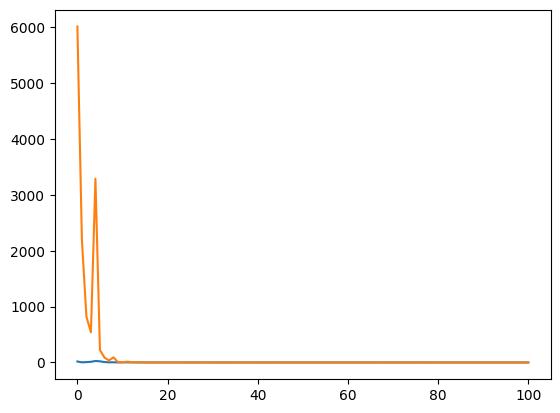

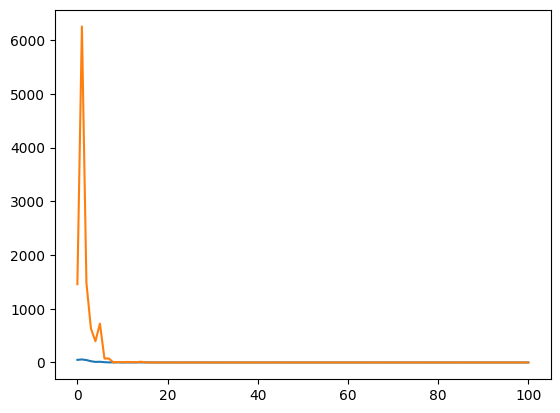

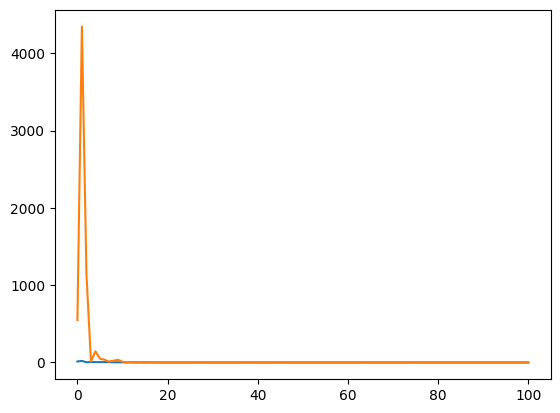

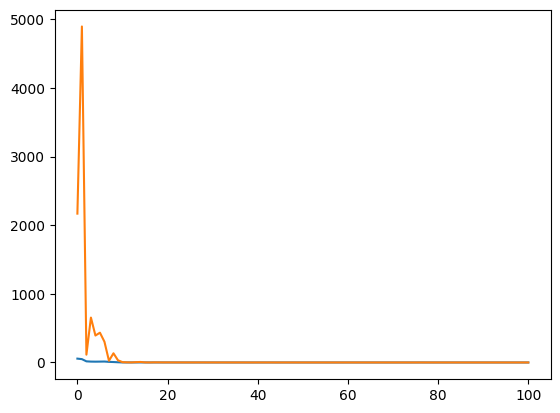

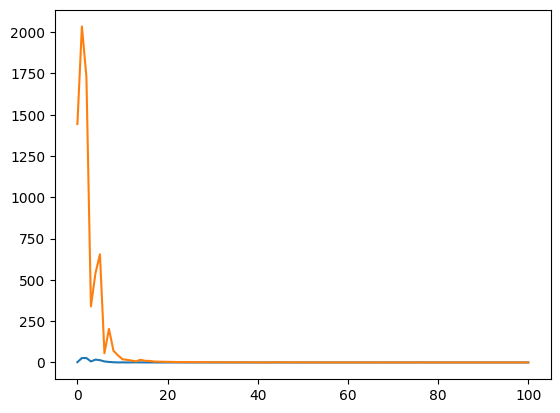

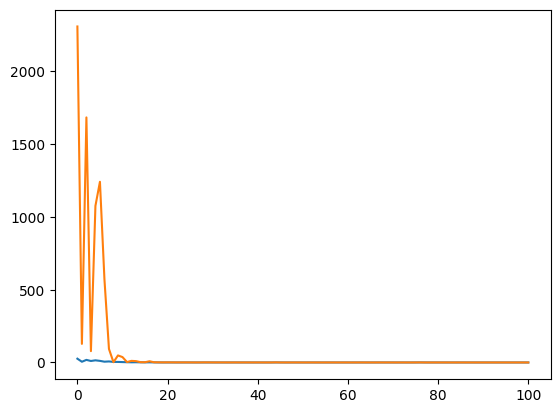

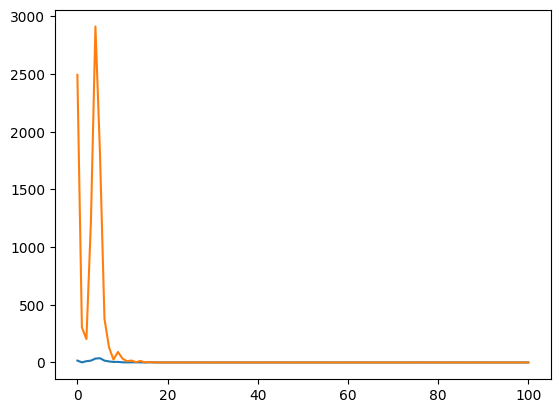

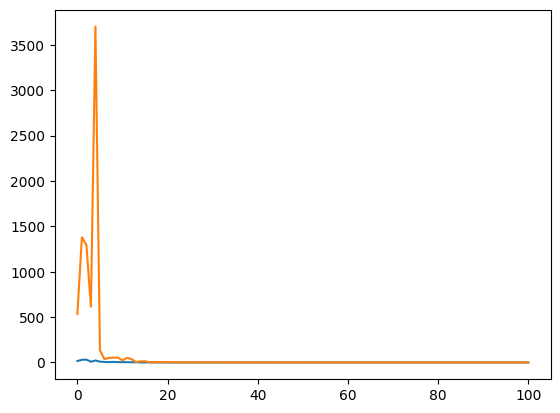

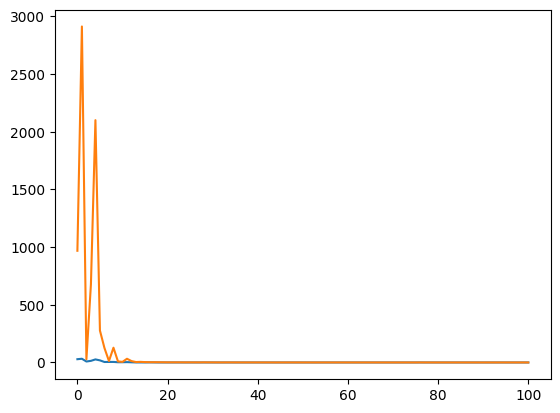

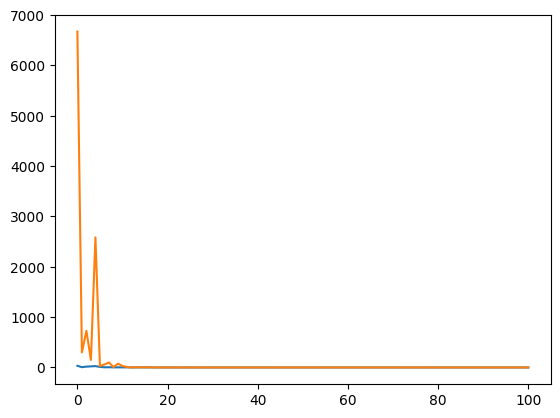

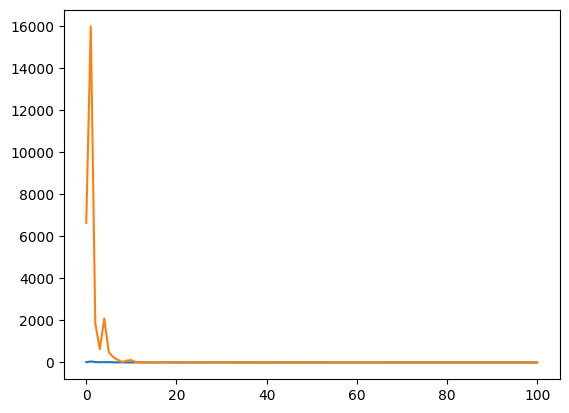

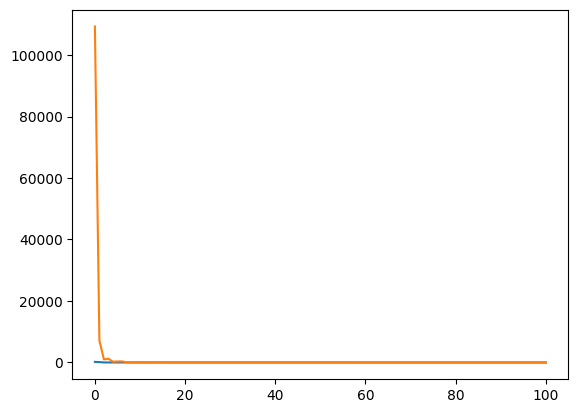

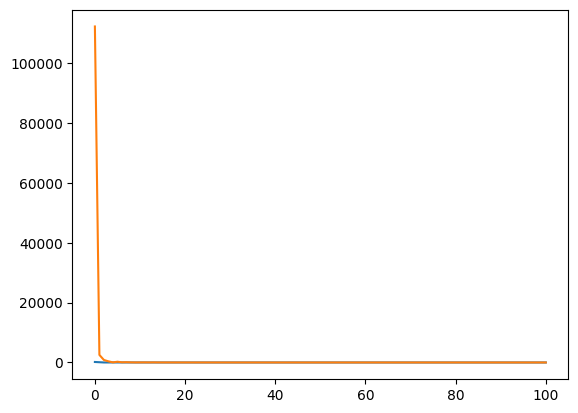

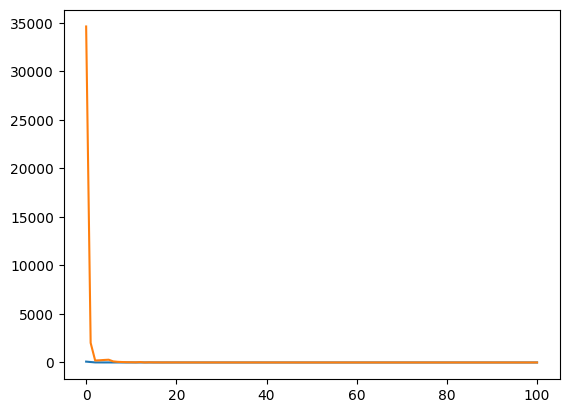

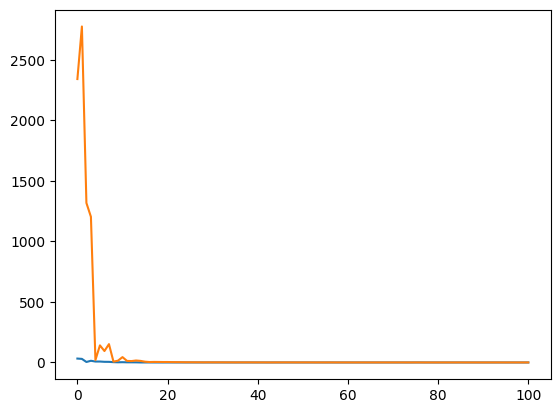

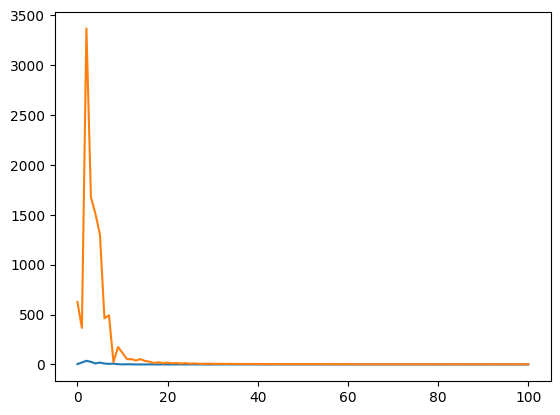

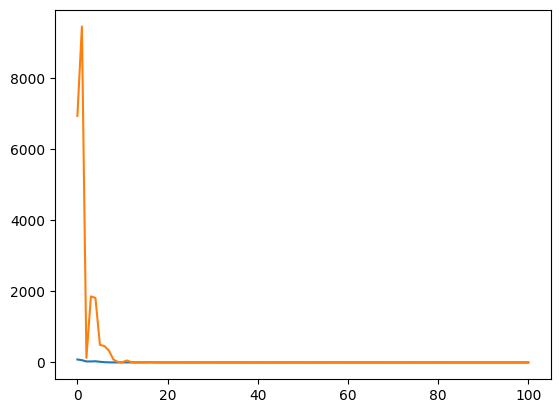

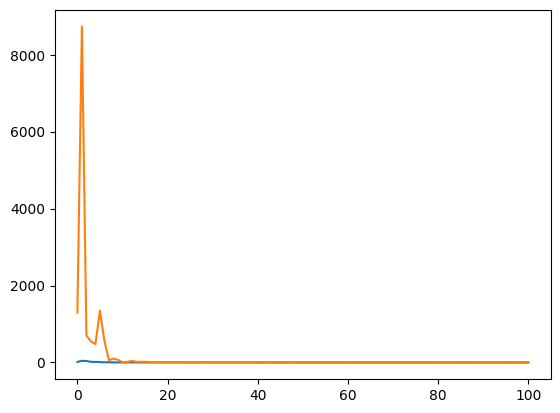

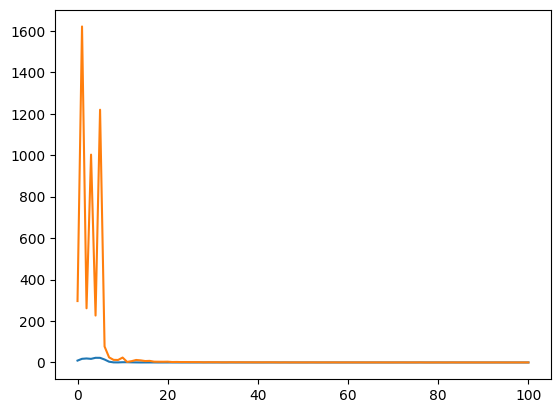

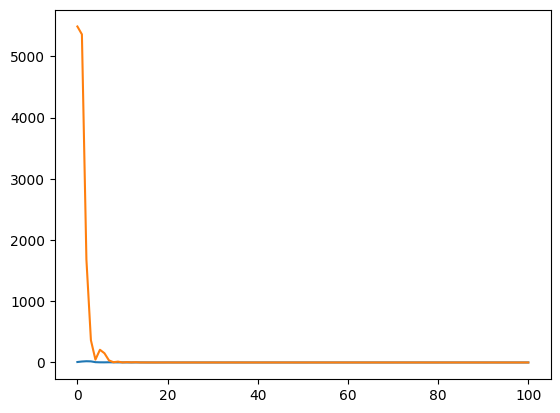

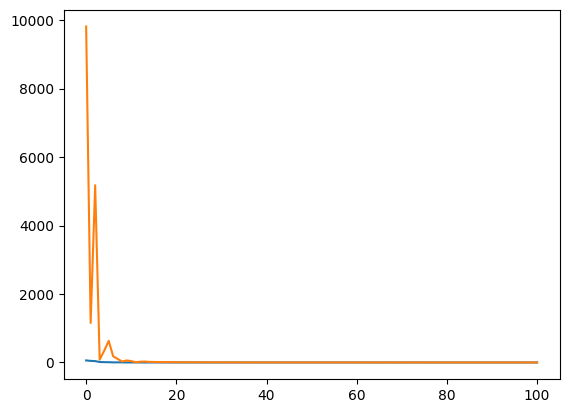

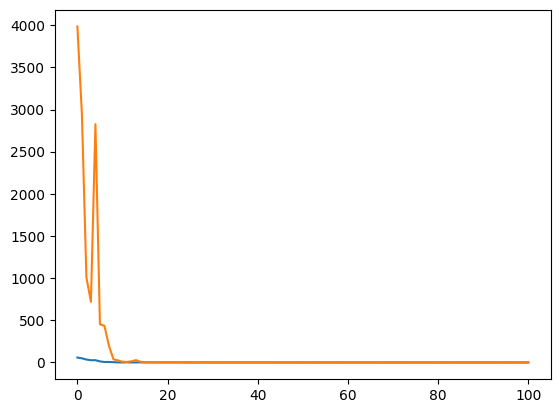

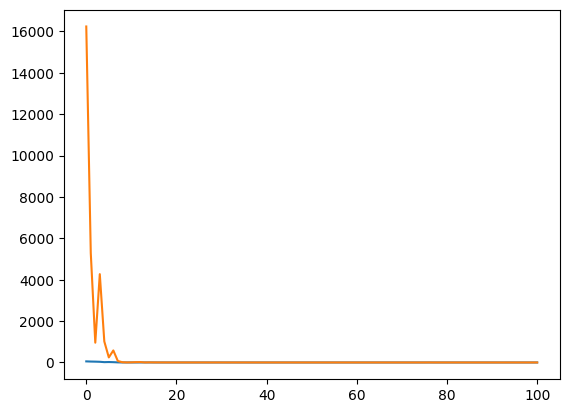

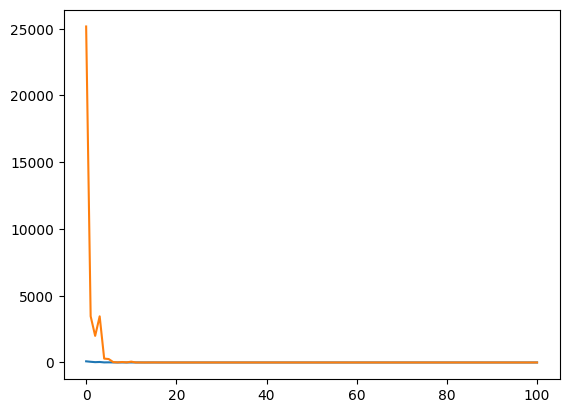

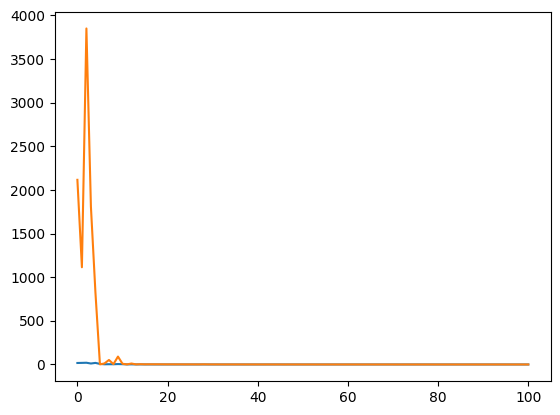

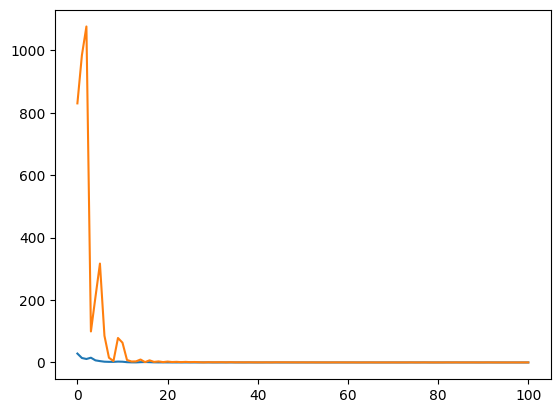

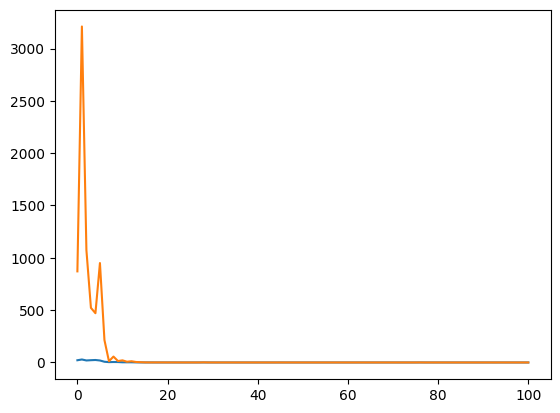

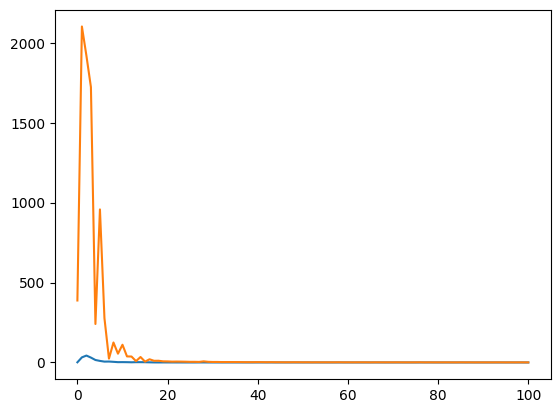

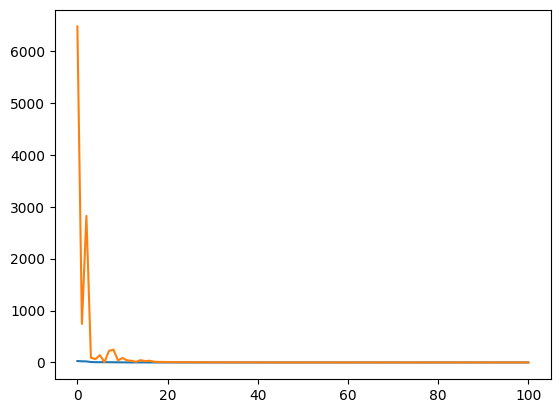

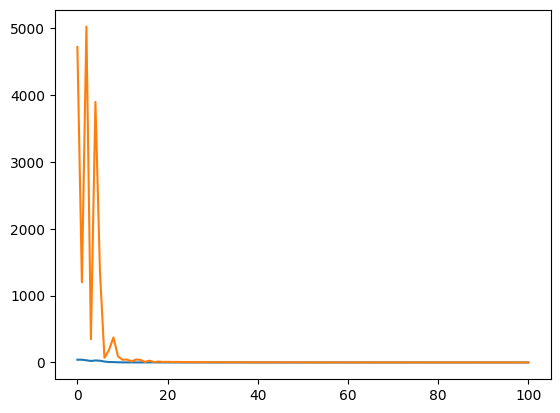

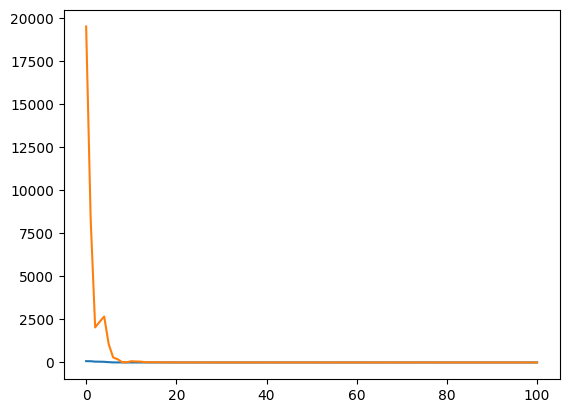

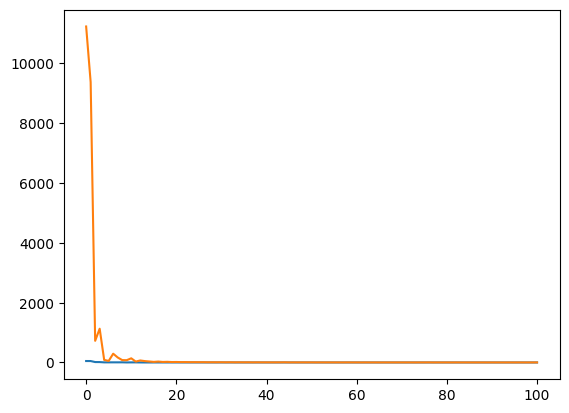

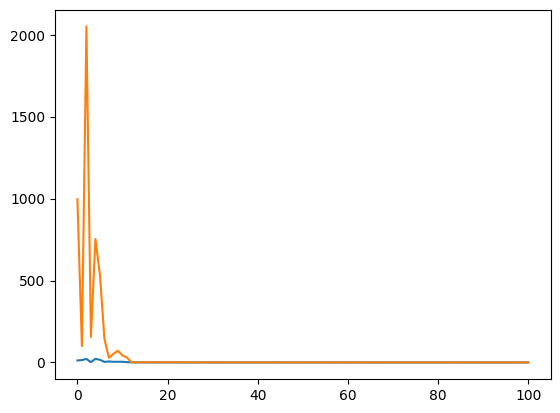

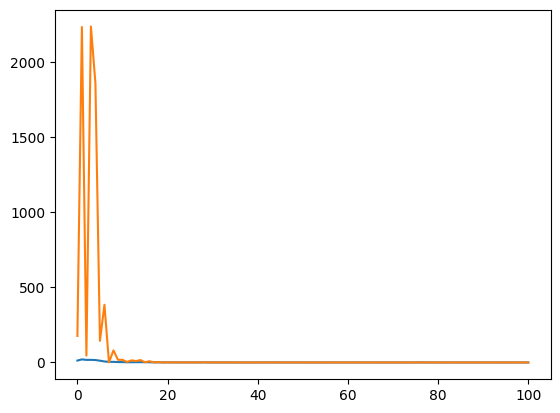

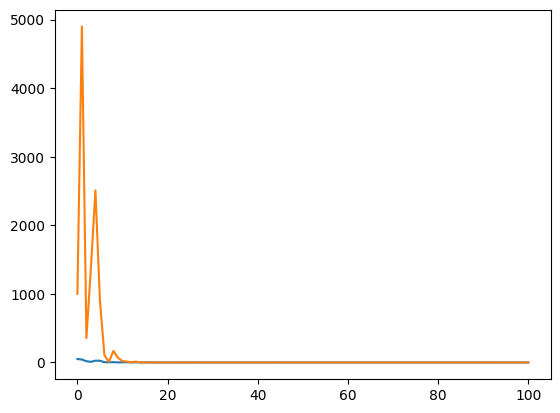

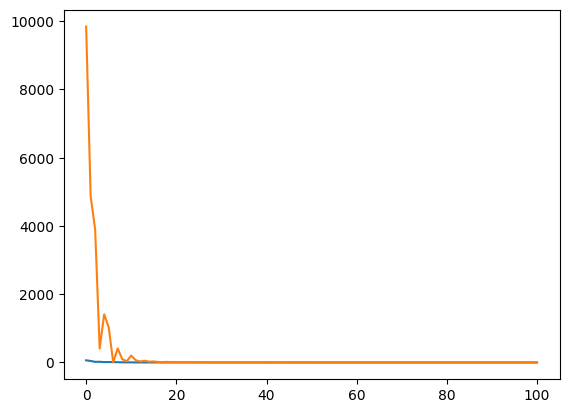

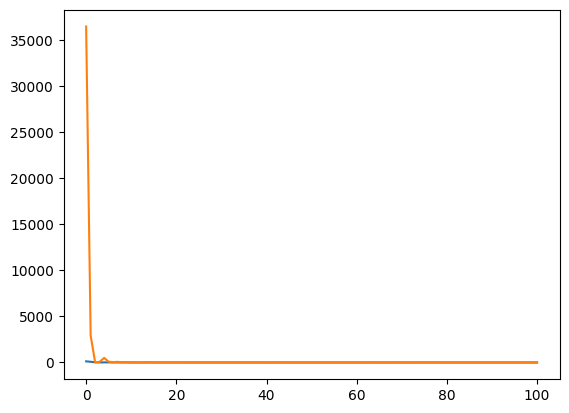

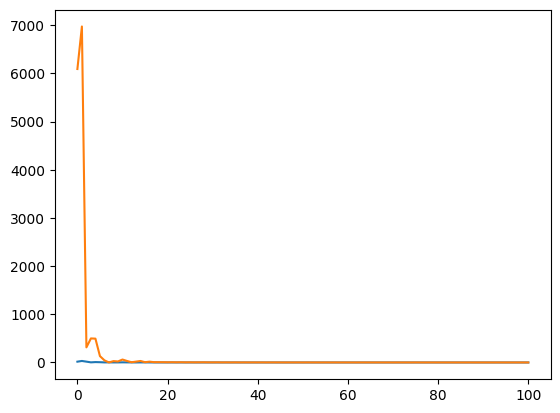

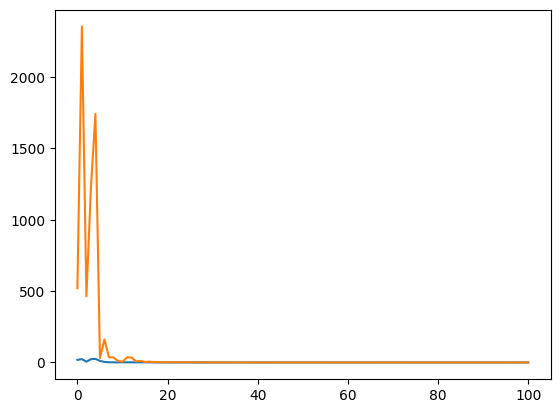

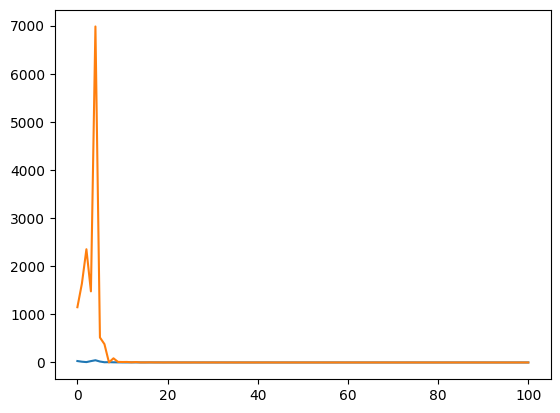

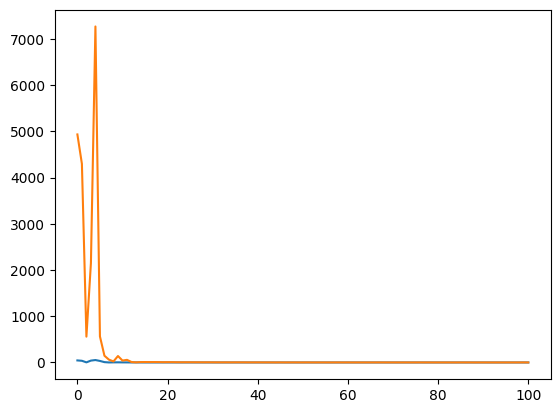

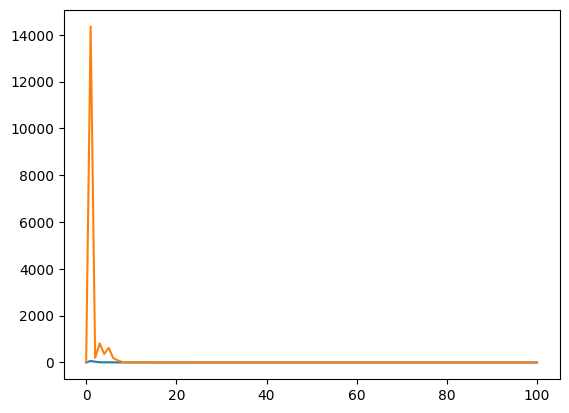

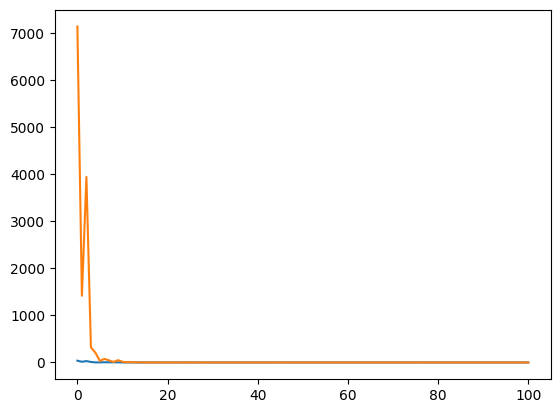

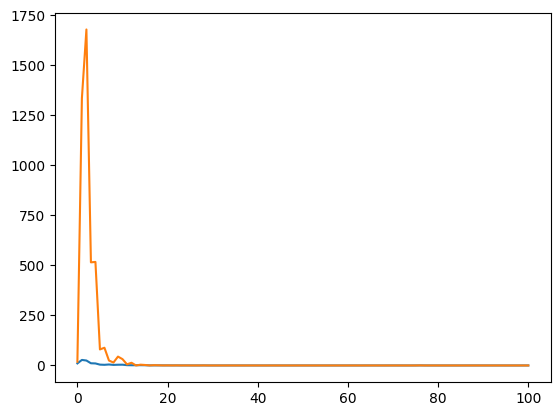

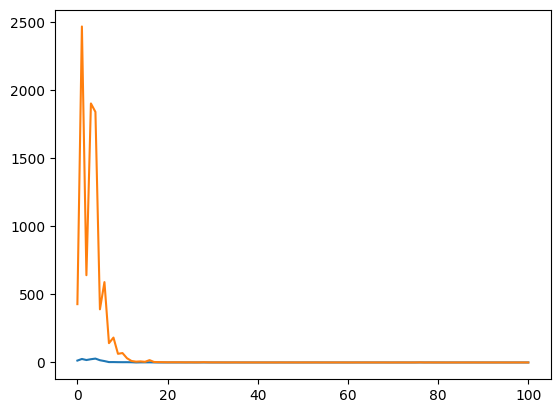

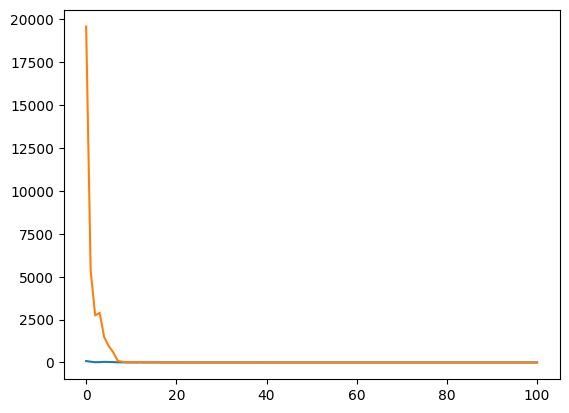

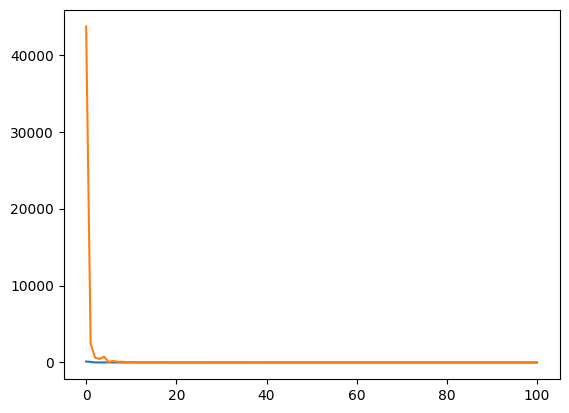

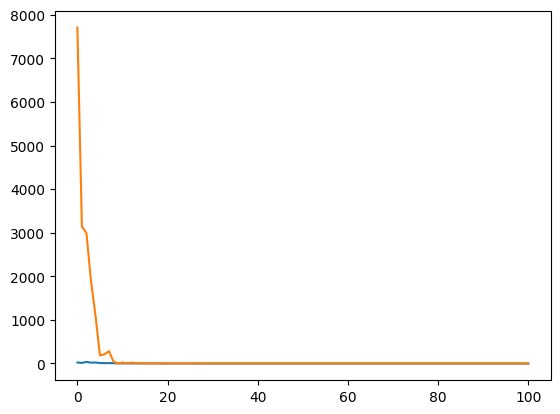

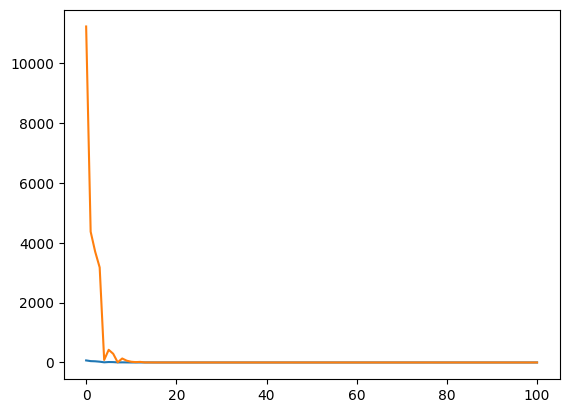

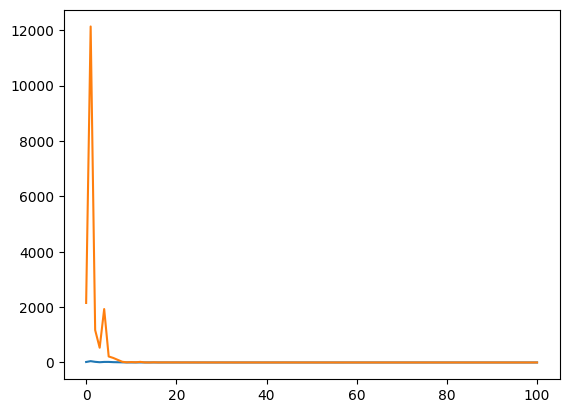

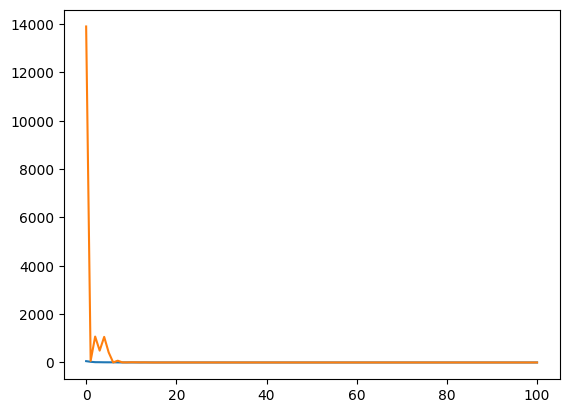

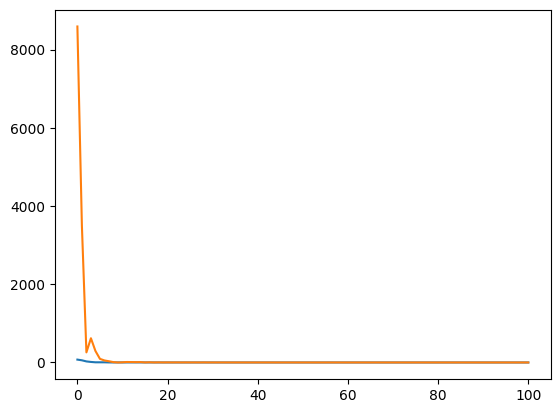

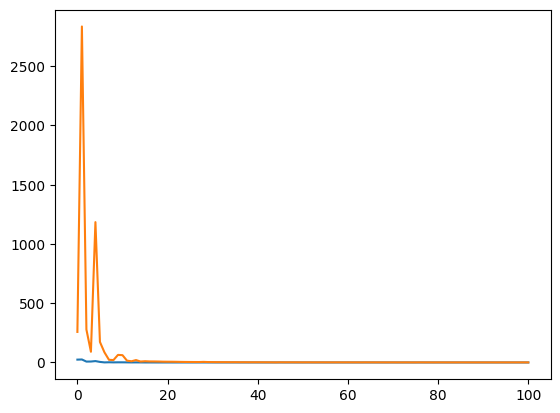

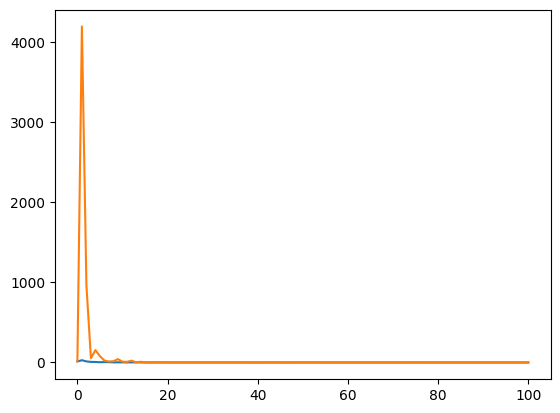

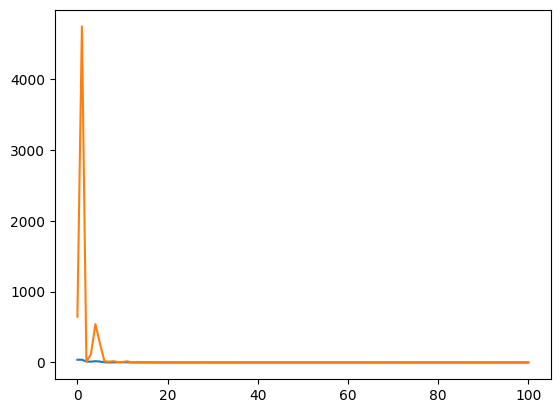

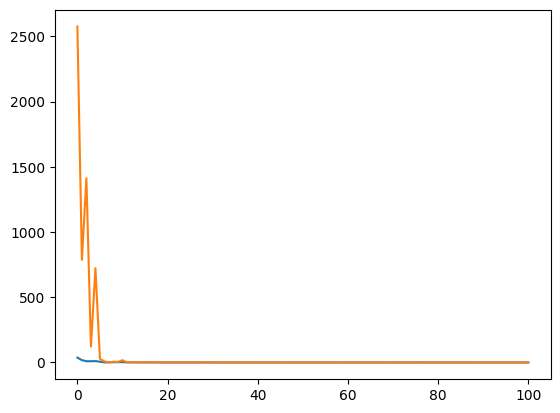

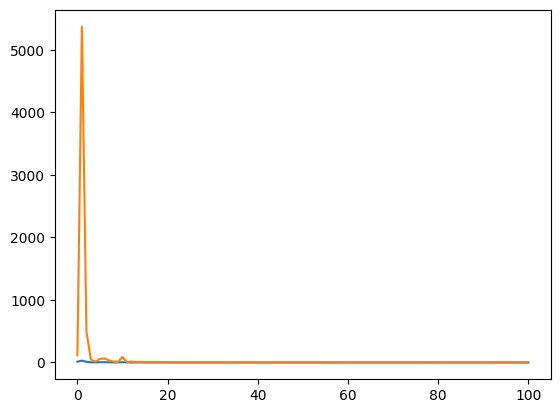

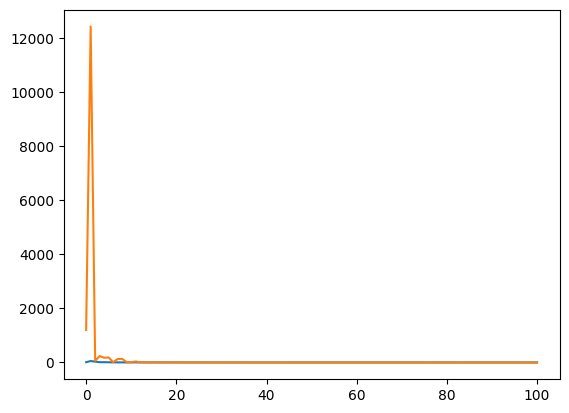

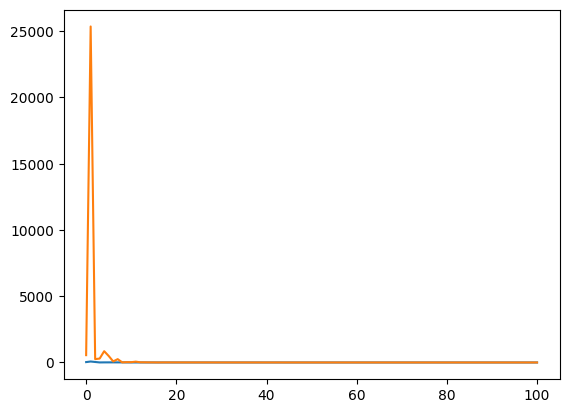

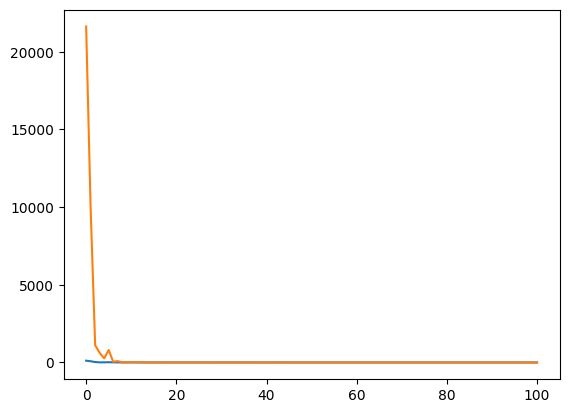

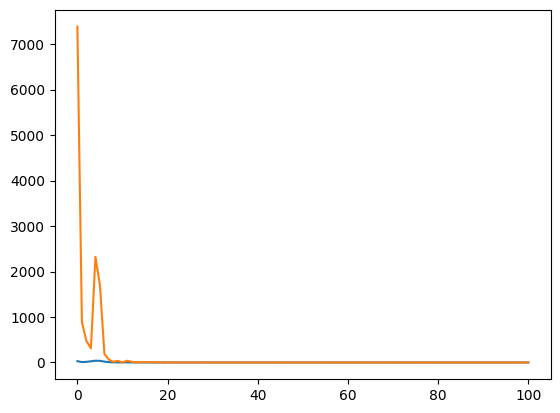

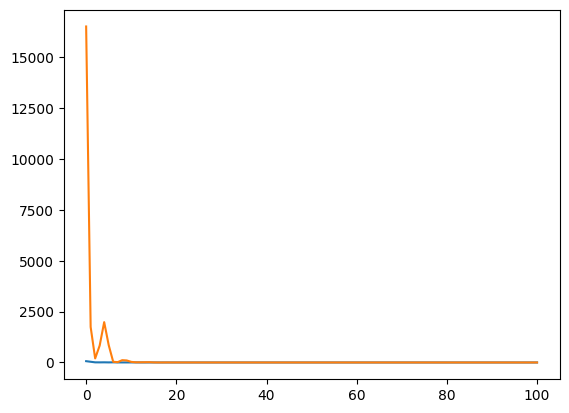

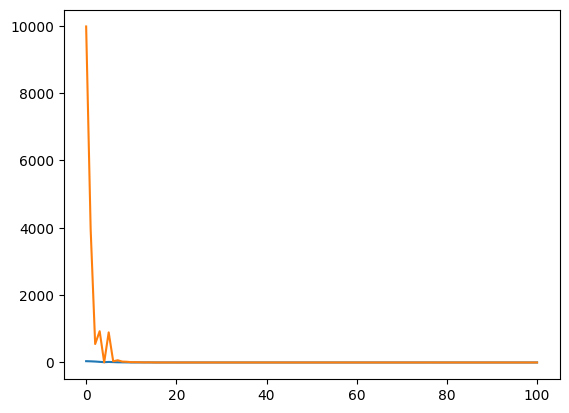

KeyboardInterrupt: 

In [11]:
"""
Enhanced EEG Reconstruction for NeuroLM VQ Model
This module provides functions to enhance the time domain reconstruction of EEG signals
by incorporating information from the power spectrum reconstruction.
"""

import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from pathlib import Path


def visualize_enhanced_reconstructions(X, xrec_raw, xrec_freq, num_channels=23, channels_to_show=None,
                                      method='blending', window_length=200, hop_length=None):
    """
    Visualize original, standard, and enhanced reconstructions for selected channels
    
    Args:
        X: Input EEG data [batch, channels, time]
        xrec_raw: Raw domain reconstruction
        xrec_freq: Frequency domain reconstruction
        num_channels: Total number of channels
        channels_to_show: List of channel indices to display (None = all)
        method: Enhancement method ('phase_recovery', 'blending', or 'highpass')
        window_length: Length of each window
        hop_length: Hop size between windows
    """
    if channels_to_show is None:
        channels_to_show = range(min(3, num_channels))  # Show first 3 channels by default
    
    # Convert to numpy
    X_np = X[0].cpu().numpy()  # First batch
    xrec_raw_np = xrec_raw[0].cpu().numpy()
    xrec_freq_np = xrec_freq[0].cpu().numpy()
    
    # Prepare data for enhancement
    enhanced_results = {}
    
    # Compute stop point for reshaping
    stop = X_np.shape[0] - X_np.shape[0] % num_channels
    
    # Process each channel
    for ch_idx in channels_to_show:
        # Extract channel data
        orig_signal = X_np[ch_idx:stop:num_channels, :].flatten()
        raw_recon = xrec_raw_np[ch_idx:stop:num_channels, :].flatten()
        freq_recon = xrec_freq_np[ch_idx:stop:num_channels, :].flatten()
        
        # Convert to PyTorch tensors for the enhancement function
        raw_tensor = torch.tensor(raw_recon).unsqueeze(0)  # Add batch dimension
        freq_tensor = torch.tensor(freq_recon).unsqueeze(0)  # Add batch dimension
        
        # Enhance the reconstruction
        enhanced_tensor = enhance_neurolm_reconstruction(
            raw_tensor, freq_tensor, method=method,
            window_length=window_length, hop_length=hop_length
        )
        
        # Convert back to numpy
        enhanced_signal = enhanced_tensor.cpu().numpy().flatten()
        
        # Store results
        enhanced_results[ch_idx] = {
            'original': orig_signal,
            'raw_recon': raw_recon,
            'enhanced': enhanced_signal
        }
    
    # Visualize each channel separately
    for ch_idx in channels_to_show:
        fig = visualize_enhancement(
            original_signal=enhanced_results[ch_idx]['original'],
            time_recon=enhanced_results[ch_idx]['raw_recon'],
            enhanced_recon=enhanced_results[ch_idx]['enhanced'],
            window_length=window_length
        )
        
        fig.suptitle(f'Channel {ch_idx+1} - Enhanced with {method.capitalize()} Method', fontsize=16)
        plt.tight_layout()
        plt.show()
        
        # Calculate error metrics
        signals = enhanced_results[ch_idx]
        
        # Normalize signals for fair comparison
        norm_orig = signals['original'] / np.sqrt(np.sum(signals['original']**2))
        norm_raw = signals['raw_recon'] / np.sqrt(np.sum(signals['raw_recon']**2))
        norm_enhanced = signals['enhanced'] / np.sqrt(np.sum(signals['enhanced']**2))
        
        # Calculate error metrics
        raw_mse = np.mean((norm_orig - norm_raw)**2)
        enhanced_mse = np.mean((norm_orig - norm_enhanced)**2)
        
        raw_corr = np.corrcoef(norm_orig, norm_raw)[0, 1]
        enhanced_corr = np.corrcoef(norm_orig, norm_enhanced)[0, 1]
        
        # Calculate spectral distance metrics
        def spectral_distance(sig1, sig2):
            # Compute power spectra
            f1 = np.abs(np.fft.rfft(sig1))**2
            f2 = np.abs(np.fft.rfft(sig2))**2
            # Normalize
            f1 = f1 / np.sum(f1)
            f2 = f2 / np.sum(f2)
            # Compute KL divergence-like measure
            return np.mean((f1 - f2)**2)
        
        raw_spectral_dist = spectral_distance(norm_orig, norm_raw)
        enhanced_spectral_dist = spectral_distance(norm_orig, norm_enhanced)
        
        # Print metrics for this channel
        print(f"\nChannel {ch_idx+1} Metrics:")
        print(f"MSE - Raw: {raw_mse:.6f}, Enhanced: {enhanced_mse:.6f}, Improvement: {(raw_mse-enhanced_mse)/raw_mse*100:.2f}%")
        print(f"Correlation - Raw: {raw_corr:.6f}, Enhanced: {enhanced_corr:.6f}, Improvement: {(enhanced_corr-raw_corr)/raw_corr*100:.2f}%")
        print(f"Spectral Distance - Raw: {raw_spectral_dist:.6f}, Enhanced: {enhanced_spectral_dist:.6f}, Improvement: {(raw_spectral_dist-enhanced_spectral_dist)/raw_spectral_dist*100:.2f}%")


def integrate_enhancement_with_model(model, batch, device, method='blending', window_length=200, hop_length=None):
    """
    Process a batch through model and apply enhancement to the reconstruction
    
    Args:
        model: The trained VQ_Align model
        batch: Batch of EEG data
        device: Device to run inference on
        method: Enhancement method ('phase_recovery', 'blending', or 'highpass')
        window_length: Length of each window
        hop_length: Hop size between windows
        
    Returns:
        X: Original input
        xrec_raw: Raw time-domain reconstruction
        xrec_freq: Frequency domain reconstruction
        xrec_enhanced: Enhanced time-domain reconstruction
    """
    # Process batch through model
    X, Y_freq, Y_raw, input_chans, input_time, input_mask = batch
    
    X = X.float().to(device, non_blocking=True)
    Y_freq = Y_freq.float().to(device, non_blocking=True)
    Y_raw = Y_raw.float().to(device, non_blocking=True)
    input_chans = input_chans.to(device, non_blocking=True)
    input_time = input_time.to(device, non_blocking=True)
    input_mask = input_mask.to(device, non_blocking=True)
    
    with torch.no_grad():
        # Get reconstructions from model
        (xrec_freq, xrec_raw), encoder_features, log = model.VQ(
            X, Y_freq, Y_raw, input_chans, input_time, input_mask, 
            return_reconstruction=True
        )
    
    # Enhance the reconstruction
    xrec_enhanced = enhance_neurolm_reconstruction(
        xrec_raw, xrec_freq, method=method,
        window_length=window_length, hop_length=hop_length
    )
    
    return X, xrec_raw, xrec_freq, xrec_enhanced


def analyze_enhanced_reconstructions(model, data_loader, device, num_channels=23, 
                                    methods=['phase_recovery', 'blending', 'highpass'],
                                    window_length=200, hop_length=None, num_batches=1, cache = None):
    """
    Perform comprehensive analysis of enhanced EEG reconstructions
    
    Args:
        model: The trained VQ_Align model
        data_loader: DataLoader with EEG samples
        device: Device to run inference on
        num_channels: Number of EEG channels
        methods: List of enhancement methods to test
        window_length: Length of each window
        hop_length: Hop size between windows
        num_batches: Number of batches to analyze
    """
    model.eval()  # Set model to evaluation mode
    
    for batch_idx, batch in enumerate(data_loader):
        if batch_idx >= num_batches:
            break
        if cache is not None:
            (X, Y_freq, Y_raw, input_chans, input_time, input_mask, (xrec_freq, xrec_raw), encoder_features, log) = cache
        else:
            print(f"\nProcessing batch {batch_idx+1}/{num_batches}")
            
            # Process through model
            X, Y_freq, Y_raw, input_chans, input_time, input_mask = batch
            X = X.float().to(device, non_blocking=True)
            Y_freq = Y_freq.float().to(device, non_blocking=True)
            Y_raw = Y_raw.float().to(device, non_blocking=True)
            input_chans = input_chans.to(device, non_blocking=True)
            input_time = input_time.to(device, non_blocking=True)
            input_mask = input_mask.to(device, non_blocking=True)
            
            with torch.no_grad():
                (xrec_freq, xrec_raw), encoder_features, log = model.VQ(
                    X, Y_freq, Y_raw, input_chans, input_time, input_mask, 
                    return_reconstruction=True
                )
        # Get min values along the last dimension and keep dimensions
        # min_values, _ = xrec_freq.min(dim=-1, keepdim=True)
        # The error occurs because torch.max() returns a tuple (values, indices)
        # We need to extract just the values part for division
        # Normalize the frequency reconstruction
        # Test each enhancement method
        for method in methods:
            print(f"\nTesting enhancement method: {method}")
            
            # Visualize channel reconstructions with enhanced results
            visualize_enhanced_reconstructions(
                X, xrec_raw, xrec_freq, 
                num_channels=num_channels,
                channels_to_show=range(min(3, num_channels)),  # Show first 3 channels
                method=method,
                window_length=window_length,
                hop_length=hop_length
            )
        
        print(f"Completed analysis for batch {batch_idx+1}")


# Example usage
if __name__ == "__main__":

    # X, Y_freq, Y_raw, input_chans, input_time, input_mask = next(iter(data_loader1))
    # X = X.float().to(device, non_blocking=True)
    # Y_freq = Y_freq.float().to(device, non_blocking=True)
    # Y_raw = Y_raw.float().to(device, non_blocking=True)
    # input_chans = input_chans.to(device, non_blocking=True)
    # input_time = input_time.to(device, non_blocking=True)
    # input_mask = input_mask.to(device, non_blocking=True)
    
    # with torch.no_grad():
    #     (xrec_freq, xrec_raw), encoder_features, log = model.VQ(
    #         X, Y_freq, Y_raw, input_chans, input_time, input_mask, 
    #         return_reconstruction=True
    #     )
    analyze_enhanced_reconstructions(
        model, data_loader1, device, 
        num_channels=23, 
        methods=['blending'],
        cache = (X, Y_freq, Y_raw, input_chans, input_time, input_mask, (xrec_freq, xrec_raw), encoder_features, log)
    )

In [1]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import torch


def enhance_neurolm_reconstruction(xrec_raw, xrec_freq, method='blending', 
                                window_length=200, hop_length=None, window_func=None, 
                                freq_transition=0.3, freq_slope=5.0, highpass_cutoff=0.3):
    """
    Enhance time-domain EEG reconstruction using power spectra information from PyTorch tensors.
    
    Parameters:
    - xrec_raw: Time-domain reconstruction tensor [batch, channels, time] or [channels, time]
    - xrec_freq: Frequency domain reconstruction tensor [batch, channels, freq] or [channels, freq]
    - method: enhancement method ('phase_recovery', 'blending', or 'highpass')
    - window_length: length of each window (default: 200)
    - hop_length: hop size between windows (default: window_length // 2)
    - window_func: window function to use (default: Hann window)
    - freq_transition: normalized frequency (0-1) for transition point (default: 0.3)
    - freq_slope: steepness of frequency transition (default: 5.0)
    - highpass_cutoff: normalized cutoff frequency for high-pass filter (default: 0.3)
    
    Returns:
    - enhanced_recon: enhanced time-domain reconstruction tensor with same shape as xrec_raw
    """
    # Determine if we have batch dimension
    has_batch = len(xrec_raw.shape) == 3
    
    # Convert to numpy for processing
    device = xrec_raw.device
    if has_batch:
        batch_size = xrec_raw.shape[0]
        n_channels = xrec_raw.shape[1]
        time_length = xrec_raw.shape[2]
        xrec_raw_np = xrec_raw.cpu().numpy()
        xrec_freq_np = xrec_freq.cpu().numpy()
    else:
        n_channels = xrec_raw.shape[0]
        time_length = xrec_raw.shape[1]
        xrec_raw_np = xrec_raw.cpu().numpy()
        xrec_freq_np = xrec_freq.cpu().numpy()
        batch_size = 1
        # Add batch dimension for consistent processing
        xrec_raw_np = xrec_raw_np.reshape(1, n_channels, time_length)
        xrec_freq_np = xrec_freq_np.reshape(1, n_channels, xrec_freq_np.shape[-1])
    
    # Process each batch and channel separately
    enhanced_recon_np = np.zeros_like(xrec_raw_np)
    
    for b in range(batch_size):
        for c in range(n_channels):
            # Get time domain signal for this channel
            time_signal = xrec_raw_np[b, c]
            
            # Convert power spectra windows to appropriate format
            # We need to reshape the power spectra for this channel
            # The power spectra should be [n_windows, n_freqs]
            freq_length = xrec_freq_np.shape[-1]
            
            # Set hop length if not specified
            if hop_length is None:
                hop_length = window_length // 2
                
            # Calculate number of windows
            n_windows = (time_length - window_length) // hop_length + 1
            
            # Handle the case where power spectra might be arranged differently
            # This depends on how your model outputs the frequency data
            if freq_length == 100:  # As mentioned in prompt, 100 points for power spectrum
                # Create windows from the power spectrum representation
                power_spectra = []
                for i in range(n_windows):
                    # If the model outputs a single power spectrum per channel, 
                    # we'll use it for all windows (replicating)
                    power_spectra.append(xrec_freq_np[b, c])
                power_spectra = np.array(power_spectra)
            else:
                # If power spectra need to be extracted from continuous data
                power_spectra = []
                
                for i in range(0, time_length - window_length + 1, hop_length):
                    window_data = time_signal[i:i+window_length]
                    # Calculate power spectrum for this window
                    window_fft = np.fft.rfft(window_data)
                    window_power = np.abs(window_fft)**2
                    power_spectra.append(window_power)
                
                power_spectra = np.array(power_spectra)
            
            # Use the core function to enhance this channel
            enhanced_channel, _ = enhance_eeg_reconstruction(
                time_signal, power_spectra, method, 
                window_length, hop_length, window_func,
                freq_transition, freq_slope, highpass_cutoff
            )
            
            # Store the enhanced result
            enhanced_recon_np[b, c] = enhanced_channel[:time_length]
    
    # Convert back to tensor and match original shape
    if has_batch:
        enhanced_recon = torch.tensor(enhanced_recon_np, device=device)
    else:
        enhanced_recon = torch.tensor(enhanced_recon_np[0], device=device)
    
    return enhanced_recon


def enhance_eeg_reconstruction(time_recon, power_spectra, method='blending', 
                              window_length=200, hop_length=None, window_func=None, 
                              freq_transition=0.3, freq_slope=5.0, highpass_cutoff=0.3):
    """
    Enhance time-domain EEG reconstruction using power spectra information.
    
    Parameters:
    - time_recon: numpy array of time-domain reconstruction (shape: [n_samples])
    - power_spectra: numpy array of power spectra (shape: [n_windows, n_freqs])
    - method: enhancement method ('phase_recovery', 'blending', or 'highpass')
    - window_length: length of each window (default: 200)
    - hop_length: hop size between windows (default: window_length // 2)
    - window_func: window function to use (default: Hann window)
    - freq_transition: normalized frequency (0-1) for transition point (default: 0.3)
    - freq_slope: steepness of frequency transition (default: 5.0)
    - highpass_cutoff: normalized cutoff frequency for high-pass filter (default: 0.3)
    
    Returns:
    - enhanced_recon: enhanced time-domain reconstruction
    - used_power_spectrum: power spectrum used for enhancement (for visualization)
    """
    if hop_length is None:
        hop_length = window_length // 2
        
    if window_func is None:
        window_func = signal.windows.hann(window_length, sym=False)
    
    n_windows = len(power_spectra)
    n_freqs = power_spectra.shape[1]
    expected_rfft_length = window_length // 2 + 1  # For real FFT
    
    # Select the appropriate enhancement method
    if method == 'phase_recovery':
        return phase_recovery_enhancement(time_recon, power_spectra, window_length, 
                                         hop_length, window_func)
    elif method == 'blending':
        return freq_blending_enhancement(time_recon, power_spectra, window_length, 
                                        hop_length, window_func, freq_transition, freq_slope)
    elif method == 'highpass':
        return highpass_enhancement(time_recon, power_spectra, window_length, 
                                   hop_length, window_func, highpass_cutoff)
    else:
        raise ValueError(f"Unknown method: {method}. Choose from 'phase_recovery', 'blending', or 'highpass'")


def phase_recovery_enhancement(time_recon, power_spectra, window_length=200, hop_length=None, window_func=None):
    """
    Enhance reconstruction using phase from time domain and magnitude from power spectra.
    
    Returns:
    - enhanced_recon: The enhanced reconstruction
    - used_power_spectrum: The power spectrum used for visualization
    """
    if hop_length is None:
        hop_length = window_length // 2
        
    if window_func is None:
        window_func = signal.windows.hann(window_length, sym=False)
    
    n_windows = len(power_spectra)
    expected_signal_length = hop_length * (n_windows - 1) + window_length
    
    # Ensure time_recon is long enough
    if len(time_recon) < expected_signal_length:
        time_recon = np.pad(time_recon, (0, expected_signal_length - len(time_recon)))
    
    enhanced_recon = np.zeros_like(time_recon)
    window_sum = np.zeros_like(time_recon)
    
    # Save a representative power spectrum for visualization
    used_power_spectrum = None
    
    for i in range(n_windows):
        start_idx = i * hop_length
        end_idx = start_idx + window_length
        
        # Extract current window
        current_window = time_recon[start_idx:end_idx]
        
        # Apply window function and compute FFT
        windowed_signal = current_window * window_func
        fft_time = np.fft.rfft(windowed_signal)
        
        # Extract phase from time-domain FFT
        phase_time = np.angle(fft_time)
        
        # Handle potential dimension mismatch with power_spectra
        magnitude_power = adjust_power_spectrum(power_spectra[i], phase_time, fft_time)
        
        # Save a representative power spectrum for later visualization (middle window)
        if i == n_windows // 2 and used_power_spectrum is None:
            used_power_spectrum = magnitude_power**2  # Square to get power
        
        # Combine magnitude from power spectrum with phase from time domain
        enhanced_fft = magnitude_power * np.exp(1j * phase_time)
        
        # Convert back to time domain
        enhanced_window = np.fft.irfft(enhanced_fft)
        
        # Apply window and add to output
        enhanced_recon[start_idx:end_idx] += enhanced_window * window_func
        window_sum[start_idx:end_idx] += window_func**2
    
    # Normalize by window overlap
    valid_indices = window_sum > 1e-10
    enhanced_recon[valid_indices] /= window_sum[valid_indices]
    
    return enhanced_recon, used_power_spectrum


def freq_blending_enhancement(time_recon, power_spectra, window_length=200, hop_length=None, 
                             window_func=None, freq_transition=0.3, freq_slope=5.0):
    """
    Enhance reconstruction with frequency-dependent blending of original and power spectrum.
    
    Returns:
    - enhanced_recon: The enhanced reconstruction
    - used_power_spectrum: The power spectrum used for visualization
    """
    if hop_length is None:
        hop_length = window_length // 2
        
    if window_func is None:
        window_func = signal.windows.hann(window_length, sym=False)
    
    n_windows = len(power_spectra)
    expected_signal_length = hop_length * (n_windows - 1) + window_length
    expected_rfft_length = window_length // 2 + 1
    
    # Ensure time_recon is long enough
    if len(time_recon) < expected_signal_length:
        time_recon = np.pad(time_recon, (0, expected_signal_length - len(time_recon)))
    
    # Create frequency-dependent weights for blending
    freq_indices = np.arange(expected_rfft_length)
    normalized_freqs = freq_indices / (expected_rfft_length - 1)
    
    # Sigmoid weighting: low values for low frequencies, high values for high frequencies
    power_weights = 1.0 / (1.0 + np.exp(-freq_slope * (normalized_freqs - freq_transition)))
    time_weights = 1.0 - power_weights
    
    enhanced_recon = np.zeros_like(time_recon)
    window_sum = np.zeros_like(time_recon)
    
    # Save a representative power spectrum for visualization
    used_power_spectrum = None
    blended_magnitude_visualization = None
    
    for i in range(n_windows):
        start_idx = i * hop_length
        end_idx = start_idx + window_length
        
        # Extract current window
        current_window = time_recon[start_idx:end_idx]
        
        # Apply window function and compute FFT
        windowed_signal = current_window * window_func
        fft_time = np.fft.rfft(windowed_signal)
        
        # Extract magnitude and phase from time-domain FFT
        magnitude_time = np.abs(fft_time)
        phase_time = np.angle(fft_time)
        
        # Handle potential dimension mismatch with power_spectra
        magnitude_power = adjust_power_spectrum(power_spectra[i], phase_time, fft_time)
        
        # Frequency-dependent blending of magnitudes
        blended_magnitude = (time_weights * magnitude_time) + (power_weights * magnitude_power)
        
        # Save a representative power spectrum and blended magnitude for visualization (middle window)
        if i == n_windows // 2 and used_power_spectrum is None:
            used_power_spectrum = magnitude_power**2  # Square to get power
            blended_magnitude_visualization = blended_magnitude**2  # This is what was actually used
        
        # Combine blended magnitude with original phase
        enhanced_fft = blended_magnitude * np.exp(1j * phase_time)
        
        # Convert back to time domain
        enhanced_window = np.fft.irfft(enhanced_fft)
        
        # Apply window and add to output
        enhanced_recon[start_idx:end_idx] += enhanced_window * window_func
        window_sum[start_idx:end_idx] += window_func**2
    
    # Normalize by window overlap
    valid_indices = window_sum > 1e-10
    enhanced_recon[valid_indices] /= window_sum[valid_indices]
    
    return enhanced_recon, blended_magnitude_visualization


def highpass_enhancement(time_recon, power_spectra, window_length=200, hop_length=None, 
                        window_func=None, cutoff_freq=0.3):
    """
    Enhance reconstruction by adding high-frequency components from power spectra.
    
    Returns:
    - enhanced_recon: The enhanced reconstruction
    - used_power_spectrum: The power spectrum used for visualization
    """
    if hop_length is None:
        hop_length = window_length // 2
        
    if window_func is None:
        window_func = signal.windows.hann(window_length, sym=False)
    
    n_windows = len(power_spectra)
    expected_signal_length = hop_length * (n_windows - 1) + window_length
    
    # Ensure time_recon is long enough
    if len(time_recon) < expected_signal_length:
        time_recon = np.pad(time_recon, (0, expected_signal_length - len(time_recon)))
    
    # First, reconstruct signal from power spectra using phase from time domain
    power_recon, used_power_spectrum = phase_recovery_enhancement(time_recon, power_spectra, window_length, hop_length, window_func)
    
    # Design high-pass filter
    nyquist = 0.5  # Normalized Nyquist frequency
    cutoff = cutoff_freq * nyquist
    b, a = signal.butter(5, cutoff, btype='high', analog=False)
    
    # Apply high-pass filter to power-based reconstruction
    highpass_power_recon = signal.filtfilt(b, a, power_recon)
    
    # Combine original time reconstruction with high-pass filtered power reconstruction
    enhanced_recon = time_recon + highpass_power_recon
    
    # Create a visualization of the high-pass spectrum
    if used_power_spectrum is not None:
        # Create a frequency axis for visualization
        freq_indices = np.arange(len(used_power_spectrum))
        normalized_freqs = freq_indices / (len(used_power_spectrum) - 1)
        
        # Create high-pass mask similar to our filter
        highpass_mask = np.ones_like(normalized_freqs)
        transition_idx = int(cutoff_freq * len(normalized_freqs))
        highpass_mask[:transition_idx] = 0
        
        # Smoothen the transition
        transition_width = int(0.05 * len(normalized_freqs))
        for i in range(transition_idx - transition_width, transition_idx + transition_width):
            if 0 <= i < len(highpass_mask):
                x = (i - (transition_idx - transition_width)) / (2 * transition_width)
                highpass_mask[i] = 0.5 * (1 - np.cos(np.pi * x))
        
        # Apply the high-pass mask to the power spectrum for visualization
        highpass_spectrum = used_power_spectrum * highpass_mask
        
        return enhanced_recon, highpass_spectrum
    
    return enhanced_recon, used_power_spectrum


def adjust_power_spectrum(power_spectrum, phase, fft_time):
    """
    Adjust power spectrum to match expected dimensions for rfft output.
    """
    expected_length = len(phase)
    
    if len(power_spectrum) != expected_length:
        adjusted_power = np.zeros(expected_length)
        
        if len(power_spectrum) == expected_length - 1:
            # Missing DC component
            adjusted_power[1:] = power_spectrum
            adjusted_power[0] = np.abs(fft_time[0])**2  # Use DC from time domain
        else:
            # Missing highest frequency bin or different size
            min_len = min(len(power_spectrum), expected_length)
            adjusted_power[:min_len] = power_spectrum[:min_len]
            
            # Fill remaining with time-domain data if needed
            if expected_length > min_len:
                adjusted_power[min_len:] = np.abs(fft_time[min_len:])**2
    else:
        adjusted_power = power_spectrum
    
    # Convert power to magnitude
    return np.sqrt(adjusted_power)


def visualize_enhancement(original_signal=None, time_recon=None, enhanced_recon=None, 
                         power_spectrum=None, sampling_rate=None, window_length=200):
    """
    Visualize the original, reconstructed, and enhanced signals in time and frequency domains.
    
    Parameters:
    - original_signal: Original EEG signal (optional)
    - time_recon: Time domain reconstruction (optional)
    - enhanced_recon: Enhanced reconstruction (optional)
    - power_spectrum: Power spectrum used in enhancement (optional)
    - sampling_rate: Sampling rate for time axis (optional)
    - window_length: Length of each window (default: 200)
    
    Returns:
    - fig: Matplotlib figure object
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Determine signal lengths and time axis
    signals = [s for s in [original_signal, time_recon, enhanced_recon] if s is not None]
    min_length = min(len(s) for s in signals)
    
    time_axis = np.arange(min_length)
    if sampling_rate:
        time_axis = time_axis / sampling_rate
        time_label = 'Time (s)'
    else:
        time_label = 'Sample'
    
    # Time domain plot
    ax = axes[0, 0]
    if original_signal is not None:
        ax.plot(time_axis, original_signal[:min_length], 'b-', label='Original')
    if time_recon is not None:
        ax.plot(time_axis, time_recon[:min_length], 'r-', label='Time Reconstruction')
    if enhanced_recon is not None:
        ax.plot(time_axis, enhanced_recon[:min_length], 'g-', label='Enhanced')
    
    ax.set_title('Time Domain Comparison')
    ax.set_xlabel(time_label)
    ax.set_ylabel('Amplitude')
    ax.legend()
    
    # Zoomed time domain (show detail of high frequency differences)
    ax = axes[0, 1]
    zoom_start = min(1000, min_length // 2)
    zoom_length = min(500, min_length // 4)
    zoom_time = time_axis[zoom_start:zoom_start+zoom_length]
    
    if original_signal is not None:
        ax.plot(zoom_time, original_signal[zoom_start:zoom_start+zoom_length], 'b-', label='Original')
    if time_recon is not None:
        ax.plot(zoom_time, time_recon[zoom_start:zoom_start+zoom_length], 'r-', label='Time Reconstruction')
    if enhanced_recon is not None:
        ax.plot(zoom_time, enhanced_recon[zoom_start:zoom_start+zoom_length], 'g-', label='Enhanced')
    
    ax.set_title('Time Domain (Zoomed)')
    ax.set_xlabel(time_label)
    ax.set_ylabel('Amplitude')
    ax.legend()
    
    # Frequency domain plot
    ax = axes[1, 0]
    n_fft = window_length * 2
    
    # Calculate FFT for all signals
    def calculate_fft(signal):
        fft_result = np.abs(np.fft.rfft(signal[:min_length], n=n_fft))
        # Normalize for better comparison
        return fft_result / np.max(fft_result) if np.max(fft_result) > 0 else fft_result
    
    freq_axis = np.fft.rfftfreq(n_fft, d=1.0/sampling_rate if sampling_rate else 1.0)
    
    if original_signal is not None:
        original_fft = calculate_fft(original_signal)
        ax.plot(freq_axis, original_fft, 'b-', label='Original')
    
    if time_recon is not None:
        time_recon_fft = calculate_fft(time_recon)
        ax.plot(freq_axis, time_recon_fft, 'r-', label='Time Reconstruction')
    
    if enhanced_recon is not None:
        enhanced_fft = calculate_fft(enhanced_recon)
        ax.plot(freq_axis, enhanced_fft, 'g-', label='Enhanced')
    
    # Add power spectrum used in enhancement if provided
    if power_spectrum is not None:
        # Ensure power spectrum length matches freq_axis
        if len(power_spectrum) != len(freq_axis):
            # Resample or pad/trim as needed
            if len(power_spectrum) > len(freq_axis):
                power_spectrum = power_spectrum[:len(freq_axis)]
            else:
                power_spectrum = np.pad(power_spectrum, (0, len(freq_axis) - len(power_spectrum)))
        
        # Normalize for better comparison
        power_spectrum_norm = power_spectrum / np.max(power_spectrum) if np.max(power_spectrum) > 0 else power_spectrum
        ax.plot(freq_axis, power_spectrum_norm, 'm--', label='Power Spectrum', linewidth=1.5)
    
    ax.set_title('Frequency Domain Comparison')
    ax.set_xlabel('Frequency' + (' (Hz)' if sampling_rate else ''))
    ax.set_ylabel('Normalized Magnitude')
    ax.legend()
    
    # High frequency zoom
    ax = axes[1, 1]
    # Focus on higher frequencies (second half of the spectrum)
    high_freq_start = len(freq_axis) // 4
    
    if original_signal is not None:
        ax.plot(freq_axis[high_freq_start:], original_fft[high_freq_start:], 'b-', label='Original')
    
    if time_recon is not None:
        ax.plot(freq_axis[high_freq_start:], time_recon_fft[high_freq_start:], 'r-', label='Time Reconstruction')
    
    if enhanced_recon is not None:
        ax.plot(freq_axis[high_freq_start:], enhanced_fft[high_freq_start:], 'g-', label='Enhanced')
    
    # Add power spectrum to high frequency zoom plot
    if power_spectrum is not None:
        ax.plot(freq_axis[high_freq_start:], power_spectrum_norm[high_freq_start:], 'm--', 
                label='Power Spectrum', linewidth=1.5)
    
    ax.set_title('High Frequency Detail')
    ax.set_xlabel('Frequency' + (' (Hz)' if sampling_rate else ''))
    ax.set_ylabel('Normalized Magnitude')
    ax.legend()
    
    plt.tight_layout()
    return fig